<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/Carrefour/Carrefour_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "CA.PA"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close   Volume
Date                                                      
2009-01-02  28.80  29.49  28.25  29.49      21.19  2889620
2009-01-05  29.50  29.50  28.73  28.90      20.77  2246267
2009-01-06  29.02  29.49  28.77  28.91      20.77  1990670
2009-01-07  28.76  29.34  28.73  28.95      20.81  2280362
2009-01-08  28.72  28.72  27.24  27.88      20.03  3314871
...           ...    ...    ...    ...        ...      ...
2018-12-21  14.85  14.90  14.38  14.83      14.43  6014637
2018-12-24  14.59  14.73  14.48  14.51      14.12  1242298
2018-12-27  14.73  14.88  14.36  14.51      14.12  2049071
2018-12-28  14.51  15.00  14.50  14.82      14.43  2473519
2018-12-31  14.90  14.99  14.78  14.91      14.51   810176

[2556 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2.556000e+03
mean     24.719077    24.986823    24.430947    24.707668    20.665313  3.217745e+06
std       6.461417     6.513481     6.406775     6.464161     4.553936  1.899570e+06
min      13.080000    13.180000    12.870000    13.060000    10.810000  0.000000e+00
25%      18.977500    19.215000    18.697500    18.947500    16.677500  2.182668e+06
50%      24.030000    24.380000    23.750000    24.075000    21.125000  2.814887e+06
75%      29.745000    30.095000    29.430000    29.802500    24.052500  3.734451e+06
max      41.200000    41.280000    40.170000    41.280000    31.700000  3.161033e+07

7

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2009-03-13  26.99  26.99  26.00  26.05      18.72  4071856   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  24.268866  25.417628  22.443864  25.198903  25.175302  24.619803      24.480      24.525  22.414400  24.52750  25.687047  24.2930  24.928056  24.52750  25.596667  25.616245               26.696111                 24.52750               22.358889               27.780417                 24.52750               21.274583               28.864723                 24.52750               20.190277               29.949028                 24.52750               19.105972  25.175302  25.649375  25.452098               27.343913                25.175302               23.006691               28.428219                25.175302               21.922385               29.512525                25.175302               20.838080               30.596830                25.175302   
2009-03-16  26.74  26.77  25.96  26.28      18.88  3481021   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  24.369423  25.391423  22.807555  25.630082  25.420791  24.726447      24.585      24.525  22.780448  24.74125  26.154176  24.7170  25.317500  24.74125  26.165000  25.526301               27.201909                 24.74125               22.280591               28.432239                 24.74125               21.050261               29.662568                 24.74125               19.819932               30.892898                 24.74125               18.589602  25.420791  26.149736  25.378840               27.881450                25.420791               22.960131               29.111779                25.420791               21.729802               30.342109                25.420791               20.499472               31.572439                25.420791   
2009-03-17  26.00  26.70  25.92  26.59      1

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2.506000e+03  2506.000000  2506.000000  2506.000000    2506.000000   2506.000000     2506.000000     2506.000000       2506.000000  2506.000000  2506.000000  2506.000000  2506.000000   2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000   
mean     24.679629    24.943843    24.395004    24.668611    20.695335  3.211698e+06    15.766959     1.999202   186.043496      30.462889      0.032721        0.028332        0.009976          0.007981     6.619314     2.538707    27.001197     1.999202      2.015563    27.001197    24.683674    24.712245    -0.883181    24.668411    24.682771    24.670636    24.672111    24.659761    24.660834    24.682380    24.668997    24.682531    24.678009    24.682380    24.670398    24.712076               25.544898                24.682380               23.819862               25.976157                24.682380               23.388602               26.407416                24.682380               22.957343               26.838675                24.682380               22.526084    24.682771    24.671623    24.707475               25.545289                24.682771               23.820253               25.976548                24.682771               23.388993               26.407807   
std       6.516630     6.568575     6.462248     6.519662     4.592153  1.910992e+06     8.737921     1.407706   103.562746       0.785865      0.177942        0.165953        0.099401          0.088996     3.394067     1.106097    14.812238     1.407706      1.412857    14.812238     6.468592     6.377510    25.501648     6.525337     6.481594     6.520995     6.486091     6.476126     6.482726     6.489978     6.523957     6.494113     6.496523     6.489978     6.514331     6.438470                6.635685                 6.489978                6.381165                6.721647                 6.489978                6.341211                6.815918                 6.489978                6.311152                6.918159                 6.489978                6.291129     6.481594     6.510521     6.445810                6.627515                 6.481594                6.372606                6.713596                 6.481594                6.332583                6.807994   
min      13.080000    13.180000    12.

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-13  0.494666  0.491459  0.480952  0.460312   0.378650  4071856   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.408037  0.454557  0.788378  0.433296  0.441512  0.416422    0.409996    0.414283  0.335952  0.414817  0.451629  0.406354  0.428997  0.414817  0.451076  0.464465                0.460252                 0.414817                0.367519                0.476986                 0.414817                0.349587                0.492647                 0.414817                0.334183                0.507335                 0.414817                0.316350  0.441512  0.449763  0.457568                0.478969                 0.441512                0.401932                0.495118                 0.441512                0.383627                0.510229                 0.441512                0.362528                0.522790                 0.441512   
2009-03-16  0.485775  0.483630  0.479487  0.468462   0.386309  3481021   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.411864  0.453506  0.792877  0.448926  0.450804  0.420459    0.413869    0.414283  0.348837  0.422759  0.468332  0.422071  0.443454  0.422759  0.471698  0.460941                0.478107                 0.422759                0.364608                0.499234                 0.422759                0.341321                0.519005                 0.422759                0.320698                0.537548                 0.422759                0.297936  0.450804  0.467844  0.454715                0.497987                 0.450804                0.400194                0.518499                 0.450804                0.376501                0.537692                 0.450804                0.350211                0.553986                 0.450804   
2009-03-17  0.459459  0.481139  0.478022  0.479447  

140411

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         3 hours 51 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 8 days
H2O cluster name:           H2O_from_python_unknownUser_w58tvu
H2O cluster total nodes:    1
H2O cluster free memory:    8.98 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_170442_mod...  0.738361  0.629112              0.327626  0.468745  0.219722
1  DeepLearning_grid_1_AutoML_20190827_170442_mod...  0.732397  0.640459              0.358279  0.473823  0.224508
2  DeepLearning_grid_1_AutoML_20190827_170442_mod...  0.731371  0.652433              0.324003  0.480227  0.230618
3  DeepLearning_grid_1_AutoML_20190827_170442_mod...  0.720790  0.649992              0.311883  0.472723  0.223467
4  DeepLearning_grid_1_AutoML_20190827_170442_mod...  0.720469  0.672037              0.311530  0.489846  0.239950
5  DeepLearning_grid_1_AutoML_20190827_170442_mod...  0.701359  0.699731              0.397717  0.498417  0.248419
6  DeepLearning_grid_1_AutoML_20190827_170442_mod...  0.698025  0.679475              0.359433  0.481531  0.231872
7              DeepLearning_1_AutoML_20190827_170442  0.683596  0.671020              0.419071  0.490187  0.240284
8  DeepLearning_grid_1_AutoML_20190827_170442_mod...  0.675356  0.748883              0.359465  0.525822  0.276489
9  DeepLearning_grid_1_AutoML_20190827_170442_mod...  0.657496  1.491239              0.421476  0.574383  0.329916

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.008456
1           CDLCLOSINGMARUBOZU             0.590160           0.590160    0.004990
2                  CDLLONGLINE             0.536459           0.536459    0.004536
3                          SUB             0.453558           0.453558    0.003835
4                          DIV             0.422908           0.422908    0.003576
...                        ...                  ...                ...         ...
1039                 MAVP_24_7             0.088020           0.088020    0.000744
1040  BBANDS_middleband_20_0_4             0.087811           0.087811    0.000743
1041  BBANDS_middleband_24_2_2             0.087098           0.087098    0.000737
1042                    T3_8_0             0.086189           0.086189    0.000729
1043  BBANDS_middleband_12_6_5             0.084793           0.084793    0.000717

[1044 rows x 4 columns]

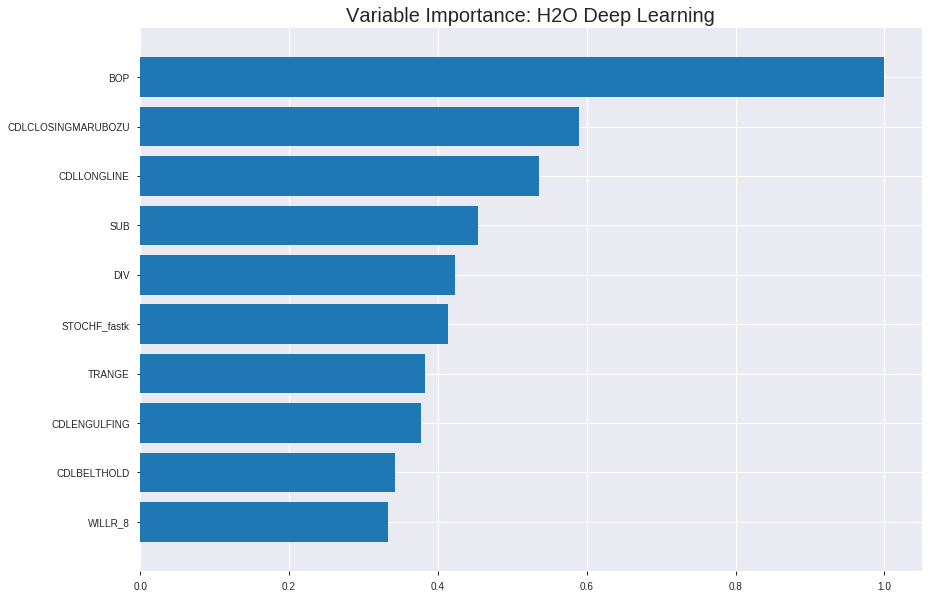

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_170442_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20372556958755386
RMSE: 0.45135968981240876
LogLoss: 0.5883579777973347
Mean Per-Class Error: 0.2918922790431171
AUC: 0.7661145186284851
pr_auc: 0.73825195974123
Gini: 0.5322290372569702
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.368087821707389: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      402  493   0.5508   (493.0/895.0)
1      75   783   0.0874   (75.0/858.0)
Total  477  1276  0.324    (568.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.368088     0.733833  250
max f2                       0.227657     0.849686  315
max f0point5                 0.453639     0.696703  189
max accuracy                 0.453639     0.707359  189
max precision                0.943997     1         0
max recall                   0.0631895    1         381
max specificity              0.943997     1         0
max absolute_mcc             0.452624     0.416929  190
max min_per_class_accuracy   0.461241     0.697207  182
max mean_per_class_accuracy  0.452624     0.708108  190

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 42.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.844916           2.04312   2.04312            1                0.886657  1                           0.886657            0.020979        0.020979                   104.312   104.312
    2        0.0205362                   0.793682           1.7026    1.87286            0.833333         0.810511  0.916667                    0.848584            0.0174825       0.0384615                  70.2603   87.2863
    3        0.0302339                   0.740444           1.92294   1.88893            0.941176         0.767129  0.924528                    0.822457            0.018648        0.0571096                  92.294    88.8926
    4        0.040502                    0.711312           1.92962   1.89924            0.944444         0.724717  0.929577                    0.797678            0.0198135       0.0769231                  92.9617   89.9242
    5        0.0501997                   0.683156           2.04312   1.92704            1                0.697467  0.943182                    0.778319            0.0198135       0.0967366                  104.312   92.7037
    6        0.100399                    0.596127           1.53234   1.72969            0.75             0.634834  0.846591                    0.706576            0.0769231       0.17366                    53.2343   72.969
    7        0.150029                    0.560621           1.31511   1.59255            0.643678         0.578557  0.779468                    0.664228            0.0652681       0.238928                   31.5114   59.2549
    8        0.200228                    0.540796           1.41626   1.54835            0.693182         0.550686  0.757835                    0.635762            0.0710956       0.310023                   41.6256   54.835
    9        0.300057                    0.510807           1.37765   1.49156            0.674286         0.526111  0.730038                    0.599281            0.137529        0.447552                   37.7649   49.1558
    10       0.399886                    0.48356            1.31927   1.44855            0.645714         0.49662   0.708987                    0.573652            0.131702        0.579254                   31.9274   44.8548
    11       0.500285                    0.459126           1.23052   1.40479            0.602273         0.471102  0.687571                    0.553072            0.123543        0.702797                   23.0518   40.4793
    12       0.600114                    0.429884           0.980699  1.33425            0.48             0.445427  0.653042                    0.535165            0.0979021       0.800699                   -1.93007  33.4245
    13       0.699943                    0.386841           0.863949  1.26717            0.422857         0.408577  0.620212                    0.517111            0.0862471       0.886946                   -13.6051  26.717
    14       0.799772                    0.298643           0.6538    1.19061            0.32             0.345974  0.582739                    0.495749            0.0652681       0.952214                   -34.62    19.0608
    15       0.899601                    0.16721            0.338575  1.09606            0.165714         0.238511  0.536462                    0.467203            0.0337995       0.986014                   -66.1425  9.60574
    16       1                           0.00785178         0.139304  1                  0.0681818        0.094218  0.489447                    0.429756            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21452219454130506
RMSE: 0.4631654073236742
LogLoss: 0.6155176847764463
Mean Per-Class Error: 0.31715163737635654
AUC: 0.7284404110246807
pr_auc: 0.672495827409507
Gini: 0.4568808220493614
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46082207689362154: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      141  126  0.4719   (126.0/267.0)
1      38   196  0.1624   (38.0/234.0)
Total  179  322  0.3273   (164.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.460822     0.705036  239
max f2                       0.126376     0.823904  378
max f0point5                 0.491884     0.654281  191
max accuracy                 0.491884     0.678643  191
max precision                0.899185     1         0
max recall                   0.0584563    1         388
max specificity              0.899185     1         0
max absolute_mcc             0.460822     0.380741  239
max min_per_class_accuracy   0.494336     0.674157  188
max mean_per_class_accuracy  0.460822     0.682848  239

Gains/Lift Table: Avg response rate: 46.71 %, avg score: 46.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.761599           2.14103   2.14103            1                0.845392  1                           0.845392            0.025641        0.025641                   114.103   114.103
    2        0.0219561                   0.681132           1.28462   1.75175            0.6              0.704339  0.818182                    0.781277            0.0128205       0.0384615                  28.4615   75.1748
    3        0.0319361                   0.657705           1.71282   1.73958            0.8              0.664851  0.8125                      0.744894            0.017094        0.0555556                  71.2821   73.9583
    4        0.0419162                   0.63837            2.14103   1.83516            1                0.648812  0.857143                    0.722018            0.0213675       0.0769231                  114.103   83.5165
    5        0.0518962                   0.625804           0.85641   1.64694            0.4              0.631598  0.769231                    0.704629            0.00854701      0.0854701                  -14.359   64.6943
    6        0.101796                    0.604152           1.4559    1.55329            0.68             0.612863  0.72549                     0.659646            0.0726496       0.15812                    45.5897   55.3293
    7        0.151697                    0.586861           1.4559    1.52126            0.68             0.592636  0.710526                    0.637603            0.0726496       0.230769                   45.5897   52.1255
    8        0.201597                    0.571219           1.79846   1.58987            0.84             0.580864  0.742574                    0.623559            0.0897436       0.320513                   79.8462   58.9871
    9        0.301397                    0.537626           1.19897   1.46043            0.56             0.551992  0.682119                    0.599861            0.119658        0.440171                   19.8974   46.0435
    10       0.401198                    0.517567           1.19897   1.39539            0.56             0.526819  0.651741                    0.581691            0.119658        0.559829                   19.8974   39.5395
    11       0.500998                    0.491798           1.32744   1.38186            0.62             0.50434   0.645418                    0.566283            0.132479        0.692308                   32.7436   38.1857
    12       0.600798                    0.470217           0.85641   1.29457            0.4              0.482692  0.604651                    0.552397            0.0854701       0.777778                   -14.359   29.4574
    13       0.700599                    0.443403           0.81359   1.22606            0.38             0.458022  0.57265                     0.538953            0.0811966       0.858974                   -18.641   22.6057
    14       0.800399                    0.373051           0.685128  1.15861            0.32             0.413112  0.541147                    0.523262            0.0683761       0.92735                    -31.4872  15.861
    15       0.9002                      0.227192           0.471026  1.08238            0.22             0.307241  0.505543                    0.499313            0.0470085       0.974359                   -52.8974  8.2381
    16       1                           0.00270692         0.256923  1                  0.12             0.124029  0.467066                    0.46186            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:24:46  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 17:24:48  3 min 44.880 sec  268 obs/sec       0.250428  1             439        0.672461         2.42152             -0.80962       0.510199        0.480102           1.13507          0.510553                         0.681133           1.8839                -0.863853        0.545168          0.485056             1.07051            0.483034
    2019-08-27 17:25:15  4 min 12.938 sec  346 obs/sec       5.26868   21            9236       0.500307         0.693794            -0.00167468    0.559898        0.519112           1.24858          0.470622                         0.502035           0.697246              -0.0125505       0.585638          0.507865             0.713675           0.46507
    2019-08-27 17:25:46  4 min 43.169 sec  380 obs/sec       11.8009   47            20687      0.483327         0.658393            0.0651647      0.695582        0.677173           1.92962          0.409013                         0.488309           0.668094              0.0420615        0.697862          0.640668             2.14103            0.39521
    2019-08-27 17:26:12  5 min  9.332 sec  390 obs/sec       17.3554   69            30424      0.462794         0.614906            0.142905       0.74225         0.717508           2.04312          0.345693                         0.482844           0.65543               0.0633844        0.730217          0.682038             2.14103            0.333333
    2019-08-27 17:26:38  5 min 35.658 sec  401 obs/sec       23.2715   93            40795      0.45136          0.588358            0.184735       0.766115        0.738252           2.04312          0.324016                         0.463165           0.615518              0.138172         0.72844           0.672496             2.14103            0.327345
    2019-08-27 17:27:05  6 min  2.243 sec  409 obs/sec       29.3331   117           51421      0.453438         0.592468            0.177208       0.756865        0.744186           2.04312          0.326868                         0.478979           0.647298              0.0783188        0.718669          0.672317             2.14103            0.379242
    2019-08-27 17:27:31  6 min 28.207 sec  416 obs/sec       35.4096   141           62073      0.445261         0.573479            0.206616       0.784615        0.764517           2.04312          0.298916                         0.473642           0.634874              0.0987434        0.727472          0.666985             1.78419            0.365269
    2019-08-27 17:27:58  6 min 54.711 sec  419 obs/sec       41.4478   165           72658      0.453882         0.590293            0.175599       0.733993        0.713572           2.04312          0.353679                         0.499413           0.713504              -0.00200047      0.732658          0.671966             1.78419            0.339321
    2019-08-27 17:28:00  

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.008456091812167695
CDLCLOSINGMARUBOZU        0.5901601910591125     0.5901601910591125   0.004990448759482284
CDLLONGLINE               0.5364589691162109     0.5364589691162109   0.004536346296307513
SUB                       0.45355769991874695    0.45355769991874695  0.003835325552628528
DIV                       0.4229080379009247     0.4229080379009247   0.003576149196593914
---                       ---                    ---                  ---
MAVP_24_7                 0.08802025765180588    0.08802025765180588  0.0007443073800343265
BBANDS_middleband_20_0_4  0.0878107100725174     0.0878107100725174   0.0007425354264648456
BBANDS_middleband_24_2_2  0.08709798753261566    0.08709798753261566  0.0007365085792308353
T3_8_0                    0.086189404129982      0.086189404129982    0.0007288255145591532
BBANDS_middleband_12_6_5  0.08479254692792892    0.08479254692792892  0.0007170135618101048


See the whole table with table.as_data_frame()


('accuracy', 0.7131474103585658)

('F1', 0.6838235294117647)

('auc', 0.7383609080415545)

('logloss', 0.6291119703476559)

('mean_per_class_error', 0.29132999871745535)

('rmse', 0.46874478397183467)

('mse', 0.21972167250080193)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


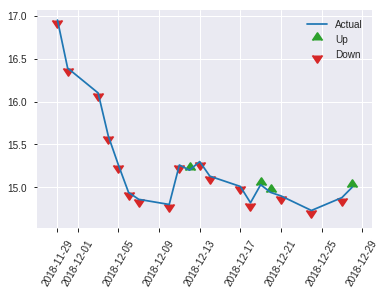


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21972167250080193
RMSE: 0.46874478397183467
LogLoss: 0.6291119703476559
Mean Per-Class Error: 0.29132999871745535
AUC: 0.7383609080415545
pr_auc: 0.64125664597549
Gini: 0.47672181608310904
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4201207827089511: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      72   66   0.4783   (66.0/138.0)
1      20   93   0.177    (20.0/113.0)
Total  92   159  0.3426   (86.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.420121     0.683824  158
max f2                       0.347734     0.827011  206
max f0point5                 0.455772     0.684803  104
max accuracy                 0.455772     0.713147  104
max precision                0.615385     1         0
max recall                   0.1297       1         247
max specificity              0.615385     1         0
max absolute_mcc             0.454439     0.418901  108
max min_per_class_accuracy   0.446929     0.695652  120
max mean_per_class_accuracy  0.454439     0.70867   108

Gains/Lift Table: Avg response rate: 45.02 %, avg score: 42.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.584282           0.740413  0.740413           0.333333         0.596133  0.333333                    0.596133            0.00884956      0.00884956                 -25.9587  -25.9587
    2        0.0239044                   0.582333           2.22124   1.48083            1                0.583326  0.666667                    0.589729            0.0265487       0.0353982                  122.124   48.0826
    3        0.0318725                   0.574005           1.11062   1.38827            0.5              0.577781  0.625                       0.586742            0.00884956      0.0442478                  11.0619   38.8274
    4        0.0438247                   0.56776            2.22124   1.61545            1                0.571096  0.727273                    0.582475            0.0265487       0.0707965                  122.124   61.5447
    5        0.0517928                   0.562538           1.11062   1.53778            0.5              0.564843  0.692308                    0.579762            0.00884956      0.079646                   11.0619   53.7781
    6        0.103586                    0.54204            1.53778   1.53778            0.692308         0.549027  0.692308                    0.564395            0.079646        0.159292                   53.7781   53.7781
    7        0.151394                    0.518381           1.48083   1.5198             0.666667         0.530236  0.684211                    0.553608            0.0707965       0.230088                   48.0826   51.9795
    8        0.203187                    0.502992           1.87951   1.61149            0.846154         0.509705  0.72549                     0.542417            0.0973451       0.327434                   87.951    61.1487
    9        0.302789                    0.483369           1.51044   1.57825            0.68             0.490672  0.710526                    0.525396            0.150442        0.477876                   51.0442   57.8249
    10       0.40239                     0.458621           1.33274   1.51748            0.6              0.472893  0.683168                    0.5124              0.132743        0.610619                   33.2743   51.748
    11       0.501992                    0.443742           1.06619   1.42794            0.48             0.451048  0.642857                    0.500227            0.106195        0.716814                   6.61947   42.7939
    12       0.601594                    0.426814           0.710796  1.30921            0.32             0.434424  0.589404                    0.489332            0.0707965       0.787611                   -28.9204  30.9207
    13       0.701195                    0.405094           0.621947  1.21158            0.28             0.416155  0.545455                    0.478938            0.0619469       0.849558                   -37.8053  21.1585
    14       0.800797                    0.373226           0.977345  1.18245            0.44             0.388221  0.532338                    0.467655            0.0973451       0.946903                   -2.26549  18.2451
    15       0.900398                    0.284078           0.266549  1.08113            0.12             0.327477  0.486726                    0.452148            0.0265487       0.973451                   -73.3451  8.1134
    16       1                           0.0403596          0.266549  1                  0.12             0.195053  0.450199                    0.426541          

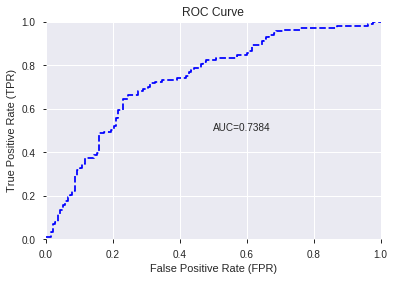

This function is available for GLM models only


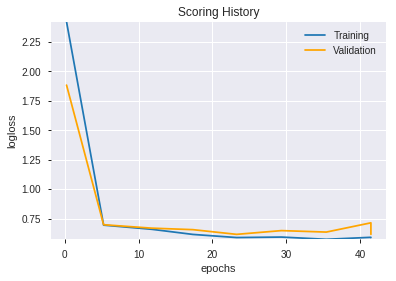

--2019-08-27 17:35:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.104.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.104.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


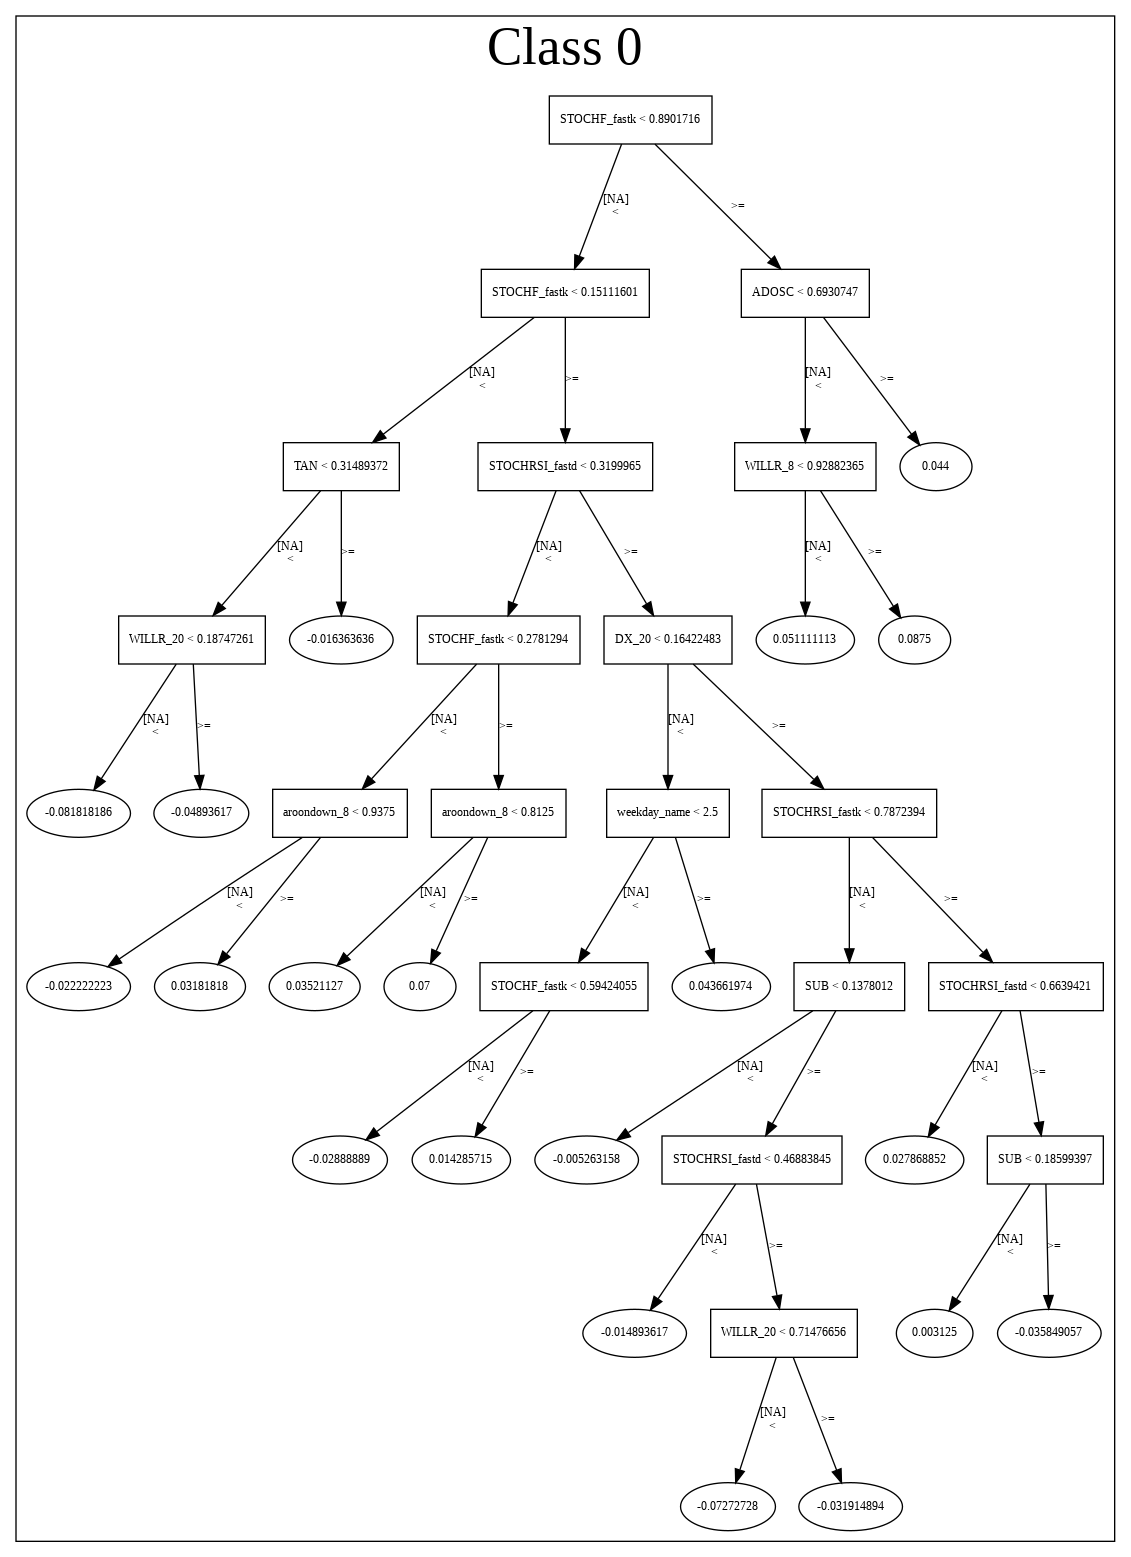

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_170442_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_170442_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_b872',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_173524_model_6  0.730345  0.647781              0.305502  0.479125  0.229561
1  DeepLearning_grid_1_AutoML_20190827_173524_model_9  0.728870  0.631150              0.310312  0.468474  0.219468
2  DeepLearning_grid_1_AutoML_20190827_173524_model_8  0.727588  0.666441              0.330063  0.487152  0.237317
3  DeepLearning_grid_1_AutoML_20190827_173524_model_3  0.669809  0.816044              0.396915  0.527642  0.278406
4  DeepLearning_grid_1_AutoML_20190827_173524_model_7  0.664102  0.726997              0.388835  0.507607  0.257664
5  DeepLearning_grid_1_AutoML_20190827_173524_model_5  0.661216  0.710160              0.372740  0.508047  0.258112
6               DeepLearning_1_AutoML_20190827_173524  0.647557  0.688839              0.394094  0.490096  0.240194
7  DeepLearning_grid_1_AutoML_20190827_173524_model_4  0.615750  0.852174              0.420258  0.538769  0.290272
8  DeepLearning_grid_1_AutoML_20190827_173524_model_2  0.599910  0.940682              0.425516  0.555175  0.308220
9  DeepLearning_grid_1_AutoML_20190827_173524_model_1  0.598756  0.993934              0.402527  0.562596  0.316515

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.032344
1     CDLCLOSINGMARUBOZU             0.753341           0.753341    0.024366
2                    DIV             0.707439           0.707439    0.022882
3                    SUB             0.702311           0.702311    0.022716
4            CDLLONGLINE             0.674356           0.674356    0.021812
5           CDLENGULFING             0.666376           0.666376    0.021554
6           aroondown_30             0.662572           0.662572    0.021431
7                 TRANGE             0.657219           0.657219    0.021257
8   HT_PHASOR_quadrature             0.639786           0.639786    0.020694
9                    day             0.637418           0.637418    0.020617
10          STOCHF_fastk             0.635498           0.635498    0.020555
11             CDLHAMMER             0.633963           0.633963    0.020505
12               ADXR_14             0.626931           0.626931    0.020278
13         days_in_month             0.624813           0.624813    0.020209
14                ULTOSC             0.624309           0.624309    0.020193
15     CDLINVERTEDHAMMER             0.619419           0.619419    0.020035
16              WILLR_14             0.618918           0.618918    0.020019
17           AROONOSC_14             0.618169           0.618169    0.019994
18        STOCHRSI_fastd             0.617280           0.617280    0.019966
19             aroonup_8             0.617030           0.617030    0.019957
20          aroondown_14             0.613829           0.613829    0.019854
21                BETA_8             0.613471           0.613471    0.019842
22                Volume             0.611343           0.611343    0.019774
23            AROONOSC_8             0.610898           0.610898    0.019759
24           CDLBELTHOLD             0.605546           0.605546    0.019586
25                   SIN             0.605167           0.605167    0.019574
26               weekday             0.600366           0.600366    0.019419
27             dayofweek             0.599856           0.599856    0.019402
28     HT_PHASOR_inphase             0.597879           0.597879    0.019338
29           CDLHIGHWAVE             0.596868           0.596868    0.019305
30               BETA_14             0.594427           0.594427    0.019226
31              WILLR_12             0.593863           0.593863    0.019208
32               WILLR_8             0.593858           0.593858    0.019208
33              WILLR_24             0.593829           0.593829    0.019207
34        STOCHRSI_fastk             0.588428           0.588428    0.019032
35           HT_DCPERIOD             0.585377           0.585377    0.018934
36                 month             0.584470           0.584470    0.018904
37             dayofyear             0.583353           0.583353    0.018868
38           aroondown_8             0.582235           0.582235    0.018832
39           STOCH_slowd             0.581473           0.581473    0.018807
40            weekofyear             0.579540           0.579540    0.018745
41              WILLR_30             0.579189           0.579189    0.018734
42          weekday_name             0.577255           0.577255    0.018671
43              WILLR_20             0.574578           0.574578    0.018584
44               quarter             0.573474           0.573474    0.018549
45          STOCHF_fastd             0.565225           0.565225    0.018282
46           CDLMARUBOZU             0.562926           0.562926    0.018208
47                  week             0.556821           0.556821    0.018010
48               BETA_12             0.540146           0.540146    0.017471
49            CDLHIKKAKE             0.534369           0.534369    0.017284

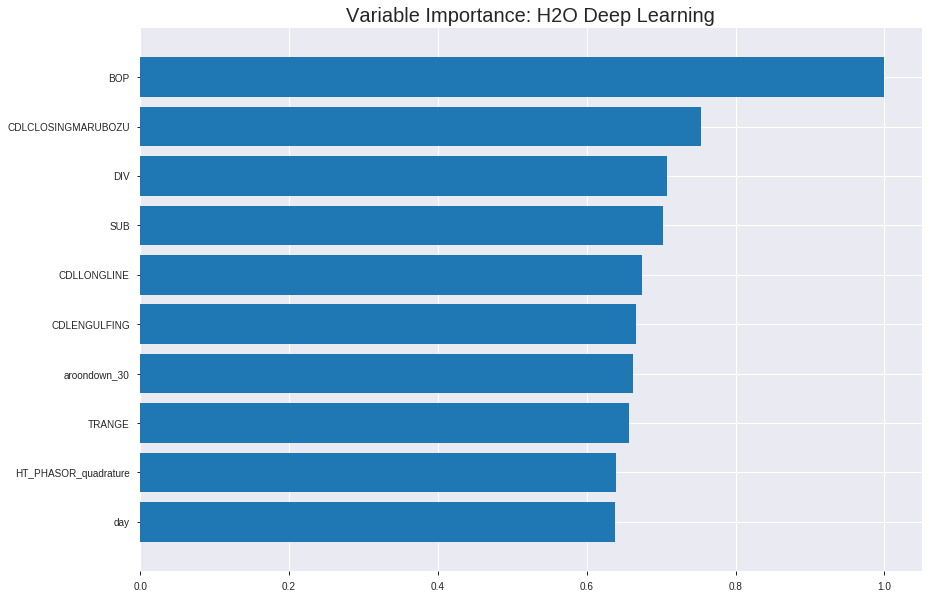

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_173524_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19353339930522792
RMSE: 0.4399243108822561
LogLoss: 0.5641636186328435
Mean Per-Class Error: 0.29511921970022525
AUC: 0.7751904520060944
pr_auc: 0.7442918991122162
Gini: 0.5503809040121888
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4351406588654885: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      403  492   0.5497   (492.0/895.0)
1      68   790   0.0793   (68.0/858.0)
Total  471  1282  0.3195   (560.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.435141     0.738318  243
max f2                       0.260467     0.854456  305
max f0point5                 0.595717     0.69762   159
max accuracy                 0.590621     0.704507  162
max precision                0.946358     1         0
max recall                   0.0273827    1         387
max specificity              0.946358     1         0
max absolute_mcc             0.510072     0.424487  211
max min_per_class_accuracy   0.594615     0.702797  160
max mean_per_class_accuracy  0.586554     0.704881  165

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 51.78 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.87852            2.04312    2.04312            1                0.901398   1                           0.901398            0.020979        0.020979                   104.312   104.312
    2        0.0205362                   0.84575            1.7026     1.87286            0.833333         0.856811   0.916667                    0.879105            0.0174825       0.0384615                  70.2603   87.2863
    3        0.0302339                   0.822479           1.80276    1.85038            0.882353         0.835284   0.90566                     0.865049            0.0174825       0.0559441                  80.2756   85.0376
    4        0.040502                    0.801018           1.92962    1.87047            0.944444         0.812804   0.915493                    0.851804            0.0198135       0.0757576                  92.9617   87.0465
    5        0.0501997                   0.787618           1.80276    1.85739            0.882353         0.792497   0.909091                    0.840347            0.0174825       0.0932401                  80.2756   85.7385
    6        0.100399                    0.738585           1.67165    1.76452            0.818182         0.761967   0.863636                    0.801157            0.0839161       0.177156                   67.1647   76.4516
    7        0.150029                    0.707625           1.36208    1.63139            0.666667         0.7225     0.798479                    0.775137            0.0675991       0.244755                   36.2082   63.1391
    8        0.200228                    0.675089           1.53234    1.60656            0.75             0.689418   0.786325                    0.753646            0.0769231       0.321678                   53.2343   60.6559
    9        0.300057                    0.646621           1.41267    1.54205            0.691429         0.661571   0.754753                    0.723013            0.141026        0.462704                   41.2674   54.2053
    10       0.399886                    0.621268           1.22587    1.46312            0.6              0.633818   0.71612                     0.700746            0.122378        0.585082                   22.5874   46.3121
    11       0.500285                    0.591682           1.23052    1.41644            0.602273         0.606296   0.693273                    0.681792            0.123543        0.708625                   23.0518   41.6441
    12       0.600114                    0.548384           0.933999   1.33619            0.457143         0.569313   0.653992                    0.663081            0.0932401       0.801865                   -6.60007  33.6187
    13       0.699943                    0.477973           0.910649   1.2755             0.445714         0.516045   0.624287                    0.64211             0.0909091       0.892774                   -8.93506  27.5495
    14       0.799772                    0.319957           0.618775   1.19352            0.302857         0.399655   0.584165                    0.611846            0.0617716       0.954545                   -38.1225  19.3522
    15       0.899601                    0.13316            0.361925   1.10124            0.177143         0.228353   0.538998                    0.56929             0.0361305       0.990676                   -63.8075  10.124
    16       1                           0.00116442         0.0928693  1                  0.0454545        0.0560334  0.489447  



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2269998321926202
RMSE: 0.4764449938792727
LogLoss: 0.640213451835768
Mean Per-Class Error: 0.3277393642562182
AUC: 0.7064246614808413
pr_auc: 0.6296691422905213
Gini: 0.41284932296168253
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4508744941805247: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      89   178  0.6667   (178.0/267.0)
1      19   215  0.0812   (19.0/234.0)
Total  108  393  0.3932   (197.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.450874     0.685805  295
max f2                       0.137543     0.830376  373
max f0point5                 0.617907     0.6458    190
max accuracy                 0.617907     0.670659  190
max precision                0.949669     1         0
max recall                   0.137543     1         373
max specificity              0.949669     1         0
max absolute_mcc             0.617907     0.343889  190
max min_per_class_accuracy   0.625991     0.666667  182
max mean_per_class_accuracy  0.617907     0.672261  190

Gains/Lift Table: Avg response rate: 46.71 %, avg score: 55.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.865135           1.42735   1.42735            0.666667         0.889081  0.666667                    0.889081            0.017094        0.017094                   42.735    42.735
    2        0.0219561                   0.83272            1.71282   1.55711            0.8              0.83698   0.727273                    0.865398            0.017094        0.034188                   71.2821   55.711
    3        0.0319361                   0.820795           1.71282   1.60577            0.8              0.823208  0.75                        0.852214            0.017094        0.0512821                  71.2821   60.5769
    4        0.0419162                   0.792927           0.85641   1.42735            0.4              0.800021  0.666667                    0.839787            0.00854701      0.0598291                  -14.359   42.735
    5        0.0518962                   0.778101           1.71282   1.48225            0.8              0.784638  0.692308                    0.829182            0.017094        0.0769231                  71.2821   48.2249
    6        0.101796                    0.748424           1.28462   1.38537            0.6              0.762506  0.647059                    0.796497            0.0641026       0.141026                   28.4615   38.537
    7        0.151697                    0.717913           1.4559    1.40857            0.68             0.731386  0.657895                    0.775079            0.0726496       0.213675                   45.5897   40.857
    8        0.201597                    0.698217           1.4559    1.42028            0.68             0.707339  0.663366                    0.758312            0.0726496       0.286325                   45.5897   42.0284
    9        0.301397                    0.664925           1.4559    1.43208            0.68             0.680454  0.668874                    0.732531            0.145299        0.431624                   45.5897   43.2077
    10       0.401198                    0.646472           1.19897   1.37409            0.56             0.655824  0.641791                    0.71345             0.119658        0.551282                   19.8974   37.4091
    11       0.500998                    0.62242            1.24179   1.34774            0.58             0.634668  0.629482                    0.697756            0.123932        0.675214                   24.1795   34.7737
    12       0.600798                    0.588776           0.899231  1.27323            0.42             0.606122  0.594684                    0.682535            0.0897436       0.764957                   -10.0769  27.3235
    13       0.700599                    0.53654            0.899231  1.21996            0.42             0.562907  0.569801                    0.665494            0.0897436       0.854701                   -10.0769  21.9958
    14       0.800399                    0.440747           0.727949  1.15861            0.34             0.47845   0.541147                    0.642172            0.0726496       0.92735                    -27.2051  15.861
    15       0.9002                      0.240308           0.513846  1.08713            0.24             0.34984   0.507761                    0.609762            0.0512821       0.978632                   -48.6154  8.71283
    16       1                           0.00124923         0.214103  1                  0.1              0.108634  0.467066                    0.559749            0.0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:38:46  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 17:38:50  1 min 47.945 sec  1060 obs/sec      2         1             3506       0.491272         0.719252            0.0341761      0.71169         0.67041            1.5891           0.400456                         0.550224           0.960815              -0.216263        0.677919          0.592348             0.356838           0.401198
    2019-08-27 17:38:55  1 min 53.024 sec  1789 obs/sec      8         4             14024      0.439924         0.564164            0.225521       0.77519         0.744292           2.04312          0.319452                         0.476445           0.640213              0.088044         0.706425          0.629669             1.42735            0.393214
    2019-08-27 17:39:01  1 min 59.007 sec  2369 obs/sec      18        9             31554      0.433166         0.54895             0.249134       0.799407        0.772792           2.04312          0.298916                         0.486385           0.664481              0.0495947        0.696573          0.626237             1.78419            0.383234
    2019-08-27 17:39:06  2 min  4.718 sec  2649 obs/sec      28        14            49084      0.422877         0.527791            0.284381       0.820021        0.801268           2.04312          0.2915                           0.487792           0.671624              0.0440891        0.690411          0.608946             1.07051            0.373253
    2019-08-27 17:39:12  2 min 10.294 sec  2823 obs/sec      38        19            66614      0.413342         0.507051            0.316289       0.843206        0.830481           2.04312          0.255562                         0.495507           0.693077              0.0136134        0.68044           0.609136             1.42735            0.353293
    2019-08-27 17:39:17  2 min 15.744 sec  2947 obs/sec      48        24            84144      0.400655         0.482758            0.357616       0.857705        0.846208           2.04312          0.250998                         0.495397           0.703315              0.014051         0.683481          0.610107             1.78419            0.369261
    2019-08-27 17:39:23  2 min 21.141 sec  3039 obs/sec      58        29            101674     0.390283         0.461943            0.390446       0.87492         0.865739           2.04312          0.222476                         0.497603           0.708104              0.00525092       0.682096          0.610625             1.78419            0.347305
    2019-08-27 17:39:23  2 min 21.672 sec  3037 obs/sec      58        29            101674     0.439924         0.564164            0.225521       0.77519         0.744292           2.04312          0.319452                         0.476445           0.640213              0.088044         0.706425          0.629669             1.42735            0.393214

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.032344449933502814
CDLCLOSINGMARUBOZU  0.7533409595489502     0.7533409595489502   0.024366398948987986
DIV                 0.7074390649795532     0.7074390649795532   0.0228817274182352
SUB                 0.7023110389709473     0.7023110389709473   0.022715864237742144
CDLLONGLINE         0.67435622215271       0.67435622215271     0.021811681064764426
---                 ---                    ---                  ---
STOCHF_fastd        0.5652245283126831     0.5652245283126831   0.01828187645719732
CDLMARUBOZU         0.5629257559776306     0.5629257559776306   0.018207523930497693
week                0.5568205714225769     0.5568205714225769   0.018010055094321964
BETA_12             0.5401455760002136     0.5401455760002136   0.017470711539741945
CDLHIKKAKE          0.5343685150146484     0.5343685150146484   0.017283855679931542


See the whole table with table.as_data_frame()


('accuracy', 0.6972111553784861)

('F1', 0.7075812274368231)

('auc', 0.7303450044889059)

('logloss', 0.6477812226968284)

('mean_per_class_error', 0.2929973066564062)

('rmse', 0.4791251192642638)

('mse', 0.22956087990999505)

deeplearning prediction progress: |███████████████████████████████████████| 100%


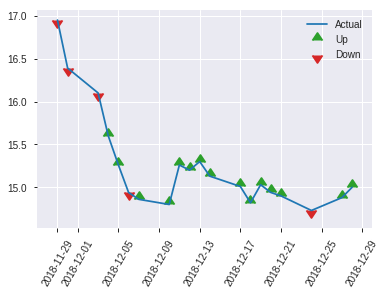


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.22956087990999505
RMSE: 0.4791251192642638
LogLoss: 0.6477812226968284
Mean Per-Class Error: 0.2929973066564062
AUC: 0.7303450044889059
pr_auc: 0.6545866674024284
Gini: 0.46069000897781187
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5763868012969864: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      72   66   0.4783   (66.0/138.0)
1      15   98   0.1327   (15.0/113.0)
Total  87   164  0.3227   (81.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.576387     0.707581  163
max f2                       0.167602     0.815296  240
max f0point5                 0.60214      0.656566  144
max accuracy                 0.60214      0.697211  144
max precision                0.905611     1         0
max recall                   0.167602     1         240
max specificity              0.905611     1         0
max absolute_mcc             0.60214      0.417011  144
max min_per_class_accuracy   0.62151      0.673913  121
max mean_per_class_accuracy  0.60214      0.707003  144

Gains/Lift Table: Avg response rate: 45.02 %, avg score: 57.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.837164           2.22124   2.22124            1                0.871157  1                           0.871157            0.0265487       0.0265487                  122.124   122.124
    2        0.0239044                   0.816452           1.48083   1.85103            0.666667         0.826907  0.833333                    0.849032            0.0176991       0.0442478                  48.0826   85.1032
    3        0.0318725                   0.802814           2.22124   1.94358            1                0.809657  0.875                       0.839188            0.0176991       0.0619469                  122.124   94.3584
    4        0.0438247                   0.789839           0.740413  1.61545            0.333333         0.793277  0.727273                    0.826667            0.00884956      0.0707965                  -25.9587  61.5447
    5        0.0517928                   0.77347            2.22124   1.70865            1                0.781299  0.769231                    0.819687            0.0176991       0.0884956                  122.124   70.8645
    6        0.103586                    0.734207           1.19605   1.45235            0.538462         0.749592  0.653846                    0.78464             0.0619469       0.150442                   19.6052   45.2349
    7        0.151394                    0.708916           2.03614   1.6367             0.916667         0.721022  0.736842                    0.76455             0.0973451       0.247788                   103.614   63.6702
    8        0.203187                    0.687482           1.70865   1.65504            0.769231         0.697992  0.745098                    0.747584            0.0884956       0.336283                   70.8645   65.5041
    9        0.302789                    0.664498           0.888496  1.40289            0.4              0.673117  0.631579                    0.723088            0.0884956       0.424779                   -11.1504  40.2888
    10       0.40239                     0.642426           1.42159   1.40752            0.64             0.652137  0.633663                    0.705526            0.141593        0.566372                   42.1593   40.7518
    11       0.501992                    0.618196           1.33274   1.39268            0.6              0.630227  0.626984                    0.690586            0.132743        0.699115                   33.2743   39.2682
    12       0.601594                    0.588225           1.15504   1.35334            0.52             0.604691  0.609272                    0.676365            0.115044        0.814159                   15.5044   35.3338
    13       0.701195                    0.549379           0.621947  1.24945            0.28             0.573471  0.5625                      0.661749            0.0619469       0.876106                   -37.8053  24.9447
    14       0.800797                    0.471664           0.533097  1.16035            0.24             0.503526  0.522388                    0.64207             0.0530973       0.929204                   -46.6903  16.0349
    15       0.900398                    0.317882           0.266549  1.06148            0.12             0.408619  0.477876                    0.616246            0.0265487       0.955752                   -73.3451  6.1477
    16       1                           0.0288276          0.444248  1                  0.2              0.198194  0.450199                    0.574607          

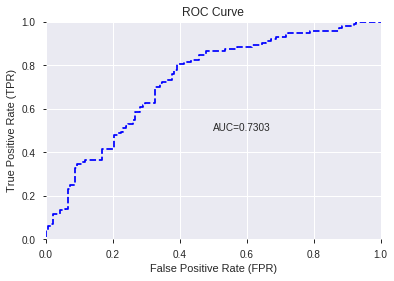

This function is available for GLM models only


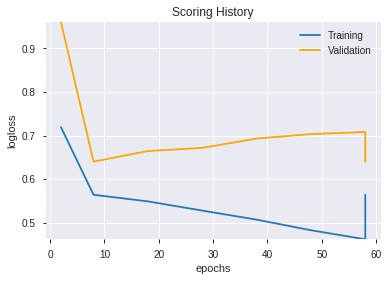

--2019-08-27 17:42:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.236.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.236.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


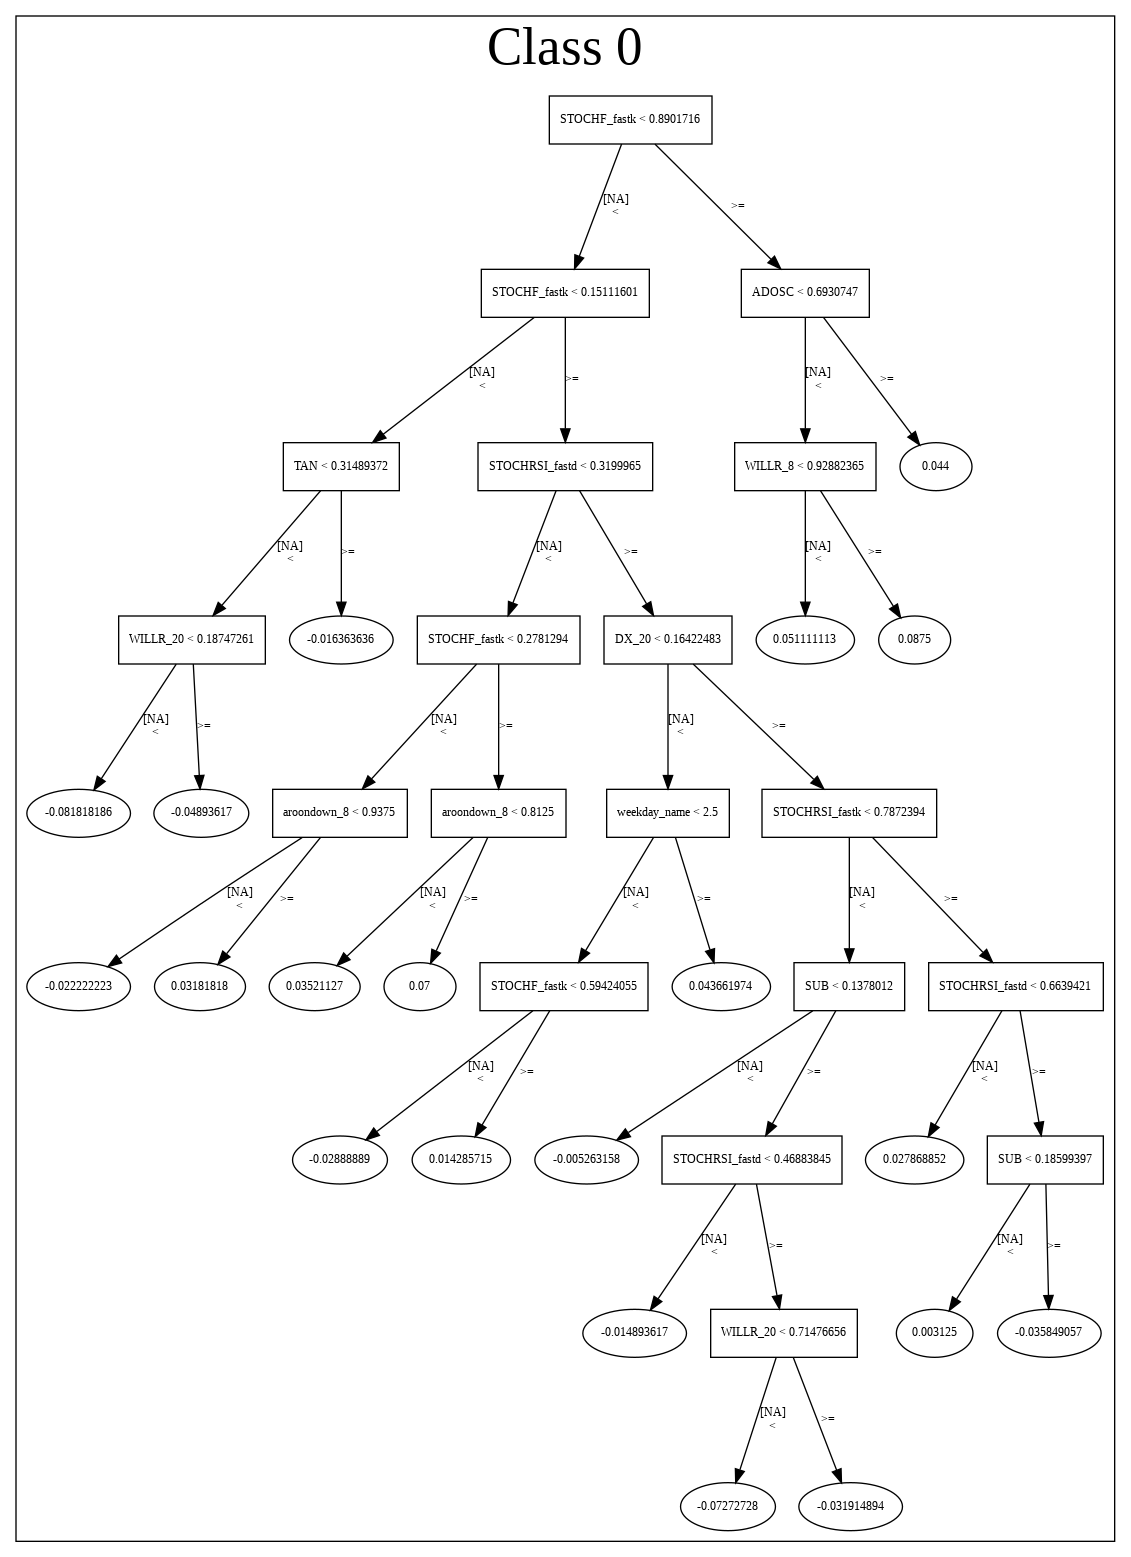

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_173524_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_173524_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_b872',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'SUB',
 'CDLLONGLINE',
 'CDLENGULFING',
 'aroondown_30',
 'TRANGE',
 'HT_PHASOR_quadrature',
 'day',
 'STOCHF_fastk',
 'CDLHAMMER',
 'ADXR_14',
 'days_in_month',
 'ULTOSC',
 'CDLINVERTEDHAMMER',
 'WILLR_14',
 'AROONOSC_14',
 'STOCHRSI_fastd',
 'aroonup_8',
 'aroondown_14',
 'BETA_8',
 'Volume',
 'AROONOSC_8',
 'CDLBELTHOLD',
 'SIN',
 'weekday',
 'dayofweek',
 'HT_PHASOR_inphase',
 'CDLHIGHWAVE',
 'BETA_14',
 'WILLR_12',
 'WILLR_8',
 'WILLR_24',
 'STOCHRSI_fastk',
 'HT_DCPERIOD',
 'month',
 'dayofyear',
 'aroondown_8',
 'STOCH_slowd',
 'weekofyear',
 'WILLR_30',
 'weekday_name',
 'WILLR_20',
 'quarter',
 'STOCHF_fastd',
 'CDLMARUBOZU',
 'week',
 'BETA_12',
 'CDLHIKKAKE']

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_174242_model_1  0.74099  0.612447              0.297037  0.460538  0.212096

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.425545           1.000000    0.122280
1     CDLCLOSINGMARUBOZU             0.173750           0.408299    0.049927
2                    DIV             0.154815           0.363804    0.044486
3            STOCH_slowd             0.133932           0.314730    0.038485
4              CDLHAMMER             0.130461           0.306575    0.037488
5           aroondown_30             0.125057           0.293875    0.035935
6                    day             0.111804           0.262730    0.032127
7                    SUB             0.108786           0.255640    0.031260
8            CDLLONGLINE             0.108247           0.254372    0.031104
9      CDLINVERTEDHAMMER             0.105805           0.248634    0.030403
10                ULTOSC             0.103728           0.243753    0.029806
11          STOCHF_fastk             0.103236           0.242596    0.029665
12          CDLENGULFING             0.100001           0.234995    0.028735
13           CDLHIGHWAVE             0.099294           0.233334    0.028532
14               WILLR_8             0.090267           0.212121    0.025938
15  HT_PHASOR_quadrature             0.086427           0.203097    0.024835
16        STOCHRSI_fastd             0.086232           0.202640    0.024779
17              WILLR_14             0.081612           0.191782    0.023451
18             aroonup_8             0.081455           0.191413    0.023406
19           AROONOSC_14             0.077126           0.181240    0.022162
20          weekday_name             0.075384           0.177148    0.021662
21          aroondown_14             0.072178           0.169613    0.020740
22            AROONOSC_8             0.066054           0.155222    0.018980
23              WILLR_12             0.058967           0.138569    0.016944
24              WILLR_24             0.053985           0.126860    0.015512
25               ADXR_14             0.051824           0.121784    0.014892
26                TRANGE             0.051365           0.120705    0.014760
27          STOCHF_fastd             0.048764           0.114591    0.014012
28     HT_PHASOR_inphase             0.048169           0.113194    0.013841
29             dayofweek             0.047605           0.111869    0.013679
30               weekday             0.047476           0.111565    0.013642
31            CDLHIKKAKE             0.046195           0.108556    0.013274
32              WILLR_20             0.037506           0.088136    0.010777
33                  week             0.035411           0.083214    0.010175
34            weekofyear             0.035408           0.083205    0.010174
35               BETA_12             0.034059           0.080036    0.009787
36           aroondown_8             0.033607           0.078973    0.009657
37               quarter             0.033451           0.078608    0.009612
38              WILLR_30             0.026073           0.061269    0.007492
39           CDLMARUBOZU             0.022927           0.053876    0.006588
40         days_in_month             0.015486           0.036390    0.004450
41           HT_DCPERIOD             0.011674           0.027433    0.003354
42                BETA_8             0.009694           0.022780    0.002786
43                Volume             0.006931           0.016288    0.001992
44             dayofyear             0.005405           0.012701    0.001553
45                   SIN             0.004526           0.010636    0.001301
46           CDLBELTHOLD             0.003874           0.009103    0.001113
47                 month             0.003798           0.008925    0.001091
48               BETA_14             0.002958           0.006952    0.000850
49        STOCHRSI_fastk             0.001767           0.004152    0.000508

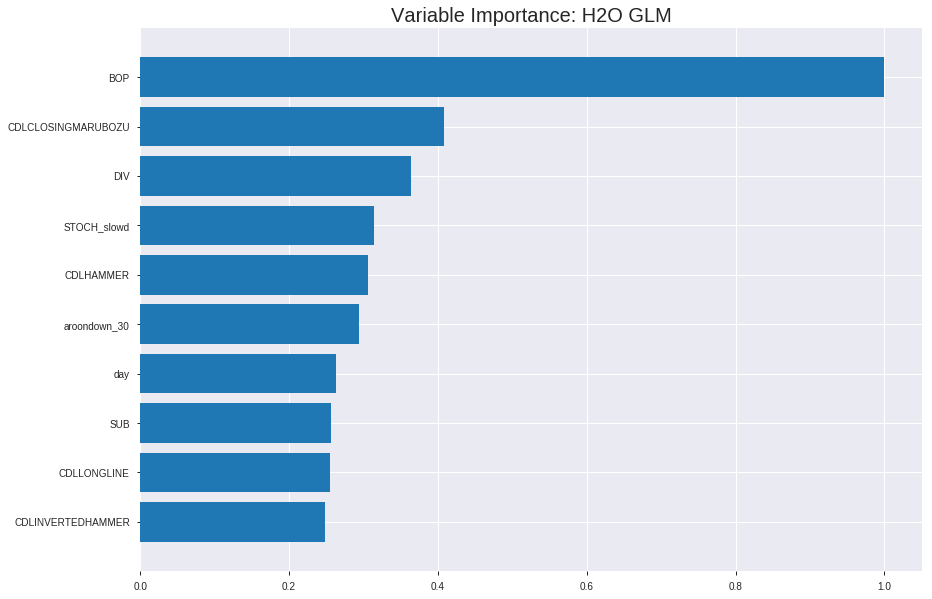

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_174242_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19614328947321377
RMSE: 0.44288067182167
LogLoss: 0.5753981334896189
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2429.39301010051
Residual deviance: 2017.3458560146037
AIC: 2119.3458560146037
AUC: 0.7689566485655871
pr_auc: 0.7217086658252645
Gini: 0.5379132971311742
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37117700374304835: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      434  461   0.5151   (461.0/895.0)
1      84   774   0.0979   (84.0/858.0)
Total  518  1235  0.3109   (545.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.371177     0.739608  267
max f2                       0.225524     0.848448  335
max f0point5                 0.568442     0.693451  158
max accuracy                 0.467558     0.700513  216
max precision                0.784904     0.851852  39
max recall                   0.128762     1         377
max specificity              0.907733     0.998883  0
max absolute_mcc             0.371177     0.424017  267
max min_per_class_accuracy   0.509184     0.689385  191
max mean_per_class_accuracy  0.467558     0.702127  216

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 48.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.861323           1.36208   1.36208            0.666667         0.876008  0.666667                    0.876008            0.013986        0.013986                   36.2082    36.2082
    2        0.0205362                   0.837296           1.92962   1.64585            0.944444         0.847413  0.805556                    0.861711            0.0198135       0.0337995                  92.9617    64.585
    3        0.0302339                   0.818576           1.56239   1.61908            0.764706         0.828731  0.792453                    0.851132            0.0151515       0.048951                   56.2389    61.9079
    4        0.040502                    0.810005           1.7026    1.64025            0.833333         0.812873  0.802817                    0.841433            0.0174825       0.0664336                  70.2603    64.0254
    5        0.0501997                   0.795433           2.04312   1.71808            1                0.802672  0.840909                    0.833945            0.0198135       0.0862471                  104.312    71.8081
    6        0.100399                    0.746961           1.55556   1.63682            0.761364         0.770324  0.801136                    0.802134            0.0780886       0.164336                   55.556     63.6821
    7        0.150029                    0.7059             1.62041   1.63139            0.793103         0.726343  0.798479                    0.777062            0.0804196       0.244755                   62.0408    63.1391
    8        0.200228                    0.676797           1.41626   1.57745            0.693182         0.691251  0.77208                     0.755548            0.0710956       0.315851                   41.6256    57.7454
    9        0.300057                    0.618663           1.48272   1.54594            0.725714         0.647478  0.756654                    0.719594            0.148019        0.463869                   48.2724    54.5938
    10       0.399886                    0.564471           1.27257   1.47769            0.622857         0.592043  0.723252                    0.687752            0.12704         0.590909                   27.2574    47.7694
    11       0.500285                    0.506926           1.02156   1.38616            0.5              0.536307  0.678449                    0.657359            0.102564        0.693473                   2.15618    38.6156
    12       0.600114                    0.449533           1.03907   1.32842            0.508571         0.477145  0.65019                     0.62738             0.10373         0.797203                   3.90743    32.8419
    13       0.699943                    0.373368           0.992374  1.28049            0.485714         0.412767  0.626732                    0.596771            0.0990676       0.89627                    -0.762571  28.0491
    14       0.799772                    0.296017           0.467     1.17895            0.228571         0.335705  0.577033                    0.564185            0.04662         0.94289                    -53.3      17.8949
    15       0.899601                    0.198489           0.431975  1.09606            0.211429         0.24563   0.536462                    0.528835            0.0431235       0.986014                   -56.8025   9.60574
    16       1                           0.0450784          0.139304  1                  0.0681818        0.136523  0.489447                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21486291218270065
RMSE: 0.4635330756080958
LogLoss: 0.6173538054465414
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 693.3634685719368
Residual deviance: 618.5885130574344
AIC: 720.5885130574344
AUC: 0.7184128813342296
pr_auc: 0.6670350539674811
Gini: 0.4368257626684593
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43723261596711005: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      130  137  0.5131   (137.0/267.0)
1      36   198  0.1538   (36.0/234.0)
Total  166  335  0.3453   (173.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.437233     0.695958  254
max f2                       0.272474     0.826087  346
max f0point5                 0.554514     0.642978  180
max accuracy                 0.554514     0.666667  180
max precision                0.888289     1         0
max recall                   0.146484     1         386
max specificity              0.888289     1         0
max absolute_mcc             0.456012     0.357145  245
max min_per_class_accuracy   0.542908     0.662921  187
max mean_per_class_accuracy  0.462841     0.672165  240

Gains/Lift Table: Avg response rate: 46.71 %, avg score: 51.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.847576           2.14103   2.14103            1                0.862296  1                           0.862296            0.025641        0.025641                   114.103   114.103
    2        0.0219561                   0.827291           1.71282   1.94639            0.8              0.832308  0.909091                    0.848665            0.017094        0.042735                   71.2821   94.6387
    3        0.0319361                   0.802112           1.71282   1.8734             0.8              0.813656  0.875                       0.837725            0.017094        0.0598291                  71.2821   87.3397
    4        0.0419162                   0.792403           1.28462   1.73321            0.6              0.794867  0.809524                    0.82752             0.0128205       0.0726496                  28.4615   73.3211
    5        0.0518962                   0.780049           1.28462   1.64694            0.6              0.787374  0.769231                    0.8198              0.0128205       0.0854701                  28.4615   64.6943
    6        0.101796                    0.731725           1.54154   1.59527            0.72             0.746954  0.745098                    0.784091            0.0769231       0.162393                   54.1538   59.5274
    7        0.151697                    0.706112           1.54154   1.5776             0.72             0.716261  0.736842                    0.761778            0.0769231       0.239316                   54.1538   57.7598
    8        0.201597                    0.676013           1.37026   1.52628            0.64             0.691141  0.712871                    0.744294            0.0683761       0.307692                   37.0256   52.6276
    9        0.301397                    0.639246           1.24179   1.43208            0.58             0.65856   0.668874                    0.715905            0.123932        0.431624                   24.1795   43.2077
    10       0.401198                    0.589              1.19897   1.37409            0.56             0.61494   0.641791                    0.690789            0.119658        0.551282                   19.8974   37.4091
    11       0.500998                    0.540352           1.19897   1.33921            0.56             0.564354  0.625498                    0.665603            0.119658        0.67094                    19.8974   33.9207
    12       0.600798                    0.477502           0.984872  1.28035            0.46             0.51694   0.598007                    0.640908            0.0982906       0.769231                   -1.51282  28.0348
    13       0.700599                    0.421827           0.85641   1.21996            0.4              0.449868  0.569801                    0.613695            0.0854701       0.854701                   -14.359   21.9958
    14       0.800399                    0.345863           0.642308  1.14793            0.3              0.384728  0.53616                     0.585145            0.0641026       0.918803                   -35.7692  14.7931
    15       0.9002                      0.256245           0.556667  1.08238            0.26             0.305524  0.505543                    0.554145            0.0555556       0.974359                   -44.3333  8.2381
    16       1                           0.0246059          0.256923  1                  0.12             0.177436  0.467066                    0.516549          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 17:42:43  0.000 sec   2            20        51            1.36753           1.37123
    2019-08-27 17:42:43  0.011 sec   4            12        51            1.35822           1.36468
    2019-08-27 17:42:43  0.023 sec   6            7.7       51            1.34535           1.35554
    2019-08-27 17:42:43  0.037 sec   8            4.8       51            1.32856           1.34341
    2019-08-27 17:42:43  0.049 sec   10           3         51            1.308             1.32829
    2019-08-27 17:42:43  0.064 sec   12           1.9       51            1.28447           1.31071
    2019-08-27 17:42:43  0.076 sec   14           1.2       51            1.25948           1.29192
    2019-08-27 17:42:43  0.088 sec   16           0.71      51            1.23469           1.27373
    2019-08-27 17:42:43  0.100 sec   18           0.44      51            1.21164           1.25798
    2019-08-27 17:42:43  0.111 sec   20           0.28      51            1.19138           1.24603
    2019-08-27 17:42:43  0.123 sec   22           0.17      51            1.17444           1.23844
    2019-08-27 17:42:43  0.135 sec   24           0.11      51            1.16096           1.23494
    2019-08-27 17:42:43  0.147 sec   26           0.066     51            1.1508            1.23471
    2019-08-27 17:42:43  0.158 sec   28           0.041     51            1.14346           1.23671
    2019-08-27 17:42:43  0.170 sec   30           0.025     51            1.13827           1.23992
    2019-08-27 17:42:43  0.185 sec   32           0.016     51            1.13459           1.24352
    2019-08-27 17:42:43  0.202 sec   34           0.0098    51            1.13191           1.24714
    2019-08-27 17:42:43  0.213 sec   36           0.0061    51            1.12996           1.25065

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6972111553784861)

('F1', 0.708955223880597)

('auc', 0.7409901244068231)

('logloss', 0.6124466213568649)

('mean_per_class_error', 0.2970373220469411)

('rmse', 0.4605383152439028)

('mse', 0.2120955398076924)

glm prediction progress: |████████████████████████████████████████████████| 100%


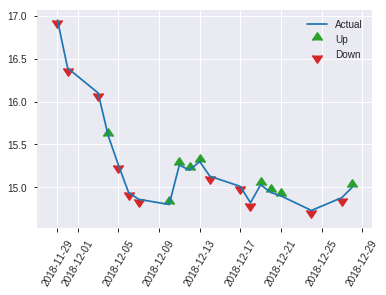


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2120955398076924
RMSE: 0.4605383152439028
LogLoss: 0.6124466213568649
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 347.0162375023202
Residual deviance: 307.44820392114616
AIC: 409.44820392114616
AUC: 0.7409901244068231
pr_auc: 0.6887478737064424
Gini: 0.4819802488136462
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47737626547704376: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      78   60   0.4348   (60.0/138.0)
1      18   95   0.1593   (18.0/113.0)
Total  96   155  0.3108   (78.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.477376     0.708955  154
max f2                       0.308403     0.813253  211
max f0point5                 0.585758     0.668663  96
max accuracy                 0.585758     0.697211  96
max precision                0.888103     1         0
max recall                   0.141086     1         247
max specificity              0.888103     1         0
max absolute_mcc             0.477376     0.41555   154
max min_per_class_accuracy   0.540949     0.666667  121
max mean_per_class_accuracy  0.477376     0.702963  154

Gains/Lift Table: Avg response rate: 45.02 %, avg score: 52.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.865609           2.22124   2.22124            1                0.879707  1                           0.879707            0.0265487       0.0265487                  122.124   122.124
    2        0.0239044                   0.831338           2.22124   2.22124            1                0.841556  1                           0.860632            0.0265487       0.0530973                  122.124   122.124
    3        0.0318725                   0.82168            1.11062   1.94358            0.5              0.827731  0.875                       0.852407            0.00884956      0.0619469                  11.0619   94.3584
    4        0.0438247                   0.80627            2.22124   2.01931            1                0.810817  0.909091                    0.841064            0.0265487       0.0884956                  122.124   101.931
    5        0.0517928                   0.796451           2.22124   2.05037            1                0.801055  0.923077                    0.834909            0.0176991       0.106195                   122.124   105.037
    6        0.103586                    0.756047           1.36692   1.70865            0.615385         0.771289  0.769231                    0.803099            0.0707965       0.176991                   36.6916   70.8645
    7        0.151394                    0.707494           1.48083   1.6367             0.666667         0.731198  0.736842                    0.780393            0.0707965       0.247788                   48.0826   63.6702
    8        0.203187                    0.678418           1.36692   1.56793            0.615385         0.690991  0.705882                    0.757604            0.0707965       0.318584                   36.6916   56.7933
    9        0.302789                    0.625961           1.51044   1.54902            0.68             0.649263  0.697368                    0.721966            0.150442        0.469027                   51.0442   54.9022
    10       0.40239                     0.575503           1.24389   1.4735             0.56             0.602386  0.663366                    0.692367            0.123894        0.59292                    24.3894   47.3495
    11       0.501992                    0.536998           0.977345  1.37505            0.44             0.553757  0.619048                    0.664865            0.0973451       0.690265                   -2.26549  37.5053
    12       0.601594                    0.484614           1.33274   1.36805            0.6              0.507846  0.615894                    0.638868            0.132743        0.823009                   33.2743   36.8048
    13       0.701195                    0.441001           0.533097  1.24945            0.24             0.459535  0.5625                      0.613395            0.0530973       0.876106                   -46.6903  24.9447
    14       0.800797                    0.366229           0.355398  1.13825            0.16             0.407329  0.512438                    0.587765            0.0353982       0.911504                   -64.4602  13.8247
    15       0.900398                    0.244504           0.444248  1.06148            0.2              0.301593  0.477876                    0.556109            0.0442478       0.955752                   -55.5752  6.1477
    16       1                           0.0694717          0.444248  1                  0.2              0.196274  0.450199                    0.520269          

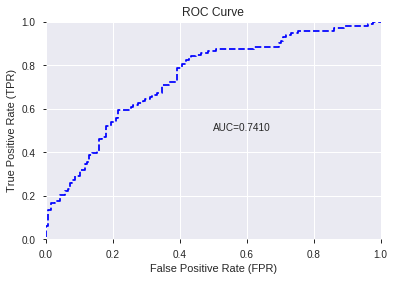

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


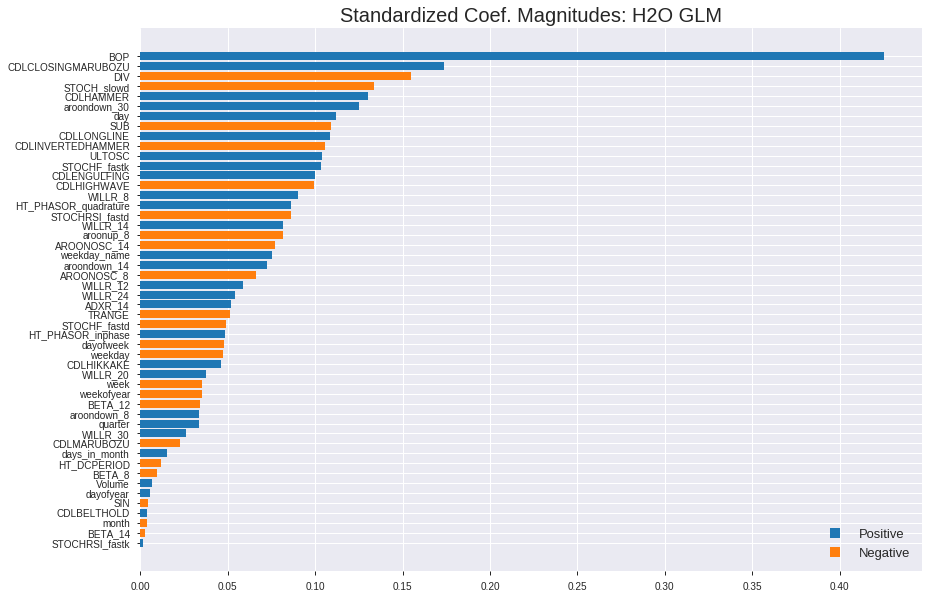

'log_likelihood'
--2019-08-27 17:42:49--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


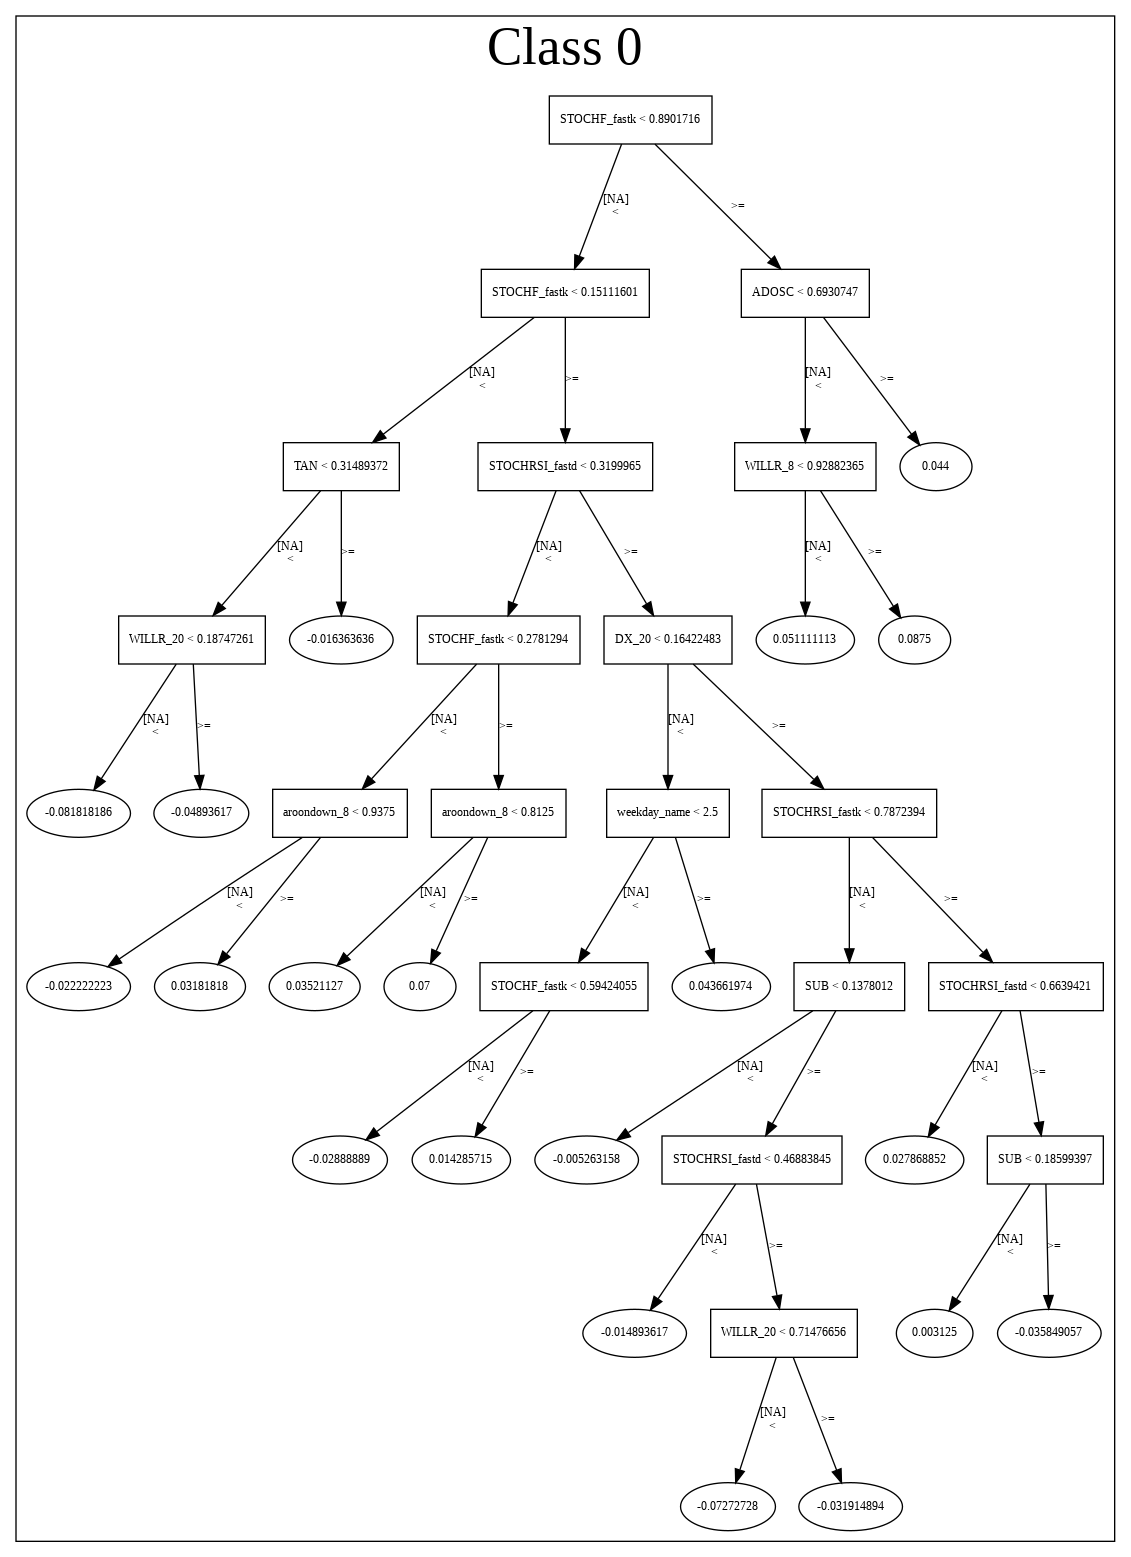

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_174242_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_174242_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_b872',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'STOCH_slowd',
 'CDLHAMMER',
 'aroondown_30',
 'day',
 'SUB',
 'CDLLONGLINE',
 'CDLINVERTEDHAMMER',
 'ULTOSC',
 'STOCHF_fastk',
 'CDLENGULFING',
 'CDLHIGHWAVE',
 'WILLR_8',
 'HT_PHASOR_quadrature',
 'STOCHRSI_fastd',
 'WILLR_14',
 'aroonup_8',
 'AROONOSC_14',
 'weekday_name',
 'aroondown_14',
 'AROONOSC_8',
 'WILLR_12',
 'WILLR_24',
 'ADXR_14',
 'TRANGE',
 'STOCHF_fastd',
 'HT_PHASOR_inphase',
 'dayofweek',
 'weekday',
 'CDLHIKKAKE',
 'WILLR_20',
 'week',
 'weekofyear',
 'BETA_12',
 'aroondown_8',
 'quarter',
 'WILLR_30',
 'CDLMARUBOZU',
 'days_in_month',
 'HT_DCPERIOD',
 'BETA_8',
 'Volume',
 'dayofyear',
 'SIN',
 'CDLBELTHOLD',
 'month',
 'BETA_14',
 'STOCHRSI_fastk']

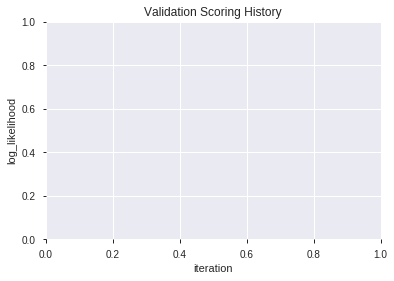

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_174301_model_6  0.741183  0.611524              0.299859  0.461062  0.212578
1  XGBoost_grid_1_AutoML_20190827_174301_model_2  0.730088  0.618641              0.307490  0.463764  0.215077
2               XGBoost_3_AutoML_20190827_174301  0.725022  0.626373              0.345774  0.468261  0.219268
3  XGBoost_grid_1_AutoML_20190827_174301_model_4  0.723868  0.621735              0.346576  0.465246  0.216454
4               XGBoost_2_AutoML_20190827_174301  0.718225  0.626965              0.347377  0.467943  0.218971
5  XGBoost_grid_1_AutoML_20190827_174301_model_5  0.717904  0.631910              0.361068  0.470153  0.221044
6  XGBoost_grid_1_AutoML_20190827_174301_model_3  0.717135  0.624154              0.359465  0.467186  0.218263
7  XGBoost_grid_1_AutoML_20190827_174301_model_7  0.712646  0.629784              0.351417  0.469705  0.220622
8  XGBoost_grid_1_AutoML_20190827_174301_model_1  0.702257  0.638040              0.336892  0.474078  0.224750
9               XGBoost_1_AutoML_20190827_174301  0.700782  0.644239              0.360684  0.475470  0.226071

variable  relative_importance  scaled_importance  percentage
0                    BOP          2121.132568           1.000000    0.215327
1                    DIV           571.601013           0.269479    0.058026
2                    SUB           421.918671           0.198912    0.042831
3           STOCHF_fastk           377.996216           0.178205    0.038372
4                 TRANGE           372.458649           0.175594    0.037810
5         STOCHRSI_fastd           365.150421           0.172149    0.037068
6                    day           325.332855           0.153377    0.033026
7   HT_PHASOR_quadrature           305.581207           0.144065    0.031021
8            HT_DCPERIOD           296.070587           0.139581    0.030056
9            STOCH_slowd           295.600067           0.139360    0.030008
10                Volume           278.404816           0.131253    0.028262
11                ULTOSC           250.536591           0.118115    0.025433
12          aroondown_30           247.096863           0.116493    0.025084
13             dayofyear           245.140961           0.115571    0.024886
14                   SIN           232.899673           0.109800    0.023643
15               ADXR_14           232.766510           0.109737    0.023629
16               BETA_14           225.357834           0.106244    0.022877
17               WILLR_8           224.453506           0.105818    0.022785
18           AROONOSC_14           175.850937           0.082904    0.017852
19     HT_PHASOR_inphase           166.334366           0.078418    0.016885
20               BETA_12           162.048935           0.076397    0.016450
21        STOCHRSI_fastk           157.235703           0.074128    0.015962
22              WILLR_30           148.171539           0.069855    0.015042
23             aroonup_8           135.689896           0.063970    0.013775
24              WILLR_20           131.044647           0.061781    0.013303
25              WILLR_12           128.069931           0.060378    0.013001
26          STOCHF_fastd           125.315018           0.059079    0.012721
27                BETA_8           123.929184           0.058426    0.012581
28             dayofweek           118.145126           0.055699    0.011994
29          aroondown_14           101.855232           0.048019    0.010340
30              WILLR_24            96.624146           0.045553    0.009809
31            AROONOSC_8            93.451714           0.044057    0.009487
32              WILLR_14            84.557205           0.039864    0.008584
33           aroondown_8            84.405220           0.039793    0.008568
34    CDLCLOSINGMARUBOZU            62.267075           0.029356    0.006321
35                  week            51.533150           0.024295    0.005231
36           CDLHIGHWAVE            46.899910           0.022111    0.004761
37          weekday_name            40.908344           0.019286    0.004153
38           CDLLONGLINE            38.769253           0.018278    0.003936
39             CDLHAMMER            34.634186           0.016328    0.003516
40               weekday            32.462914           0.015305    0.003295
41         days_in_month            30.307280           0.014288    0.003077
42            weekofyear            28.414379           0.013396    0.002884
43           CDLBELTHOLD            24.364801           0.011487    0.002473
44     CDLINVERTEDHAMMER            22.876276           0.010785    0.002322
45            CDLHIKKAKE            15.070222           0.007105    0.001530

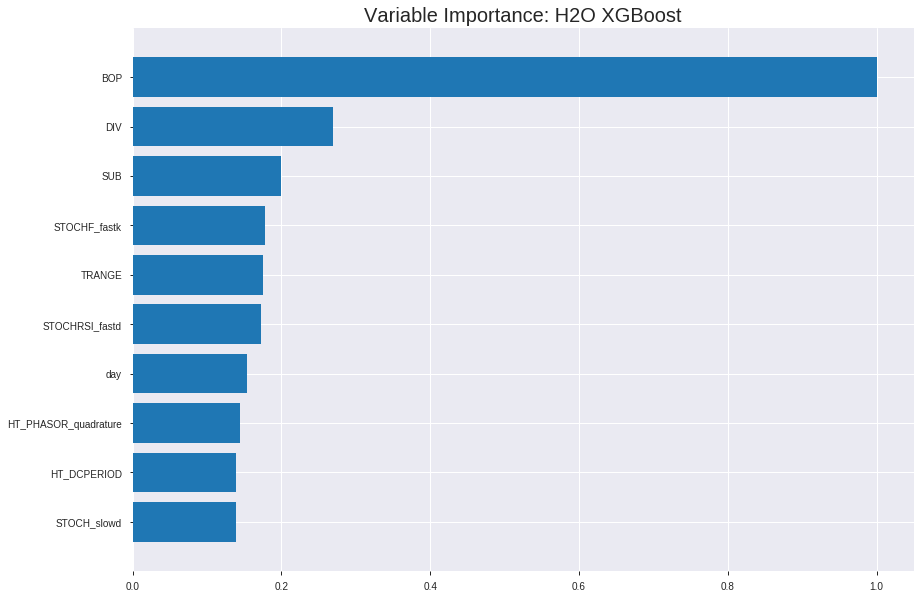

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_174301_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13944568563532955
RMSE: 0.3734242702815787
LogLoss: 0.4448180182131838
Mean Per-Class Error: 0.1605533200505267
AUC: 0.9211632873644047
pr_auc: 0.9183600393082031
Gini: 0.8423265747288093
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5242881178855896: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      738  157  0.1754   (157.0/895.0)
1      125  733  0.1457   (125.0/858.0)
Total  863  890  0.1609   (282.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.524288     0.838673  184
max f2                       0.383167     0.897271  254
max f0point5                 0.599565     0.852117  142
max accuracy                 0.550757     0.839133  170
max precision                0.887103     1         0
max recall                   0.175624     1         334
max specificity              0.887103     1         0
max absolute_mcc             0.524288     0.678823  184
max min_per_class_accuracy   0.536971     0.836872  177
max mean_per_class_accuracy  0.524288     0.839447  184

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 49.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.861231           2.04312   2.04312            1                0.875193   1                           0.875193            0.020979        0.020979                   104.312   104.312
    2        0.0205362                   0.845276           2.04312   2.04312            1                0.852886   1                           0.86404             0.020979        0.041958                   104.312   104.312
    3        0.0302339                   0.833313           2.04312   2.04312            1                0.838722   1                           0.855919            0.0198135       0.0617716                  104.312   104.312
    4        0.040502                    0.823683           2.04312   2.04312            1                0.827732   1                           0.848773            0.020979        0.0827506                  104.312   104.312
    5        0.0501997                   0.814225           2.04312   2.04312            1                0.818391   1                           0.842904            0.0198135       0.102564                   104.312   104.312
    6        0.100399                    0.772345           2.04312   2.04312            1                0.79329    1                           0.818097            0.102564        0.205128                   104.312   104.312
    7        0.150029                    0.732403           1.99616   2.02759            0.977011         0.751577   0.992395                    0.796092            0.0990676       0.304196                   99.6155   102.759
    8        0.200228                    0.702437           1.99669   2.01984            0.977273         0.718689   0.988604                    0.776686            0.100233        0.404429                   99.6689   101.984
    9        0.300057                    0.648264           1.7279    1.92271            0.845714         0.675359   0.941065                    0.742975            0.172494        0.576923                   72.7899   92.2711
    10       0.399886                    0.596553           1.4944    1.81579            0.731429         0.621915   0.88873                     0.712753            0.149184        0.726107                   49.4399   81.5786
    11       0.500285                    0.530512           1.17247   1.68668            0.573864         0.565251   0.825542                    0.683152            0.117716        0.843823                   17.2474   68.6684
    12       0.600114                    0.465627           0.747199  1.5304             0.365714         0.497351   0.749049                    0.652244            0.0745921       0.918415                   -25.2801  53.0401
    13       0.699943                    0.376756           0.548725  1.39039            0.268571         0.424823   0.680522                    0.619808            0.0547786       0.973193                   -45.1275  39.039
    14       0.799772                    0.259526           0.221825  1.24453            0.108571         0.316995   0.60913                     0.58201             0.0221445       0.995338                   -77.8175  24.4527
    15       0.899601                    0.125848           0.0467    1.1116             0.0228571        0.187095   0.544071                    0.538187            0.004662        1                          -95.33    11.1604
    16       1                           0.0477687          0         1                  0                0.0909703  0.489447                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.21673385131708975
RMSE: 0.46554683042320216
LogLoss: 0.6189385763685228
Mean Per-Class Error: 0.30682800345721684
AUC: 0.7296648420243925
pr_auc: 0.6719778368602467
Gini: 0.45932968404878505
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4768630266189575: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      114  153  0.573    (153.0/267.0)
1      32   202  0.1368   (32.0/234.0)
Total  146  355  0.3693   (185.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476863     0.685908  261
max f2                       0.244682     0.834538  349
max f0point5                 0.622608     0.680952  147
max accuracy                 0.622608     0.696607  147
max precision                0.870086     1         0
max recall                   0.16261      1         370
max specificity              0.870086     1         0
max absolute_mcc             0.613849     0.388791  156
max min_per_class_accuracy   0.589998     0.675214  176
max mean_per_class_accuracy  0.613849     0.693172  156

Gains/Lift Table: Avg response rate: 46.71 %, avg score: 54.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.834498           2.14103   2.14103            1                0.848847  1                           0.848847            0.025641        0.025641                   114.103   114.103
    2        0.0219561                   0.821274           1.71282   1.94639            0.8              0.826189  0.909091                    0.838548            0.017094        0.042735                   71.2821   94.6387
    3        0.0319361                   0.8032             1.28462   1.73958            0.6              0.810574  0.8125                      0.829806            0.0128205       0.0555556                  28.4615   73.9583
    4        0.0419162                   0.781044           1.28462   1.63126            0.6              0.78494   0.761905                    0.819124            0.0128205       0.0683761                  28.4615   63.1258
    5        0.0518962                   0.777926           0.85641   1.48225            0.4              0.779803  0.692308                    0.811562            0.00854701      0.0769231                  -14.359   48.2249
    6        0.101796                    0.748631           1.62718   1.55329            0.76             0.762311  0.72549                     0.78742             0.0811966       0.15812                    62.7179   55.3293
    7        0.151697                    0.718894           1.4559    1.52126            0.68             0.730613  0.710526                    0.768733            0.0726496       0.230769                   45.5897   52.1255
    8        0.201597                    0.703337           1.71282   1.56867            0.8              0.71063   0.732673                    0.754351            0.0854701       0.316239                   71.2821   56.8672
    9        0.301397                    0.66242            1.37026   1.50297            0.64             0.68404   0.701987                    0.731069            0.136752        0.452991                   37.0256   50.2972
    10       0.401198                    0.624512           1.4559    1.49126            0.68             0.64365   0.696517                    0.709323            0.145299        0.598291                   45.5897   49.1262
    11       0.500998                    0.582487           0.899231  1.37333            0.42             0.6045    0.641434                    0.688442            0.0897436       0.688034                   -10.0769  37.3327
    12       0.600798                    0.540884           0.685128  1.25901            0.32             0.562413  0.58804                     0.667507            0.0683761       0.75641                    -31.4872  25.9008
    13       0.700599                    0.486942           0.942051  1.21386            0.44             0.515767  0.566952                    0.645892            0.0940171       0.850427                   -5.79487  21.3858
    14       0.800399                    0.39339            0.727949  1.15327            0.34             0.438189  0.538653                    0.619993            0.0726496       0.923077                   -27.2051  15.3271
    15       0.9002                      0.2401             0.642308  1.09662            0.3              0.321493  0.512195                    0.5869              0.0641026       0.987179                   -35.7692  9.66229
    16       1                           0.0538708          0.128462  1                  0.06             0.142313  0.467066                    0.54253          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:43:15  8.846 sec   0                  0.5              0.693147            0.5             0                  1                0.510553                         0.5                0.693147              0.5               0                    1                  0.532934
    2019-08-27 17:43:15  8.976 sec   5                  0.472591         0.639437            0.828755        0.798505           2.04312          0.245864                         0.490034           0.673277              0.664154          0.603913             0.713675           0.43513
    2019-08-27 17:43:15  9.059 sec   10                 0.452226         0.600067            0.840755        0.827306           2.04312          0.251569                         0.48156            0.656164              0.693484          0.641223             1.42735            0.427146
    2019-08-27 17:43:15  9.125 sec   15                 0.436675         0.569728            0.852932        0.841844           2.04312          0.238448                         0.476613           0.645762              0.704176          0.644261             1.78419            0.433134
    2019-08-27 17:43:15  9.304 sec   20                 0.424932         0.546495            0.86352         0.856309           2.04312          0.230462                         0.47195            0.635751              0.715204          0.652179             1.78419            0.419162
    2019-08-27 17:43:16  9.375 sec   25                 0.415929         0.528085            0.872537        0.866392           2.04312          0.236167                         0.46949            0.630091              0.72231           0.661644             2.14103            0.341317
    2019-08-27 17:43:16  9.443 sec   30                 0.407822         0.511554            0.879341        0.874901           2.04312          0.209355                         0.46854            0.627335              0.723887          0.661316             2.14103            0.397206
    2019-08-27 17:43:16  9.511 sec   35                 0.399987         0.496268            0.889854        0.886858           2.04312          0.209355                         0.467867           0.62548               0.722678          0.661835             2.14103            0.367265
    2019-08-27 17:43:16  9.581 sec   40                 0.393462         0.48338             0.897513        0.892501           2.04312          0.197946                         0.467412           0.623922              0.725343          0.66417              1.78419            0.343313
    2019-08-27 17:43:16  9.647 sec   45                 0.387991         0.472742            0.904075        0.901961           2.04312          0.180833                         0.467328           0.623396              0.724247          0.662248             1.78419            0.343313
    2019-08-27 17:43:16  9.724 sec   50                 0.382936         0.462796            0.910141        0.906224           2.04312          0.172847                         0.46639            0.620913              0.724999          0.665966             1.78419            0.345309
    2019-08-27 17:43:16  9.795 sec   55                 0.377589         0.452559            0.915968        0.912323           2.04312          0.16429                          0.46633            0.620632              0.726272          0.

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
BOP                2121.132568359375      1.0                   0.21532732738151675
DIV                571.6010131835938      0.26947915548046486   0.05802622633463671
SUB                421.9186706542969      0.1989119760584492    0.04283118418884211
STOCHF_fastk       377.9962158203125      0.1782048993348303    0.03837238470006124
TRANGE             372.4586486816406      0.17559423406040336   0.03781023712383115
---                ---                    ---                   ---
days_in_month      30.307279586791992     0.014288253378822832  0.0030766514130118466
weekofyear         28.414379119873047     0.013395852547703145  0.0028844931270938
CDLBELTHOLD        24.36480140686035      0.011486694311476114  0.0024733991865386233
CDLINVERTEDHAMMER  22.87627601623535      0.010784934594601687  0.002322291142240043
CDLHIKKAKE         15.070221900939941     0.007104799636637635  0.0015298575173383533


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6852589641434262)

('F1', 0.7084870848708488)

('auc', 0.7411825060920867)

('logloss', 0.6115241637371408)

('mean_per_class_error', 0.2998589200974734)

('rmse', 0.4610616556073298)

('mse', 0.21257785027137202)

xgboost prediction progress: |████████████████████████████████████████████| 100%


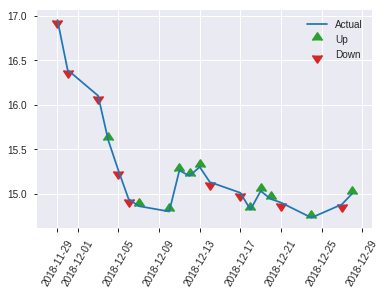


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21257785027137202
RMSE: 0.4610616556073298
LogLoss: 0.6115241637371408
Mean Per-Class Error: 0.2998589200974734
AUC: 0.7411825060920867
pr_auc: 0.6717275681560467
Gini: 0.4823650121841734
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5073301792144775: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      76   62   0.4493   (62.0/138.0)
1      17   96   0.1504   (17.0/113.0)
Total  93   158  0.3147   (79.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.50733      0.708487  157
max f2                       0.280502     0.825959  225
max f0point5                 0.50733      0.644295  157
max accuracy                 0.50733      0.685259  157
max precision                0.888619     1         0
max recall                   0.217515     1         236
max specificity              0.888619     1         0
max absolute_mcc             0.50733      0.412359  157
max min_per_class_accuracy   0.589297     0.646018  118
max mean_per_class_accuracy  0.50733      0.700141  157

Gains/Lift Table: Avg response rate: 45.02 %, avg score: 53.71 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.836372           1.48083    1.48083            0.666667         0.863044  0.666667                    0.863044            0.0176991       0.0176991                  48.0826   48.0826
    2        0.0239044                   0.796286           2.22124    1.85103            1                0.820839  0.833333                    0.841941            0.0265487       0.0442478                  122.124   85.1032
    3        0.0318725                   0.782439           2.22124    1.94358            1                0.787505  0.875                       0.828332            0.0176991       0.0619469                  122.124   94.3584
    4        0.0438247                   0.764688           2.22124    2.01931            1                0.772891  0.909091                    0.813212            0.0265487       0.0884956                  122.124   101.931
    5        0.0517928                   0.760425           1.11062    1.87951            0.5              0.76112   0.846154                    0.805198            0.00884956      0.0973451                  11.0619   87.951
    6        0.103586                    0.726946           1.70865    1.79408            0.769231         0.740183  0.807692                    0.77269             0.0884956       0.185841                   70.8645   79.4078
    7        0.151394                    0.71251            1.29572    1.6367             0.583333         0.718061  0.736842                    0.755439            0.0619469       0.247788                   29.5723   63.6702
    8        0.203187                    0.681346           1.53778    1.61149            0.692308         0.694298  0.72549                     0.739854            0.079646        0.327434                   53.7781   61.1487
    9        0.302789                    0.651272           1.33274    1.5198             0.6              0.667382  0.684211                    0.716015            0.132743        0.460177                   33.2743   51.9795
    10       0.40239                     0.610328           1.15504    1.42951            0.52             0.631583  0.643564                    0.695116            0.115044        0.575221                   15.5044   42.951
    11       0.501992                    0.576206           0.977345   1.33979            0.44             0.594508  0.603175                    0.675154            0.0973451       0.672566                   -2.26549  33.9795
    12       0.601594                    0.531734           1.33274    1.33863            0.6              0.549263  0.602649                    0.654311            0.132743        0.80531                    33.2743   33.8627
    13       0.701195                    0.459981           0.888496   1.27469            0.4              0.491999  0.573864                    0.631255            0.0884956       0.893805                   -11.1504  27.4688
    14       0.800797                    0.381995           0.355398   1.16035            0.16             0.418801  0.522388                    0.604831            0.0353982       0.929204                   -64.4602  16.0349
    15       0.900398                    0.280502           0.621947   1.10079            0.28             0.342761  0.495575                    0.575841            0.0619469       0.99115                    -37.8053  10.0791
    16       1                           0.0640066          0.0888496  1                  0.04             0.186603  0.450199                    0

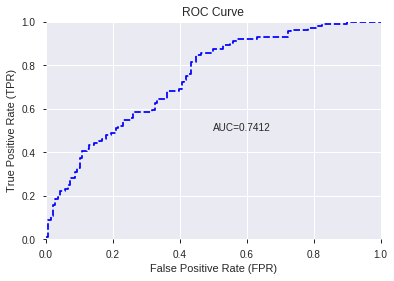

This function is available for GLM models only


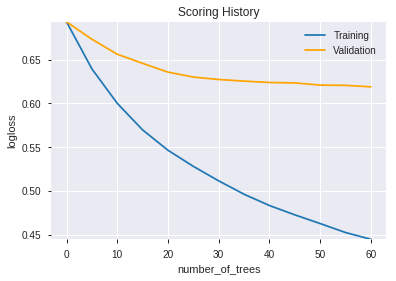

--2019-08-27 17:43:22--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.16.176
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.16.176|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

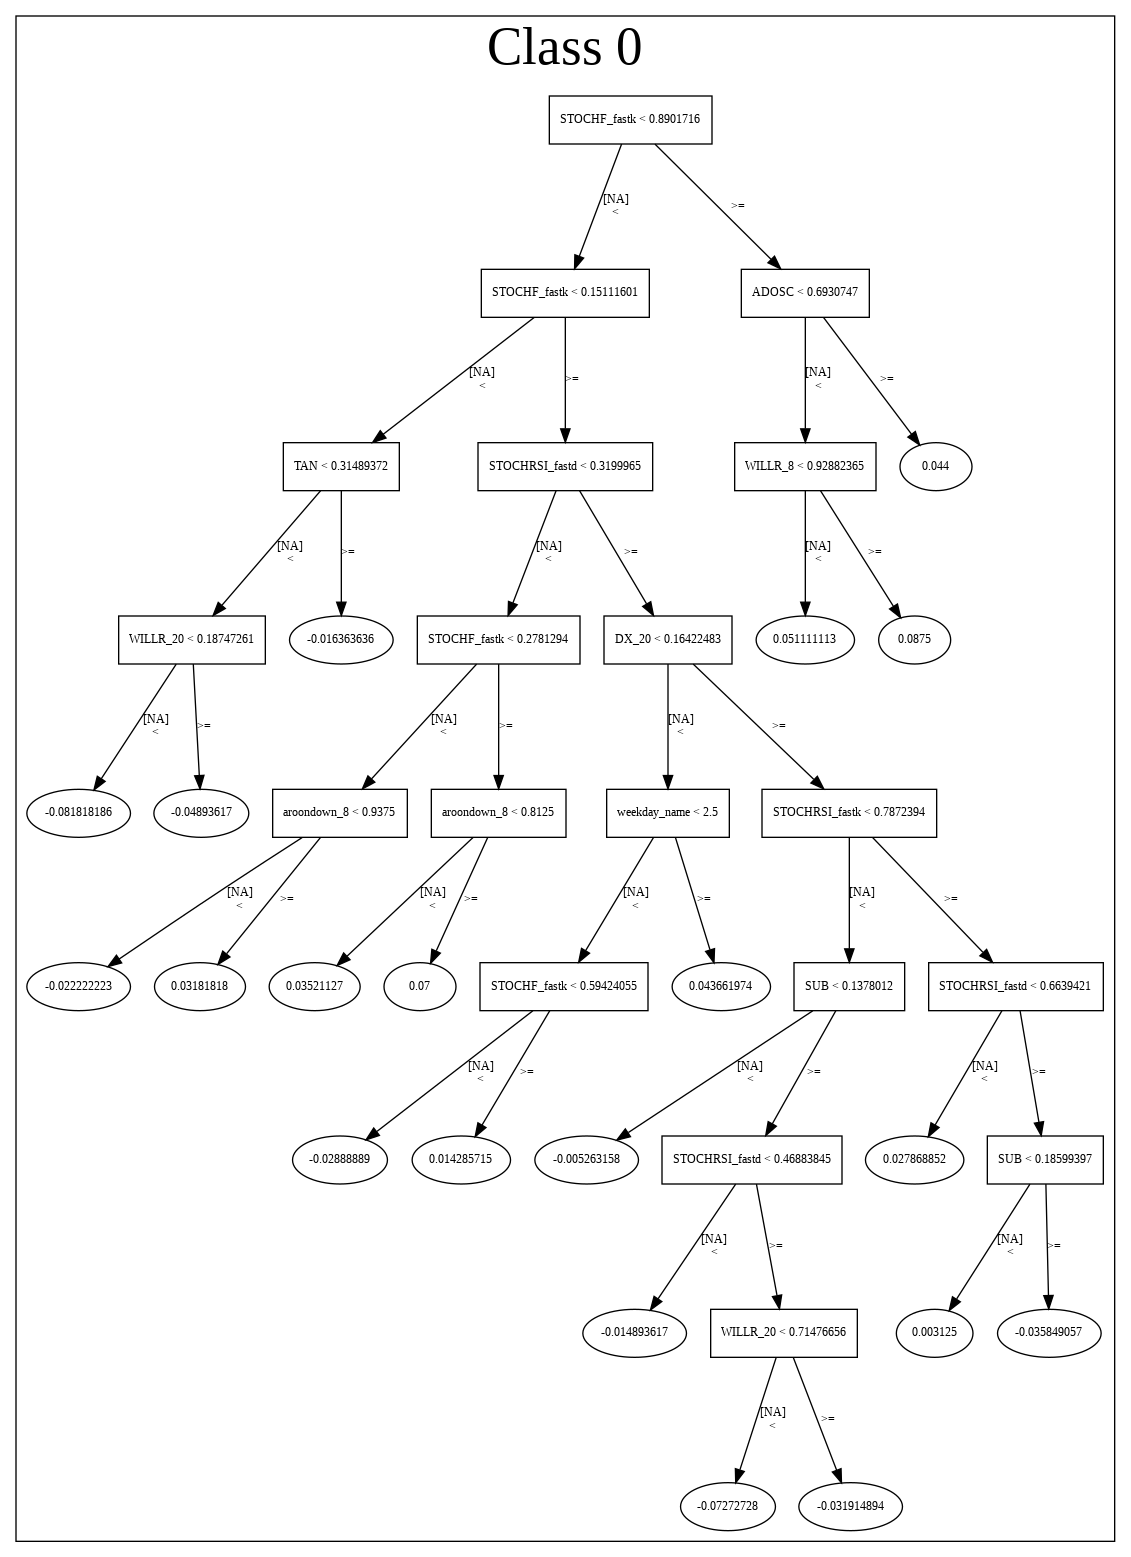

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_174301_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_174301_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_b872',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'SUB',
 'STOCHF_fastk',
 'TRANGE',
 'STOCHRSI_fastd',
 'day',
 'HT_PHASOR_quadrature',
 'HT_DCPERIOD',
 'STOCH_slowd',
 'Volume',
 'ULTOSC',
 'aroondown_30',
 'dayofyear',
 'SIN',
 'ADXR_14',
 'BETA_14',
 'WILLR_8',
 'AROONOSC_14',
 'HT_PHASOR_inphase',
 'BETA_12',
 'STOCHRSI_fastk',
 'WILLR_30',
 'aroonup_8',
 'WILLR_20',
 'WILLR_12',
 'STOCHF_fastd',
 'BETA_8',
 'dayofweek',
 'aroondown_14',
 'WILLR_24',
 'AROONOSC_8',
 'WILLR_14',
 'aroondown_8',
 'CDLCLOSINGMARUBOZU',
 'week',
 'CDLHIGHWAVE',
 'weekday_name',
 'CDLLONGLINE',
 'CDLHAMMER',
 'weekday',
 'days_in_month',
 'weekofyear',
 'CDLBELTHOLD',
 'CDLINVERTEDHAMMER',
 'CDLHIKKAKE']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_174336_model_1  0.760613  0.591032              0.272445  0.448763  0.201388

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.297849           1.000000  3.362013e-02
1           CDLCLOSINGMARUBOZU             0.135644           0.455413  1.531104e-02
2                          SUB             0.130084           0.436746  1.468344e-02
3                          DIV             0.121767           0.408822  1.374464e-02
4                    CDLHAMMER             0.095420           0.320364  1.077067e-02
...                        ...                  ...                ...           ...
1039                  MAVP_8_6             0.000012           0.000041  1.362455e-06
1040  BBANDS_middleband_24_0_4             0.000012           0.000040  1.339588e-06
1041                    T3_8_4             0.000011           0.000039  1.297365e-06
1042   BBANDS_middleband_8_6_5             0.000007           0.000025  8.422375e-07
1043  BBANDS_middleband_14_5_4             0.000004           0.000012  4.144375e-07

[1044 rows x 4 columns]

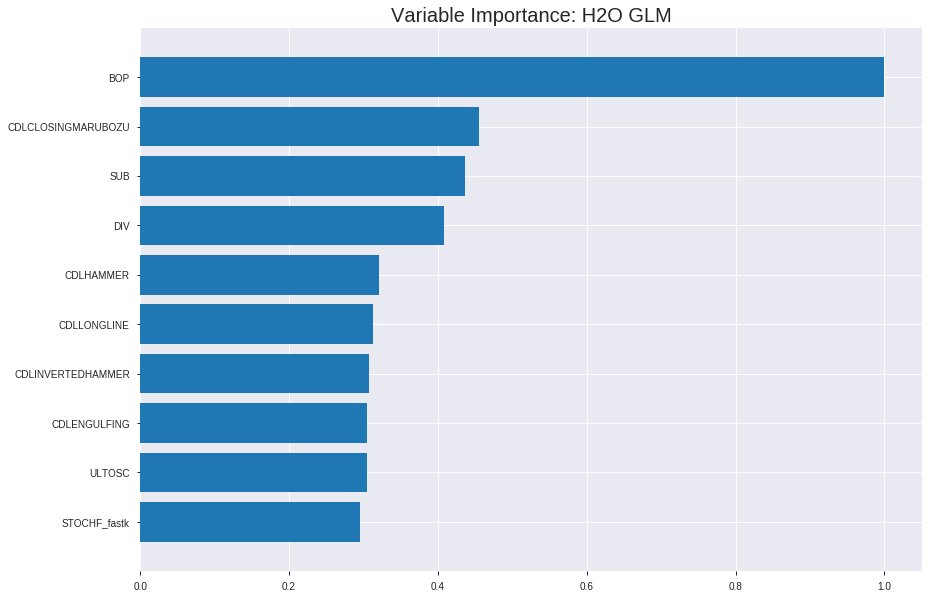

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_174336_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18833412978947262
RMSE: 0.43397480317349374
LogLoss: 0.5574317874309042
Null degrees of freedom: 1752
Residual degrees of freedom: 708
Null deviance: 2429.39301010051
Residual deviance: 1954.3558467327498
AIC: 4044.35584673275
AUC: 0.7925004232266801
pr_auc: 0.762022645742711
Gini: 0.5850008464533603
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3703095946891493: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      434  461   0.5151   (461.0/895.0)
1      78   780   0.0909   (78.0/858.0)
Total  512  1241  0.3075   (539.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37031      0.743211  260
max f2                       0.21945      0.851235  334
max f0point5                 0.542026     0.719678  167
max accuracy                 0.493393     0.719909  192
max precision                0.954545     1         0
max recall                   0.14736      1         367
max specificity              0.954545     1         0
max absolute_mcc             0.455339     0.445594  214
max min_per_class_accuracy   0.513426     0.714452  182
max mean_per_class_accuracy  0.47119      0.720683  205

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 48.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.867358           1.92962   1.92962            0.944444         0.897554  0.944444                    0.897554            0.0198135       0.0198135                  92.9617    92.9617
    2        0.0205362                   0.851664           1.81611   1.87286            0.888889         0.858231  0.916667                    0.877893            0.018648        0.0384615                  81.611     87.2863
    3        0.0302339                   0.826991           1.68257   1.81183            0.823529         0.840043  0.886792                    0.865752            0.016317        0.0547786                  68.2572    81.1827
    4        0.040502                    0.811736           1.7026    1.78414            0.833333         0.818818  0.873239                    0.853853            0.0174825       0.0722611                  70.2603    78.4136
    5        0.0501997                   0.794856           1.56239   1.7413             0.764706         0.802705  0.852273                    0.843972            0.0151515       0.0874126                  56.2389    74.1298
    6        0.100399                    0.739418           1.76452   1.75291            0.863636         0.763846  0.857955                    0.803909            0.0885781       0.175991                   76.4516    75.2907
    7        0.150029                    0.70383            1.59692   1.70131            0.781609         0.72098   0.8327                      0.776476            0.0792541       0.255245                   59.6924    70.1308
    8        0.200228                    0.673236           1.60199   1.67641            0.784091         0.687269  0.820513                    0.754111            0.0804196       0.335664                   60.1995    67.6409
    9        0.300057                    0.614871           1.33095   1.56147            0.651429         0.64338   0.764259                    0.717271            0.132867        0.468531                   33.0949    56.1475
    10       0.399886                    0.566286           1.41267   1.52433            0.691429         0.590573  0.746077                    0.685642            0.141026        0.609557                   41.2674    52.4328
    11       0.500285                    0.506614           1.11443   1.44207            0.545455         0.538188  0.705815                    0.65605             0.111888        0.721445                   11.4431    44.2068
    12       0.600114                    0.444555           0.992374  1.36726            0.485714         0.475367  0.669202                    0.625993            0.0990676       0.820513                   -0.762571  36.7261
    13       0.699943                    0.378043           0.817249  1.28882            0.4              0.411538  0.630807                    0.595407            0.0815851       0.902098                   -18.2751   28.8816
    14       0.799772                    0.29401            0.548725  1.19644            0.268571         0.332903  0.585592                    0.562641            0.0547786       0.956876                   -45.1275   19.6437
    15       0.899601                    0.204902           0.3269    1.09994            0.16             0.252166  0.538364                    0.528187            0.032634        0.98951                    -67.31     9.99441
    16       1                           0.0321409          0.104478  1                  0.0511364        0.142322  0.489447                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21190463156919248
RMSE: 0.46033100218124834
LogLoss: 0.6117873514131559
Null degrees of freedom: 500
Residual degrees of freedom: -544
Null deviance: 693.3634685719368
Residual deviance: 613.0109261159823
AIC: 2703.0109261159823
AUC: 0.7246870898556292
pr_auc: 0.6795068722086165
Gini: 0.4493741797112585
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3863988576725014: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      123  144  0.5393   (144.0/267.0)
1      32   202  0.1368   (32.0/234.0)
Total  155  346  0.3513   (176.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.386399     0.696552  267
max f2                       0.14802      0.820423  383
max f0point5                 0.519581     0.653358  166
max accuracy                 0.519581     0.674651  166
max precision                0.937875     1         0
max recall                   0.125298     1         390
max specificity              0.937875     1         0
max absolute_mcc             0.406831     0.353268  251
max min_per_class_accuracy   0.490829     0.666667  184
max mean_per_class_accuracy  0.454535     0.673005  218

Gains/Lift Table: Avg response rate: 46.71 %, avg score: 47.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.816351           2.14103   2.14103            1                0.851314  1                           0.851314            0.025641        0.025641                   114.103   114.103
    2        0.0219561                   0.774946           1.71282   1.94639            0.8              0.790399  0.909091                    0.823625            0.017094        0.042735                   71.2821   94.6387
    3        0.0319361                   0.755715           1.71282   1.8734             0.8              0.765063  0.875                       0.805325            0.017094        0.0598291                  71.2821   87.3397
    4        0.0419162                   0.737812           1.71282   1.83516            0.8              0.742118  0.857143                    0.790276            0.017094        0.0769231                  71.2821   83.5165
    5        0.0518962                   0.730462           1.28462   1.72929            0.6              0.734201  0.807692                    0.779492            0.0128205       0.0897436                  28.4615   72.929
    6        0.101796                    0.694307           1.37026   1.55329            0.64             0.712577  0.72549                     0.74669             0.0683761       0.15812                    37.0256   55.3293
    7        0.151697                    0.654258           1.54154   1.54943            0.72             0.672624  0.723684                    0.722326            0.0769231       0.235043                   54.1538   54.9426
    8        0.201597                    0.627004           1.8841    1.63227            0.88             0.64009   0.762376                    0.701971            0.0940171       0.32906                    88.4103   63.2267
    9        0.301397                    0.574613           1.19897   1.48879            0.56             0.599761  0.695364                    0.668127            0.119658        0.448718                   19.8974   48.8793
    10       0.401198                    0.535095           1.11333   1.39539            0.52             0.556578  0.651741                    0.640378            0.111111        0.559829                   11.3333   39.5395
    11       0.500998                    0.488202           1.24179   1.3648             0.58             0.510399  0.63745                     0.614486            0.123932        0.683761                   24.1795   36.4797
    12       0.600798                    0.44203            0.899231  1.28746            0.42             0.467825  0.601329                    0.590124            0.0897436       0.773504                   -10.0769  28.7461
    13       0.700599                    0.373701           0.899231  1.23216            0.42             0.409138  0.575499                    0.564342            0.0897436       0.863248                   -10.0769  23.2157
    14       0.800399                    0.3096             0.556667  1.14793            0.26             0.343007  0.53616                     0.536744            0.0555556       0.918803                   -44.3333  14.7931
    15       0.9002                      0.211692           0.428205  1.06814            0.2              0.266046  0.498891                    0.506733            0.042735        0.961538                   -57.1795  6.81392
    16       1                           0.0423463          0.385385  1                  0.18             0.155608  0.467066                    0.471691          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 17:43:39  0.000 sec   2            .2E2      1015          1.3613385087698928  1.3684602578434375
     2019-08-27 17:43:41  2.192 sec   4            .15E2     1031          1.354242352079027   1.3636026901267038
     2019-08-27 17:43:43  4.386 sec   6            .11E2     1033          1.3454521892541806  1.3574450870622563
     2019-08-27 17:43:46  6.604 sec   8            .77E1     1039          1.334797769938863   1.3498607976890442
     2019-08-27 17:43:48  8.794 sec   10           .56E1     1045          1.3221507466848823  1.3407496660550393
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 17:44:16  37.234 sec  36           .91E-1    1045          1.102140877772123   1.2245893353094701
     2019-08-27 17:44:18  39.364 sec  38           .66E-1    1045          1.0905198427373566  1.2278739189044177
     2019-08-27 17:44:20  41.518 sec  40           .48E-1    1045          1.0797600169041337  1.2331886266253016
     2019-08-27 17:44:23  43.696 sec  42           .35E-1    1045          1.0700044563306161  1.2405247211566706
     2019-08-27 17:44:25  45.957 sec  44           .25E-1    1045          1.0609412584287914  1.249813457254122


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7410358565737052)

('F1', 0.7112970711297072)

('auc', 0.7606130563037066)

('logloss', 0.591032138679681)

('mean_per_class_error', 0.26195972810055146)

('rmse', 0.44876324946961793)

('mse', 0.20138845407453052)

glm prediction progress: |████████████████████████████████████████████████| 100%


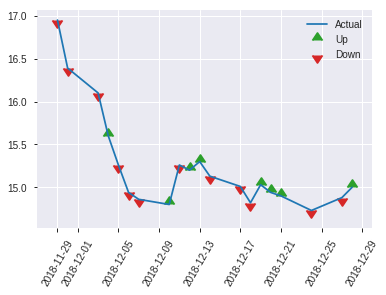


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20138845407453052
RMSE: 0.44876324946961793
LogLoss: 0.591032138679681
Null degrees of freedom: 250
Residual degrees of freedom: -794
Null deviance: 347.0162375023202
Residual deviance: 296.6981336171998
AIC: 2386.6981336172
AUC: 0.7606130563037066
pr_auc: 0.7181242539058031
Gini: 0.5212261126074131
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43979751731227745: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      97   41   0.2971   (41.0/138.0)
1      28   85   0.2478   (28.0/113.0)
Total  125  126  0.2749   (69.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.439798     0.711297  125
max f2                       0.150625     0.808298  246
max f0point5                 0.486695     0.715667  100
max accuracy                 0.474849     0.741036  109
max precision                0.811169     1         0
max recall                   0.150625     1         246
max specificity              0.811169     1         0
max absolute_mcc             0.471604     0.476478  111
max min_per_class_accuracy   0.4609       0.725664  118
max mean_per_class_accuracy  0.471604     0.73804   111

Gains/Lift Table: Avg response rate: 45.02 %, avg score: 44.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.772374           2.22124   2.22124            1                0.791737  1                           0.791737            0.0265487       0.0265487                  122.124   122.124
    2        0.0239044                   0.76443            2.22124   2.22124            1                0.76539   1                           0.778564            0.0265487       0.0530973                  122.124   122.124
    3        0.0318725                   0.760988           2.22124   2.22124            1                0.762271  1                           0.77449             0.0176991       0.0707965                  122.124   122.124
    4        0.0438247                   0.740805           2.22124   2.22124            1                0.747471  1                           0.767121            0.0265487       0.0973451                  122.124   122.124
    5        0.0517928                   0.731483           1.11062   2.05037            0.5              0.73587   0.923077                    0.762313            0.00884956      0.106195                   11.0619   105.037
    6        0.103586                    0.667808           1.53778   1.79408            0.692308         0.701053  0.807692                    0.731683            0.079646        0.185841                   53.7781   79.4078
    7        0.151394                    0.630658           1.66593   1.75361            0.75             0.651627  0.789474                    0.706402            0.079646        0.265487                   66.5929   75.361
    8        0.203187                    0.600238           1.36692   1.65504            0.615385         0.613307  0.745098                    0.682672            0.0707965       0.336283                   36.6916   65.5041
    9        0.302789                    0.549372           1.68814   1.66593            0.76             0.569789  0.75                        0.64554             0.168142        0.504425                   68.8142   66.5929
    10       0.40239                     0.486695           1.51044   1.62744            0.68             0.521516  0.732673                    0.614841            0.150442        0.654867                   51.0442   62.7442
    11       0.501992                    0.439798           0.977345  1.49845            0.44             0.466353  0.674603                    0.585379            0.0973451       0.752212                   -2.26549  49.8455
    12       0.601594                    0.396468           0.533097  1.33863            0.24             0.416671  0.602649                    0.557447            0.0530973       0.80531                    -46.6903  33.8627
    13       0.701195                    0.348675           0.533097  1.22421            0.24             0.368137  0.551136                    0.530556            0.0530973       0.858407                   -46.6903  22.4206
    14       0.800797                    0.294478           0.444248  1.1272             0.2              0.31826   0.507463                    0.504151            0.0442478       0.902655                   -55.5752  12.7196
    15       0.900398                    0.232546           0.621947  1.07131            0.28             0.26353   0.482301                    0.477534            0.0619469       0.964602                   -37.8053  7.13055
    16       1                           0.0610845          0.355398  1                  0.16             0.17782   0.450199                    0.447682          

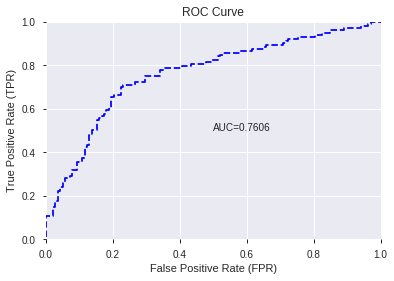

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


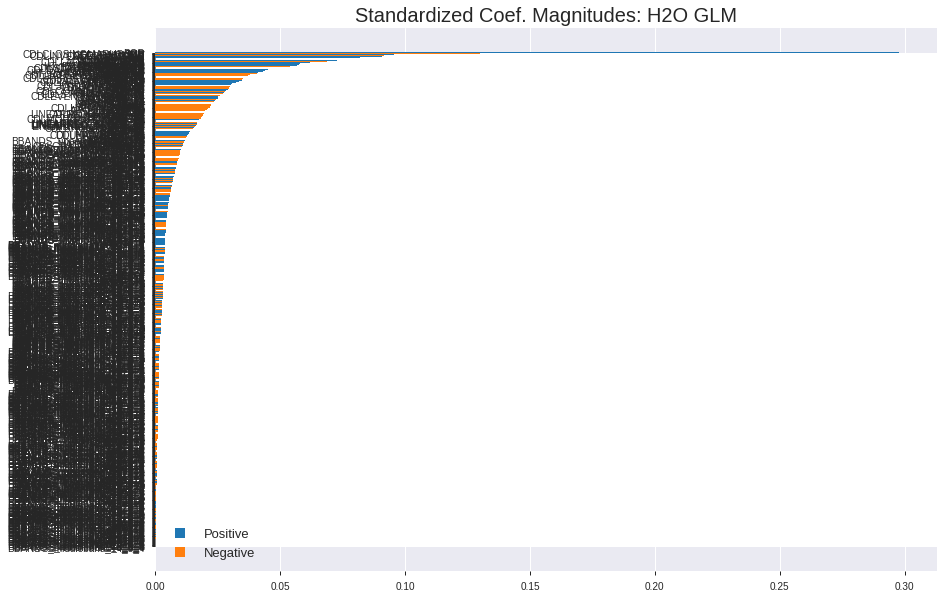

'log_likelihood'
--2019-08-27 17:44:49--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.93.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.93.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


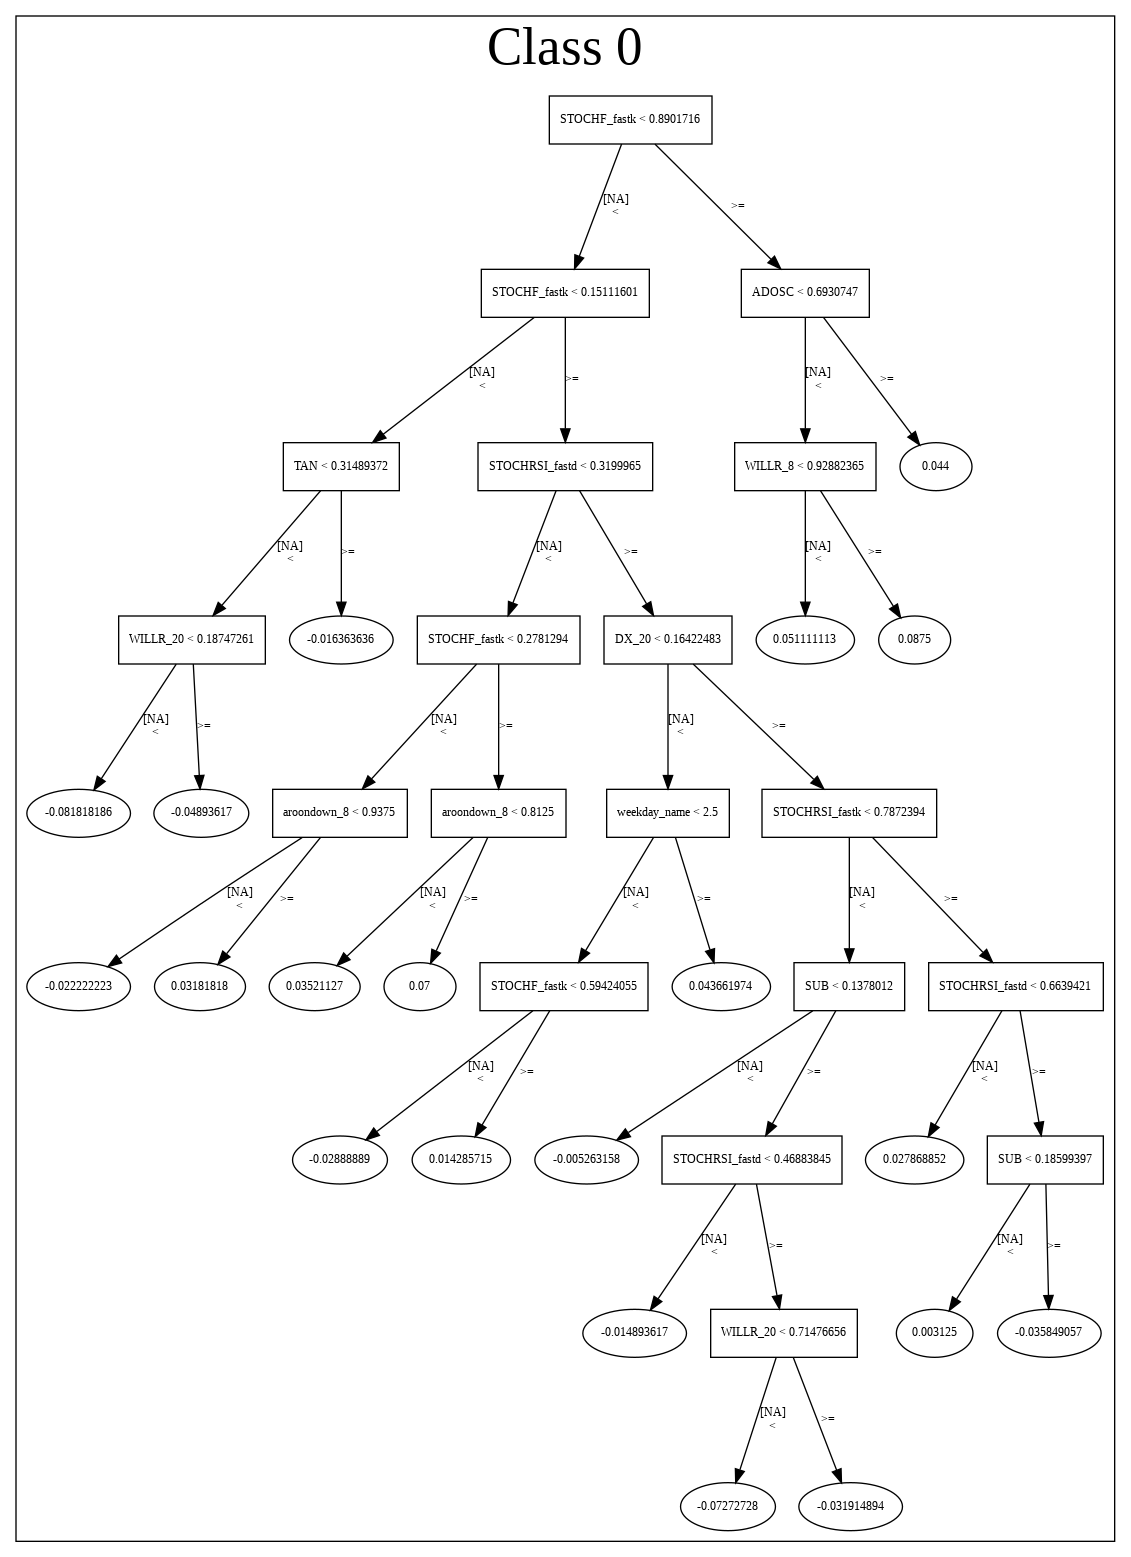

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_174336_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_174336_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_b872',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

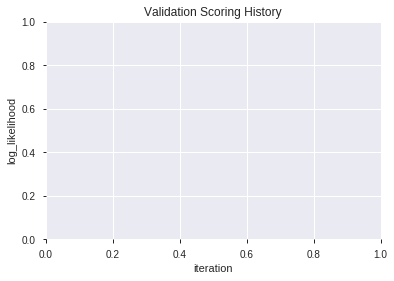

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190827_174502  0.735347  0.604084              0.317173  0.456773  0.208641
1               XGBoost_1_AutoML_20190827_174502  0.726882  0.608613              0.354239  0.459814  0.211428
2  XGBoost_grid_1_AutoML_20190827_174502_model_4  0.726241  0.617517              0.338111  0.463474  0.214808
3  XGBoost_grid_1_AutoML_20190827_174502_model_6  0.724253  0.619627              0.313133  0.464296  0.215571
4  XGBoost_grid_1_AutoML_20190827_174502_model_3  0.719828  0.618835              0.358247  0.464818  0.216056
5  XGBoost_grid_1_AutoML_20190827_174502_model_2  0.718481  0.620499              0.380820  0.465047  0.216269
6               XGBoost_3_AutoML_20190827_174502  0.717712  0.618128              0.363473  0.464332  0.215604
7  XGBoost_grid_1_AutoML_20190827_174502_model_1  0.710658  0.624073              0.353020  0.467338  0.218405
8  XGBoost_grid_1_AutoML_20190827_174502_model_7  0.708478  0.620399              0.348596  0.465633  0.216814
9  XGBoost_grid_1_AutoML_20190827_174502_model_5  0.682185  0.640689              0.383224  0.475824  0.226408

variable  relative_importance  scaled_importance  percentage
0                        BOP          1850.270630           1.000000    0.221053
1                        SUB           278.625183           0.150586    0.033288
2                        DIV           245.153366           0.132496    0.029289
3               STOCHF_fastk           223.794968           0.120953    0.026737
4                    WILLR_8           159.064728           0.085968    0.019004
..                       ...                  ...                ...         ...
264   BBANDS_lowerband_8_1_2             2.460928           0.001330    0.000294
265  BBANDS_lowerband_14_6_5             2.359227           0.001275    0.000282
266  BBANDS_upperband_20_0_3             1.917683           0.001036    0.000229
267               weekofyear             1.719044           0.000929    0.000205
268  BBANDS_upperband_14_1_3             1.287857           0.000696    0.000154

[269 rows x 4 columns]

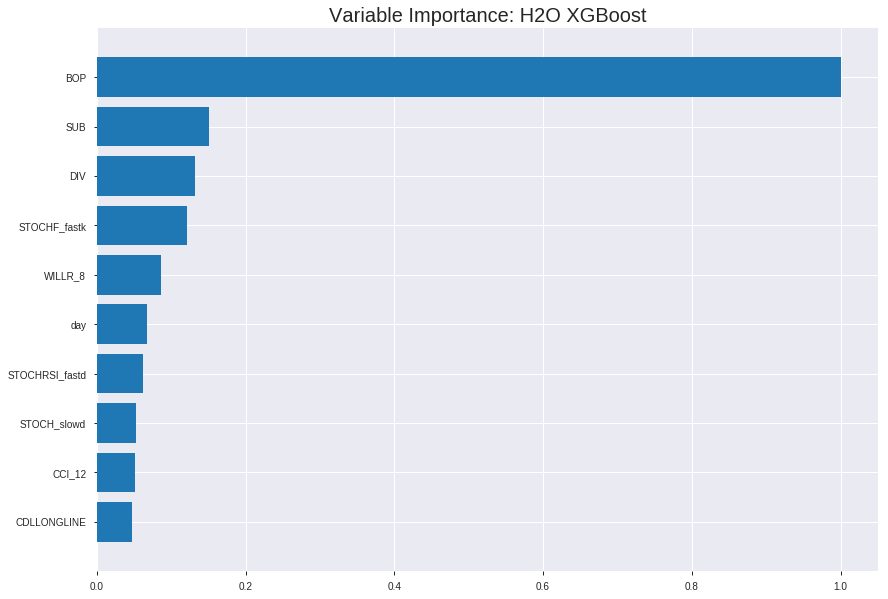

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190827_174502


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13205522973720393
RMSE: 0.36339404196712405
LogLoss: 0.429921108223134
Mean Per-Class Error: 0.14080295868005366
AUC: 0.9321600187521975
pr_auc: 0.9347218587335484
Gini: 0.8643200375043949
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5369969010353088: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      789  106  0.1184   (106.0/895.0)
1      140  718  0.1632   (140.0/858.0)
Total  929  824  0.1403   (246.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.536997     0.853746  170
max f2                       0.417015     0.892029  232
max f0point5                 0.608755     0.881254  135
max accuracy                 0.536997     0.859669  170
max precision                0.892096     1         0
max recall                   0.177111     1         343
max specificity              0.892096     1         0
max absolute_mcc             0.536997     0.719526  170
max min_per_class_accuracy   0.519159     0.851981  179
max mean_per_class_accuracy  0.536997     0.859197  170

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 48.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.866339           2.04312   2.04312            1                0.877758  1                           0.877758            0.020979        0.020979                   104.312   104.312
    2        0.0205362                   0.852176           2.04312   2.04312            1                0.858988  1                           0.868373            0.020979        0.041958                   104.312   104.312
    3        0.0302339                   0.843117           2.04312   2.04312            1                0.847119  1                           0.861555            0.0198135       0.0617716                  104.312   104.312
    4        0.040502                    0.832305           2.04312   2.04312            1                0.837452  1                           0.855445            0.020979        0.0827506                  104.312   104.312
    5        0.0501997                   0.822106           2.04312   2.04312            1                0.826279  1                           0.849811            0.0198135       0.102564                   104.312   104.312
    6        0.100399                    0.790999           2.04312   2.04312            1                0.805158  1                           0.827485            0.102564        0.205128                   104.312   104.312
    7        0.150029                    0.759937           2.01964   2.03536            0.988506         0.774614  0.996198                    0.809995            0.100233        0.305361                   101.964   103.536
    8        0.200228                    0.720989           1.99669   2.02566            0.977273         0.736883  0.991453                    0.791665            0.100233        0.405594                   99.6689   102.566
    9        0.300057                    0.652524           1.8213    1.95767            0.891429         0.686546  0.958175                    0.756692            0.181818        0.587413                   82.1299   95.767
    10       0.399886                    0.58833            1.64617   1.87991            0.805714         0.621422  0.920114                    0.722923            0.164336        0.751748                   64.6174   87.9907
    11       0.500285                    0.511894           1.068     1.71697            0.522727         0.551954  0.840365                    0.688612            0.107226        0.858974                   6.79964   71.6969
    12       0.600114                    0.437635           0.665475  1.54205            0.325714         0.475195  0.754753                    0.65311             0.0664336       0.925408                   -33.4525  54.2053
    13       0.699943                    0.337251           0.39695   1.37873            0.194286         0.3918    0.674817                    0.615841            0.039627        0.965035                   -60.305   37.8734
    14       0.799772                    0.243247           0.21015   1.23287            0.102857         0.291539  0.603424                    0.575361            0.020979        0.986014                   -78.985   23.2869
    15       0.899601                    0.142146           0.1401    1.1116             0.0685714        0.191713  0.544071                    0.532787            0.013986        1                          -85.99    11.1604
    16       1                           0.0513286          0         1                  0                0.105534  0.489447                    0.489891          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2065129215804961
RMSE: 0.4544369280554741
LogLoss: 0.596458672575382
Mean Per-Class Error: 0.31143762604436764
AUC: 0.743085566119274
pr_auc: 0.6962433161892289
Gini: 0.486171132238548
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4698692560195923: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      144  123  0.4607   (123.0/267.0)
1      41   193  0.1752   (41.0/234.0)
Total  185  316  0.3273   (164.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.469869     0.701818  242
max f2                       0.258959     0.83815   352
max f0point5                 0.530628     0.661417  199
max accuracy                 0.530628     0.686627  199
max precision                0.874522     1         0
max recall                   0.210357     1         364
max specificity              0.874522     1         0
max absolute_mcc             0.530628     0.376523  199
max min_per_class_accuracy   0.543827     0.674157  188
max mean_per_class_accuracy  0.530628     0.688562  199

Gains/Lift Table: Avg response rate: 46.71 %, avg score: 51.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.826549           2.14103   2.14103            1                0.842698  1                           0.842698            0.025641        0.025641                   114.103   114.103
    2        0.0219561                   0.818829           1.28462   1.75175            0.6              0.820991  0.818182                    0.832832            0.0128205       0.0384615                  28.4615   75.1748
    3        0.0319361                   0.787903           2.14103   1.8734             1                0.800052  0.875                       0.822588            0.0213675       0.0598291                  114.103   87.3397
    4        0.0419162                   0.783369           1.71282   1.83516            0.8              0.785437  0.857143                    0.813742            0.017094        0.0769231                  71.2821   83.5165
    5        0.0518962                   0.775531           1.71282   1.81164            0.8              0.778245  0.846154                    0.806916            0.017094        0.0940171                  71.2821   81.1637
    6        0.101796                    0.742333           1.54154   1.67924            0.72             0.759715  0.784314                    0.783778            0.0769231       0.17094                    54.1538   67.9236
    7        0.151697                    0.716414           1.54154   1.63394            0.72             0.728286  0.763158                    0.765524            0.0769231       0.247863                   54.1538   63.3941
    8        0.201597                    0.683007           1.54154   1.61107            0.72             0.69878   0.752475                    0.749004            0.0769231       0.324786                   54.1538   61.1069
    9        0.301397                    0.640036           1.37026   1.53133            0.64             0.663068  0.715232                    0.720548            0.136752        0.461538                   37.0256   53.133
    10       0.401198                    0.589306           1.07051   1.4167             0.5              0.613757  0.661692                    0.693983            0.106838        0.568376                   7.05128   41.6699
    11       0.500998                    0.538875           1.19897   1.37333            0.56             0.565173  0.641434                    0.668324            0.119658        0.688034                   19.8974   37.3327
    12       0.600798                    0.486875           1.02769   1.31591            0.48             0.513079  0.614618                    0.642535            0.102564        0.790598                   2.76923   31.5913
    13       0.700599                    0.422341           0.727949  1.23216            0.34             0.453542  0.575499                    0.615613            0.0726496       0.863248                   -27.2051  23.2157
    14       0.800399                    0.346912           0.685128  1.16395            0.32             0.384918  0.543641                    0.586848            0.0683761       0.931624                   -31.4872  16.3949
    15       0.9002                      0.246086           0.599487  1.10137            0.28             0.297522  0.514412                    0.554772            0.0598291       0.991453                   -40.0513  10.137
    16       1                           0.0540515          0.085641  1                  0.04             0.14748   0.467066                    0.514124           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:45:08  0.014 sec   0                  0.5              0.693147            0.5             0                  1                0.510553                         0.5                0.693147              0.5               0                    1                  0.532934
    2019-08-27 17:45:09  0.860 sec   5                  0.474428         0.642996            0.828419        0.819906           2.04312          0.272105                         0.485453           0.664309              0.716052          0.641075             1.42735            0.347305
    2019-08-27 17:45:10  1.453 sec   10                 0.454265         0.604163            0.845072        0.837968           1.92962          0.246435                         0.474023           0.641585              0.737684          0.68302              1.78419            0.383234
    2019-08-27 17:45:10  2.060 sec   15                 0.439377         0.575455            0.859457        0.856615           2.04312          0.228751                         0.46908            0.631256              0.735819          0.684431             1.78419            0.345309
    2019-08-27 17:45:11  2.645 sec   20                 0.426942         0.551414            0.87382         0.874022           2.04312          0.204221                         0.465407           0.623305              0.736115          0.678083             1.78419            0.333333
    2019-08-27 17:45:11  3.268 sec   25                 0.416598         0.531236            0.883757        0.88471            2.04312          0.195094                         0.461716           0.615142              0.742885          0.689585             2.14103            0.355289
    2019-08-27 17:45:12  3.904 sec   30                 0.407758         0.513811            0.891095        0.892781           2.04312          0.185967                         0.460003           0.610729              0.743158          0.695617             2.14103            0.327345
    2019-08-27 17:45:13  4.497 sec   35                 0.400103         0.498784            0.897192        0.899555           2.04312          0.180833                         0.459407           0.608939              0.739188          0.684912             1.78419            0.327345
    2019-08-27 17:45:13  5.102 sec   40                 0.392931         0.48465             0.903484        0.906359           2.04312          0.168283                         0.457422           0.604295              0.74291           0.690881             1.78419            0.331337
    2019-08-27 17:45:14  5.659 sec   45                 0.38614          0.471876            0.910238        0.912604           2.04312          0.169994                         0.457478           0.603906              0.740109          0.690548             1.78419            0.341317
    2019-08-27 17:45:14  6.286 sec   50                 0.379631         0.459863            0.917779        0.920491           2.04312          0.168853                         0.456471           0.601561              0.741333          0.690878             2.14103            0.337325
    2019-08-27 17:45:15  6.919 sec   55                 0.373861         0.449287            0.923742        0.926549           2.04312          0.152881                         0.455259           0.598878              0.743446          0

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      1850.2706298828125     1.0                    0.22105299006858917
SUB                      278.62518310546875     0.1505861783706287     0.03328752499182939
DIV                      245.1533660888672      0.13249595066230613    0.029288626065883033
STOCHF_fastk             223.7949676513672      0.120952559067287      0.026736924838271434
WILLR_8                  159.06472778320312     0.08596835793328111    0.019003562572438508
---                      ---                    ---                    ---
BBANDS_lowerband_8_1_2   2.460927963256836      0.0013300367651691578  0.0002940086038417963
BBANDS_lowerband_14_6_5  2.359227180480957      0.0012750714097593278  0.0002818583476782707
BBANDS_upperband_20_0_3  1.9176826477050781     0.0010364335988117237  0.00022910674602488008
weekofyear               1.7190437316894531     0.0009290769166012916  0.00020537523041842077
BBANDS_upperband_14_1_3  1.2878570556640625     0.0006960371282257392  0.00015386108839305366


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6972111553784861)

('F1', 0.697841726618705)

('auc', 0.7353469283057585)

('logloss', 0.6040843397808788)

('mean_per_class_error', 0.30421957163011415)

('rmse', 0.4567727200987956)

('mse', 0.20864131782645265)

xgboost prediction progress: |████████████████████████████████████████████| 100%


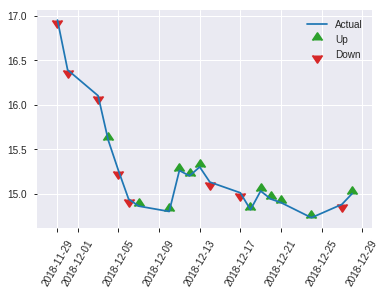


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20864131782645265
RMSE: 0.4567727200987956
LogLoss: 0.6040843397808788
Mean Per-Class Error: 0.30421957163011415
AUC: 0.7353469283057585
pr_auc: 0.6555226324774248
Gini: 0.4706938566115171
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40321680903434753: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      70   68   0.4928   (68.0/138.0)
1      16   97   0.1416   (16.0/113.0)
Total  86   165  0.3347   (84.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.403217     0.697842  164
max f2                       0.249465     0.823529  227
max f0point5                 0.526801     0.662651  116
max accuracy                 0.526801     0.697211  116
max precision                0.868306     1         0
max recall                   0.156804     1         243
max specificity              0.868306     1         0
max absolute_mcc             0.526801     0.39051   116
max min_per_class_accuracy   0.52225      0.690265  119
max mean_per_class_accuracy  0.526801     0.69578   116

Gains/Lift Table: Avg response rate: 45.02 %, avg score: 48.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.814917           2.22124   2.22124            1                0.843843  1                           0.843843            0.0265487       0.0265487                  122.124   122.124
    2        0.0239044                   0.762778           1.48083   1.85103            0.666667         0.777794  0.833333                    0.810818            0.0176991       0.0442478                  48.0826   85.1032
    3        0.0318725                   0.74949            2.22124   1.94358            1                0.753212  0.875                       0.796417            0.0176991       0.0619469                  122.124   94.3584
    4        0.0438247                   0.742366           2.22124   2.01931            1                0.744208  0.909091                    0.782178            0.0265487       0.0884956                  122.124   101.931
    5        0.0517928                   0.730298           1.11062   1.87951            0.5              0.735361  0.846154                    0.774975            0.00884956      0.0973451                  11.0619   87.951
    6        0.103586                    0.688534           1.19605   1.53778            0.538462         0.710668  0.692308                    0.742822            0.0619469       0.159292                   19.6052   53.7781
    7        0.151394                    0.648733           1.11062   1.40289            0.5              0.664888  0.631579                    0.718211            0.0530973       0.212389                   11.0619   40.2888
    8        0.203187                    0.632811           1.70865   1.48083            0.769231         0.641756  0.666667                    0.698723            0.0884956       0.300885                   70.8645   48.0826
    9        0.302789                    0.592789           1.68814   1.54902            0.76             0.611404  0.697368                    0.669999            0.168142        0.469027                   68.8142   54.9022
    10       0.40239                     0.561552           1.33274   1.49549            0.6              0.577572  0.673267                    0.647121            0.132743        0.60177                    33.2743   49.5488
    11       0.501992                    0.508302           0.977345  1.39268            0.44             0.534177  0.626984                    0.624712            0.0973451       0.699115                   -2.26549  39.2682
    12       0.601594                    0.443401           0.888496  1.30921            0.4              0.473727  0.589404                    0.599714            0.0884956       0.787611                   -11.1504  30.9207
    13       0.701195                    0.379984           0.977345  1.26207            0.44             0.408734  0.568182                    0.572586            0.0973451       0.884956                   -2.26549  26.2068
    14       0.800797                    0.307785           0.355398  1.1493             0.16             0.339544  0.517413                    0.543601            0.0353982       0.920354                   -64.4602  14.9298
    15       0.900398                    0.253326           0.621947  1.09096            0.28             0.276232  0.49115                     0.514025            0.0619469       0.982301                   -37.8053  9.09625
    16       1                           0.0650582          0.177699  1                  0.08             0.185511  0.450199                    0.481304          

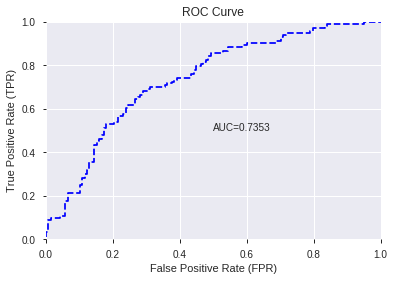

This function is available for GLM models only


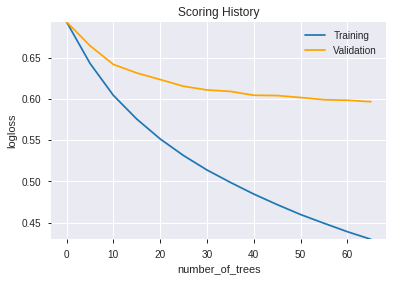

--2019-08-27 17:46:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.184.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.184.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


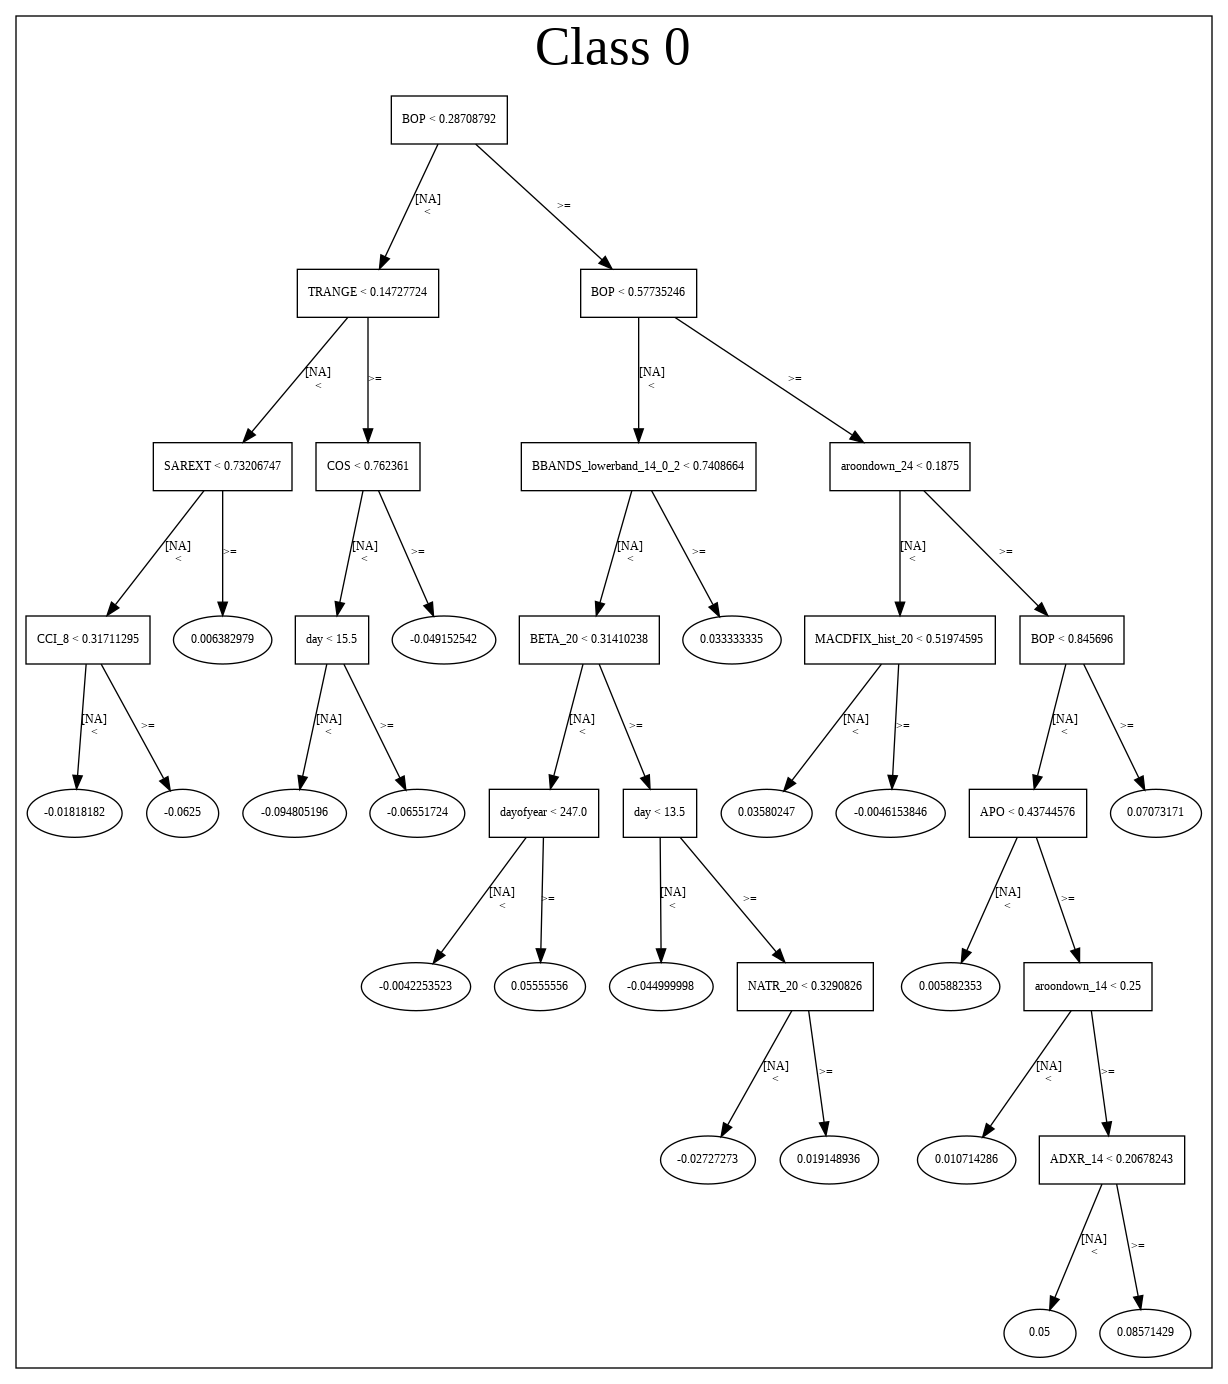

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190827_174502',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190827_174502',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_b872',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_b872',
   'type

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_174630_model_8  0.730666  0.622956              0.300628  0.465788  0.216959
1  DeepLearning_grid_1_AutoML_20190827_174630_model_9  0.720277  0.645363              0.295434  0.477433  0.227942
2  DeepLearning_grid_1_AutoML_20190827_174630_model_6  0.702129  0.657143              0.323201  0.484582  0.234820
3  DeepLearning_grid_1_AutoML_20190827_174630_model_2  0.662242  0.715902              0.416250  0.500384  0.250384
4  DeepLearning_grid_1_AutoML_20190827_174630_model_7  0.658266  0.756045              0.399320  0.502950  0.252959
5  DeepLearning_grid_1_AutoML_20190827_174630_model_3  0.658202  0.777069              0.382006  0.520281  0.270692
6               DeepLearning_1_AutoML_20190827_174630  0.655316  0.676813              0.380820  0.486761  0.236936
7  DeepLearning_grid_1_AutoML_20190827_174630_model_5  0.651789  0.700073              0.381204  0.503014  0.253024
8  DeepLearning_grid_1_AutoML_20190827_174630_model_1  0.643324  1.089980              0.371938  0.562999  0.316968
9  DeepLearning_grid_1_AutoML_20190827_174630_model_4  0.577017  0.955502              0.441997  0.568728  0.323451

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.038798
1                    DIV             0.655756           0.655756    0.025442
2                    day             0.625523           0.625523    0.024269
3         STOCHRSI_fastd             0.606654           0.606654    0.023537
4                    SUB             0.602167           0.602167    0.023363
5     CDLCLOSINGMARUBOZU             0.592286           0.592286    0.022980
6                 TRANGE             0.572416           0.572416    0.022209
7   HT_PHASOR_quadrature             0.565980           0.565980    0.021959
8           aroondown_30             0.556958           0.556958    0.021609
9                ADXR_14             0.551564           0.551564    0.021400
10           AROONOSC_14             0.551080           0.551080    0.021381
11           CDLHIGHWAVE             0.549189           0.549189    0.021308
12          STOCHF_fastk             0.544220           0.544220    0.021115
13          CDLENGULFING             0.540217           0.540217    0.020959
14                BETA_8             0.530736           0.530736    0.020592
15                ULTOSC             0.523965           0.523965    0.020329
16          weekday_name             0.510228           0.510228    0.019796
17                 month             0.508026           0.508026    0.019711
18            AROONOSC_8             0.505074           0.505074    0.019596
19             CDLHAMMER             0.503494           0.503494    0.019535
20             aroonup_8             0.501651           0.501651    0.019463
21           CDLLONGLINE             0.501597           0.501597    0.019461
22              WILLR_14             0.498265           0.498265    0.019332
23          aroondown_14             0.497258           0.497258    0.019293
24           HT_DCPERIOD             0.495800           0.495800    0.019236
25     CDLINVERTEDHAMMER             0.492680           0.492680    0.019115
26               BETA_14             0.492670           0.492670    0.019115
27             dayofweek             0.486645           0.486645    0.018881
28                   SIN             0.486410           0.486410    0.018872
29                Volume             0.486342           0.486342    0.018869
30           aroondown_8             0.486148           0.486148    0.018862
31           STOCH_slowd             0.484531           0.484531    0.018799
32         days_in_month             0.477191           0.477191    0.018514
33            weekofyear             0.475071           0.475071    0.018432
34             dayofyear             0.472155           0.472155    0.018319
35        STOCHRSI_fastk             0.471109           0.471109    0.018278
36           CDLMARUBOZU             0.468738           0.468738    0.018186
37               WILLR_8             0.467564           0.467564    0.018141
38               weekday             0.467241           0.467241    0.018128
39               quarter             0.465100           0.465100    0.018045
40     HT_PHASOR_inphase             0.459679           0.459679    0.017835
41          STOCHF_fastd             0.459616           0.459616    0.017832
42               BETA_12             0.456705           0.456705    0.017719
43              WILLR_30             0.452704           0.452704    0.017564
44                  week             0.450007           0.450007    0.017459
45              WILLR_12             0.449901           0.449901    0.017455
46              WILLR_24             0.446621           0.446621    0.017328
47            CDLHIKKAKE             0.445299           0.445299    0.017277
48           CDLBELTHOLD             0.444164           0.444164    0.017233
49              WILLR_20             0.439983           0.439983    0.017071

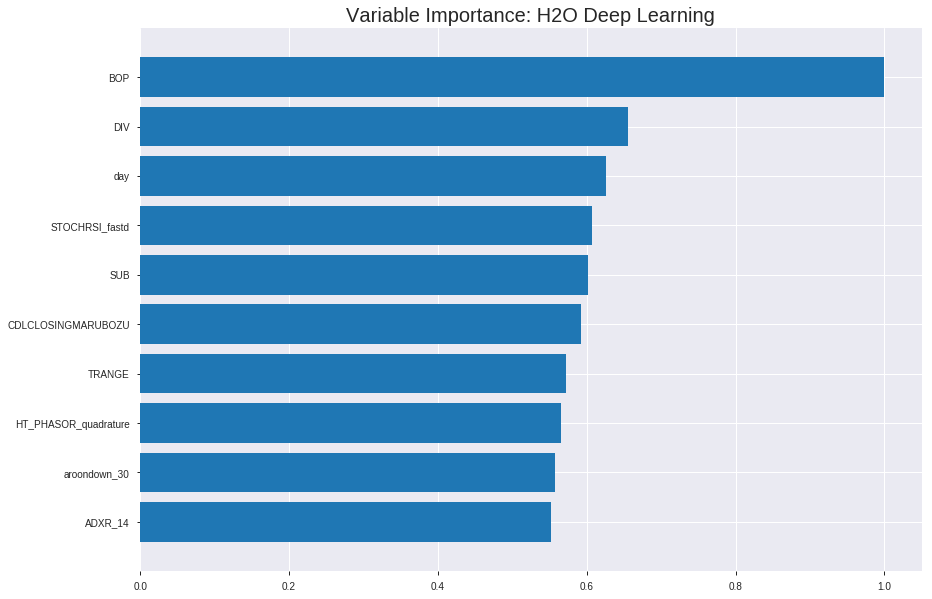

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_174630_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19316024519999048
RMSE: 0.43949999453923827
LogLoss: 0.5639311856535371
Mean Per-Class Error: 0.2944583349611283
AUC: 0.7790580927452435
pr_auc: 0.7446783119730176
Gini: 0.558116185490487
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.341591876567775: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      397  498   0.5564   (498.0/895.0)
1      62   796   0.0723   (62.0/858.0)
Total  459  1294  0.3195   (560.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.341592     0.739777  255
max f2                       0.194563     0.854129  317
max f0point5                 0.549487     0.703083  135
max accuracy                 0.44736      0.702795  202
max precision                0.799639     1         0
max recall                   0.060356     1         371
max specificity              0.799639     1         0
max absolute_mcc             0.44736      0.424649  202
max min_per_class_accuracy   0.516827     0.69697   159
max mean_per_class_accuracy  0.44736      0.705542  202

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 45.83 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.7569             1.92962    1.92962            0.944444         0.777108   0.944444                    0.777108            0.0198135       0.0198135                  92.9617    92.9617
    2        0.0205362                   0.74195            1.81611    1.87286            0.888889         0.747351   0.916667                    0.762229            0.018648        0.0384615                  81.611     87.2863
    3        0.0302339                   0.73164            1.80276    1.85038            0.882353         0.736342   0.90566                     0.753926            0.0174825       0.0559441                  80.2756    85.0376
    4        0.040502                    0.721166           1.5891     1.78414            0.777778         0.7262     0.873239                    0.746897            0.016317        0.0722611                  58.9096    78.4136
    5        0.0501997                   0.712246           1.4422     1.71808            0.705882         0.716335   0.840909                    0.740993            0.013986        0.0862471                  44.2205    71.8081
    6        0.100399                    0.68236            1.62521    1.67165            0.795455         0.696916   0.818182                    0.718954            0.0815851       0.167832                   62.5212    67.1647
    7        0.150029                    0.65159            1.62041    1.6547             0.793103         0.667226   0.809886                    0.701843            0.0804196       0.248252                   62.0408    65.4697
    8        0.200228                    0.630561           1.53234    1.62402            0.75             0.639395   0.794872                    0.686186            0.0769231       0.325175                   53.2343    62.4021
    9        0.300057                    0.587032           1.47105    1.57313            0.72             0.608502   0.769962                    0.660341            0.146853        0.472028                   47.1049    57.3127
    10       0.399886                    0.552572           1.27257    1.4981             0.622857         0.569847   0.733238                    0.63775             0.12704         0.599068                   27.2574    49.8096
    11       0.500285                    0.513895           0.998344   1.3978             0.488636         0.535098   0.684151                    0.617149            0.100233        0.699301                   -0.165554  39.7804
    12       0.600114                    0.464168           1.0741     1.34396            0.525714         0.489919   0.657795                    0.595984            0.107226        0.806527                   7.40992    34.3956
    13       0.699943                    0.380563           0.875624   1.27716            0.428571         0.42539    0.625102                    0.571654            0.0874126       0.893939                   -12.4376   27.716
    14       0.799772                    0.262856           0.63045    1.19644            0.308571         0.325623   0.585592                    0.540944            0.0629371       0.956876                   -36.955    19.6437
    15       0.899601                    0.127007           0.3736     1.10513            0.182857         0.19492    0.5409                      0.502545            0.037296        0.994172                   -62.64     10.5126
    16       1                           0.0038955          0.0580433  1                  0.0284091        0.06



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2122947372088912
RMSE: 0.46075453031835856
LogLoss: 0.6078273949775833
Mean Per-Class Error: 0.3314846826082781
AUC: 0.721862095457601
pr_auc: 0.6827650736674815
Gini: 0.4437241909152021
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4518607952441174: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      127  140  0.5243   (140.0/267.0)
1      35   199  0.1496   (35.0/234.0)
Total  162  339  0.3493   (175.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.451861     0.69459   258
max f2                       0.184031     0.832138  360
max f0point5                 0.530587     0.641838  194
max accuracy                 0.530587     0.666667  194
max precision                0.830055     1         0
max recall                   0.116603     1         375
max specificity              0.830055     1         0
max absolute_mcc             0.451861     0.347804  258
max min_per_class_accuracy   0.537388     0.651685  187
max mean_per_class_accuracy  0.529585     0.668515  196

Gains/Lift Table: Avg response rate: 46.71 %, avg score: 48.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.751463           2.14103   2.14103            1                0.77296   1                           0.77296             0.025641        0.025641                   114.103   114.103
    2        0.0219561                   0.740718           1.71282   1.94639            0.8              0.743086  0.909091                    0.759381            0.017094        0.042735                   71.2821   94.6387
    3        0.0319361                   0.722934           2.14103   2.00721            1                0.728012  0.9375                      0.749578            0.0213675       0.0641026                  114.103   100.721
    4        0.0419162                   0.716448           1.28462   1.83516            0.6              0.720061  0.857143                    0.74255             0.0128205       0.0769231                  28.4615   83.5165
    5        0.0518962                   0.70216            2.14103   1.89398            1                0.709979  0.884615                    0.736287            0.0213675       0.0982906                  114.103   89.3984
    6        0.101796                    0.659421           1.62718   1.7632             0.76             0.676863  0.823529                    0.707157            0.0811966       0.179487                   62.7179   76.3198
    7        0.151697                    0.635802           1.54154   1.69028            0.72             0.646587  0.789474                    0.687233            0.0769231       0.25641                    54.1538   69.0283
    8        0.201597                    0.621849           1.02769   1.52628            0.48             0.62921   0.712871                    0.672871            0.0512821       0.307692                   2.76923   52.6276
    9        0.301397                    0.5931             1.24179   1.43208            0.58             0.60537   0.668874                    0.650519            0.123932        0.431624                   24.1795   43.2077
    10       0.401198                    0.560969           1.19897   1.37409            0.56             0.576434  0.641791                    0.63209             0.119658        0.551282                   19.8974   37.4091
    11       0.500998                    0.534401           1.19897   1.33921            0.56             0.547126  0.625498                    0.615165            0.119658        0.67094                    19.8974   33.9207
    12       0.600798                    0.494846           0.899231  1.26612            0.42             0.516572  0.591362                    0.598787            0.0897436       0.760684                   -10.0769  26.6121
    13       0.700599                    0.435581           0.942051  1.21996            0.44             0.464259  0.569801                    0.579624            0.0940171       0.854701                   -5.79487  21.9958
    14       0.800399                    0.360447           0.685128  1.15327            0.32             0.398903  0.538653                    0.55709             0.0683761       0.923077                   -31.4872  15.3271
    15       0.9002                      0.213888           0.599487  1.09188            0.28             0.292678  0.509978                    0.527776            0.0598291       0.982906                   -40.0513  9.18756
    16       1                           0.00479028         0.171282  1                  0.08             0.105297  0.467066                    0.485613         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:51:54  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 17:51:55  1 min  5.693 sec  670 obs/sec       0.557901  1             978        0.556563         0.966929            -0.239603      0.726254        0.67554            1.36208          0.350257                         0.607144           1.20828               -0.480921        0.702495          0.627863             2.14103            0.39521
    2019-08-27 17:52:05  1 min 14.998 sec  1125 obs/sec      6.33828   11            11111      0.4395           0.563931            0.227015       0.779058        0.744678           1.92962          0.319452                         0.460755           0.607827              0.147121         0.721862          0.682765             2.14103            0.349301
    2019-08-27 17:52:14  1 min 24.269 sec  1271 obs/sec      13.2259   23            23185      0.446314         0.575156            0.20286        0.792591        0.760837           2.04312          0.304621                         0.505552           0.705107              -0.026788        0.710658          0.657068             1.78419            0.331337
    2019-08-27 17:52:23  1 min 33.602 sec  1358 obs/sec      20.6777   36            36248      0.424339         0.526368            0.279423       0.809962        0.787281           2.04312          0.296634                         0.468179           0.620824              0.119413         0.715108          0.673625             2.14103            0.325349
    2019-08-27 17:52:33  1 min 42.931 sec  1405 obs/sec      28.1843   49            49407      0.41616          0.510521            0.306936       0.820421        0.789012           1.92962          0.283514                         0.476694           0.665208              0.0870915        0.708241          0.652788             2.14103            0.39521
    2019-08-27 17:52:41  1 min 51.799 sec  1447 obs/sec      35.6292   62            62458      0.411044         0.495845            0.323871       0.843322        0.834945           2.04312          0.280091                         0.479818           0.65407               0.0750842        0.70444           0.653789             2.14103            0.377246
    2019-08-27 17:52:50  2 min  0.488 sec  1483 obs/sec      43.1061   75            75565      0.405479         0.481185            0.342055       0.863095        0.847676           2.04312          0.262407                         0.497764           0.717838              0.00460425       0.698558          0.636713             2.14103            0.345309
    2019-08-27 17:52:51  2 min  1.406 sec  1482 obs/sec      43.1061   75            75565      0.4395           0.563931            0.227015       0.779058        0.744678           1.92962          0.319452                         0.460755           0.607827              0.147121         0.721862          0.682765             2.14103            0.349301

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  --------------------
BOP             1.0                    1.0                  0.038798220956233455
DIV             0.655756413936615      0.655756413936615    0.025442182241380073
day             0.6255226135253906     0.6255226135253906   0.02426916457267873
STOCHRSI_fastd  0.6066538095474243     0.6066538095474243   0.023537088546761734
SUB             0.6021673083305359     0.6021673083305359   0.023363020281228487
---             ---                    ---                  ---
WILLR_12        0.4499010741710663     0.4499010741710663   0.017455361284135804
WILLR_24        0.4466211199760437     0.4466211199760437   0.017328104896550994
CDLHIKKAKE      0.4452987611293793     0.4452987611293793   0.017276799725834676
CDLBELTHOLD     0.4441642165184021     0.4441642165184021   0.01723278141333328
WILLR_20        0.43998345732688904    0.43998345732688904  0.017070575394456153


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7051792828685259)

('F1', 0.6907630522088354)

('auc', 0.7306656406310119)

('logloss', 0.6229555276612864)

('mean_per_class_error', 0.2945684237527254)

('rmse', 0.4657883618670272)

('mse', 0.2169587980507687)

deeplearning prediction progress: |███████████████████████████████████████| 100%


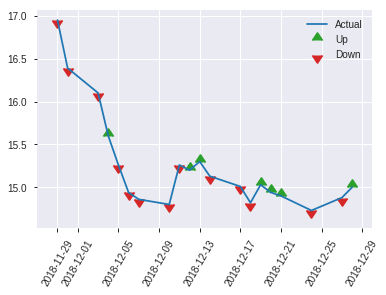


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2169587980507687
RMSE: 0.4657883618670272
LogLoss: 0.6229555276612864
Mean Per-Class Error: 0.2945684237527254
AUC: 0.7306656406310119
pr_auc: 0.638811495385189
Gini: 0.46133128126202383
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5109478651658974: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      88   50   0.3623   (50.0/138.0)
1      27   86   0.2389   (27.0/113.0)
Total  115  136  0.3068   (77.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.510948     0.690763  135
max f2                       0.165966     0.81295   242
max f0point5                 0.547922     0.67325   110
max accuracy                 0.547922     0.705179  110
max precision                0.741689     1         0
max recall                   0.165966     1         242
max specificity              0.741689     1         0
max absolute_mcc             0.538817     0.409083  120
max min_per_class_accuracy   0.538817     0.702899  120
max mean_per_class_accuracy  0.538817     0.705432  120

Gains/Lift Table: Avg response rate: 45.02 %, avg score: 49.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.733011           1.48083   1.48083            0.666667         0.737201  0.666667                    0.737201            0.0176991       0.0176991                  48.0826   48.0826
    2        0.0239044                   0.717159           1.48083   1.48083            0.666667         0.723651  0.666667                    0.730426            0.0176991       0.0353982                  48.0826   48.0826
    3        0.0318725                   0.708547           1.11062   1.38827            0.5              0.709481  0.625                       0.72519             0.00884956      0.0442478                  11.0619   38.8274
    4        0.0438247                   0.698006           1.48083   1.41352            0.666667         0.704194  0.636364                    0.719464            0.0176991       0.0619469                  48.0826   41.3516
    5        0.0517928                   0.689692           2.22124   1.53778            1                0.692719  0.692308                    0.715349            0.0176991       0.079646                   122.124   53.7781
    6        0.103586                    0.651329           1.19605   1.36692            0.538462         0.672178  0.615385                    0.693763            0.0619469       0.141593                   19.6052   36.6916
    7        0.151394                    0.635977           2.03614   1.57825            0.916667         0.645055  0.710526                    0.678382            0.0973451       0.238938                   103.614   57.8249
    8        0.203187                    0.619783           1.53778   1.56793            0.692308         0.627393  0.705882                    0.665385            0.079646        0.318584                   53.7781   56.7933
    9        0.302789                    0.591341           1.42159   1.5198             0.64             0.605479  0.684211                    0.645679            0.141593        0.460177                   42.1593   51.9795
    10       0.40239                     0.559555           1.42159   1.49549            0.64             0.571033  0.673267                    0.627202            0.141593        0.60177                    42.1593   49.5488
    11       0.501992                    0.529991           1.15504   1.42794            0.52             0.545674  0.642857                    0.611026            0.115044        0.716814                   15.5044   42.7939
    12       0.601594                    0.498216           0.799646  1.32392            0.36             0.510511  0.596026                    0.594384            0.079646        0.79646                    -20.0354  32.3917
    13       0.701195                    0.448803           0.533097  1.21158            0.24             0.474509  0.545455                    0.577357            0.0530973       0.849558                   -46.6903  21.1585
    14       0.800797                    0.365737           0.799646  1.16035            0.36             0.411068  0.522388                    0.556674            0.079646        0.929204                   -20.0354  16.0349
    15       0.900398                    0.291686           0.266549  1.06148            0.12             0.334495  0.477876                    0.532097            0.0265487       0.955752                   -73.3451  6.1477
    16       1                           0.0154411          0.444248  1                  0.2              0.178145  0.450199                    0.496842          

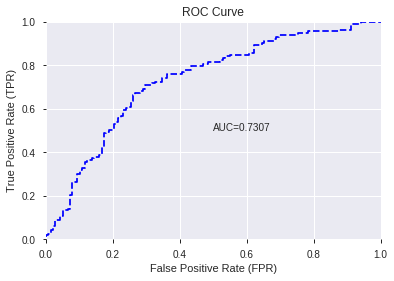

This function is available for GLM models only


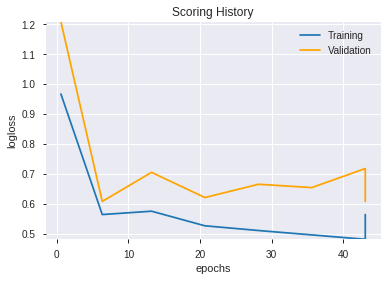

--2019-08-27 17:54:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.176.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.176.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


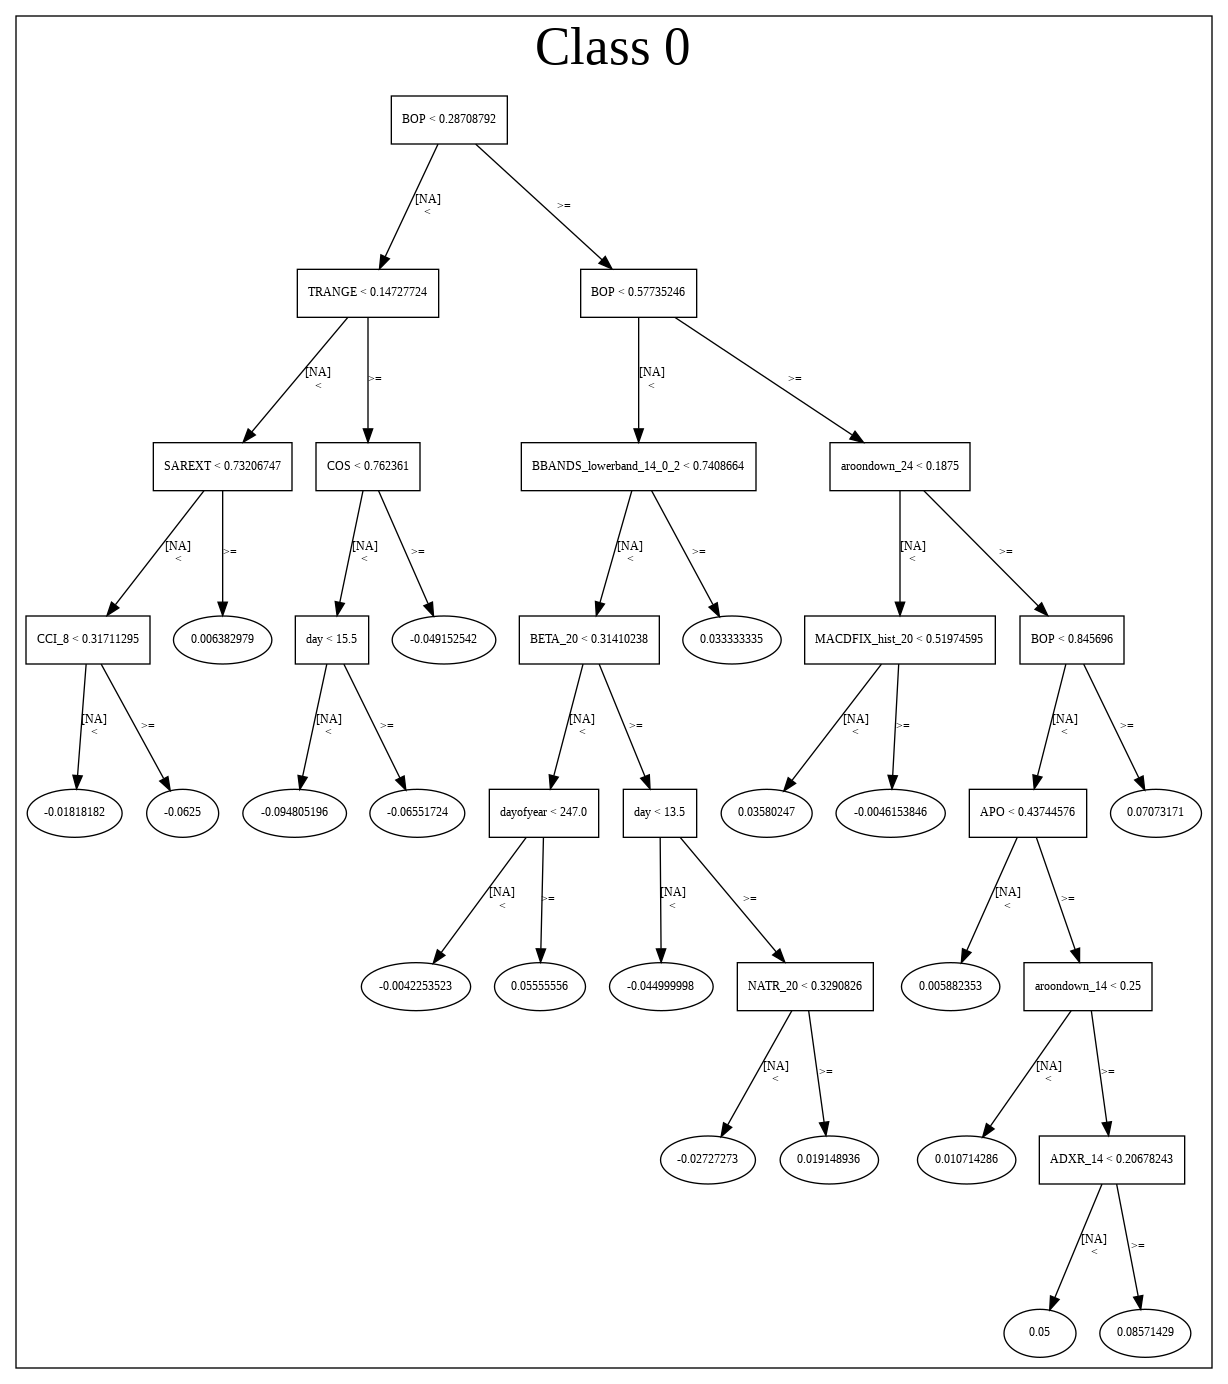

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_174630_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_174630_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_b872',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'DIV',
 'day',
 'STOCHRSI_fastd',
 'SUB',
 'CDLCLOSINGMARUBOZU',
 'TRANGE',
 'HT_PHASOR_quadrature',
 'aroondown_30',
 'ADXR_14',
 'AROONOSC_14',
 'CDLHIGHWAVE',
 'STOCHF_fastk',
 'CDLENGULFING',
 'BETA_8',
 'ULTOSC',
 'weekday_name',
 'month',
 'AROONOSC_8',
 'CDLHAMMER',
 'aroonup_8',
 'CDLLONGLINE',
 'WILLR_14',
 'aroondown_14',
 'HT_DCPERIOD',
 'CDLINVERTEDHAMMER',
 'BETA_14',
 'dayofweek',
 'SIN',
 'Volume',
 'aroondown_8',
 'STOCH_slowd',
 'days_in_month',
 'weekofyear',
 'dayofyear',
 'STOCHRSI_fastk',
 'CDLMARUBOZU',
 'WILLR_8',
 'weekday',
 'quarter',
 'HT_PHASOR_inphase',
 'STOCHF_fastd',
 'BETA_12',
 'WILLR_30',
 'week',
 'WILLR_12',
 'WILLR_24',
 'CDLHIKKAKE',
 'CDLBELTHOLD',
 'WILLR_20']

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_175421_model_1  0.74099  0.612447              0.297037  0.460538  0.212096

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.425545           1.000000    0.122280
1     CDLCLOSINGMARUBOZU             0.173750           0.408299    0.049927
2                    DIV             0.154815           0.363804    0.044486
3            STOCH_slowd             0.133932           0.314730    0.038485
4              CDLHAMMER             0.130461           0.306575    0.037488
5           aroondown_30             0.125057           0.293875    0.035935
6                    day             0.111804           0.262730    0.032127
7                    SUB             0.108786           0.255640    0.031260
8            CDLLONGLINE             0.108247           0.254372    0.031104
9      CDLINVERTEDHAMMER             0.105805           0.248634    0.030403
10                ULTOSC             0.103728           0.243753    0.029806
11          STOCHF_fastk             0.103236           0.242596    0.029665
12          CDLENGULFING             0.100001           0.234995    0.028735
13           CDLHIGHWAVE             0.099294           0.233334    0.028532
14               WILLR_8             0.090267           0.212121    0.025938
15  HT_PHASOR_quadrature             0.086427           0.203097    0.024835
16        STOCHRSI_fastd             0.086232           0.202640    0.024779
17              WILLR_14             0.081612           0.191782    0.023451
18             aroonup_8             0.081455           0.191413    0.023406
19           AROONOSC_14             0.077126           0.181240    0.022162
20          weekday_name             0.075384           0.177148    0.021662
21          aroondown_14             0.072178           0.169613    0.020740
22            AROONOSC_8             0.066054           0.155222    0.018980
23              WILLR_12             0.058967           0.138569    0.016944
24              WILLR_24             0.053985           0.126860    0.015512
25               ADXR_14             0.051824           0.121784    0.014892
26                TRANGE             0.051365           0.120705    0.014760
27          STOCHF_fastd             0.048764           0.114591    0.014012
28     HT_PHASOR_inphase             0.048169           0.113194    0.013841
29             dayofweek             0.047605           0.111869    0.013679
30               weekday             0.047476           0.111565    0.013642
31            CDLHIKKAKE             0.046195           0.108556    0.013274
32              WILLR_20             0.037506           0.088136    0.010777
33                  week             0.035411           0.083214    0.010175
34            weekofyear             0.035408           0.083205    0.010174
35               BETA_12             0.034059           0.080036    0.009787
36           aroondown_8             0.033607           0.078973    0.009657
37               quarter             0.033451           0.078608    0.009612
38              WILLR_30             0.026073           0.061269    0.007492
39           CDLMARUBOZU             0.022927           0.053876    0.006588
40         days_in_month             0.015486           0.036390    0.004450
41           HT_DCPERIOD             0.011674           0.027433    0.003354
42                BETA_8             0.009694           0.022780    0.002786
43                Volume             0.006931           0.016288    0.001992
44             dayofyear             0.005405           0.012701    0.001553
45                   SIN             0.004526           0.010636    0.001301
46           CDLBELTHOLD             0.003874           0.009103    0.001113
47                 month             0.003798           0.008925    0.001091
48               BETA_14             0.002958           0.006952    0.000850
49        STOCHRSI_fastk             0.001767           0.004152    0.000508

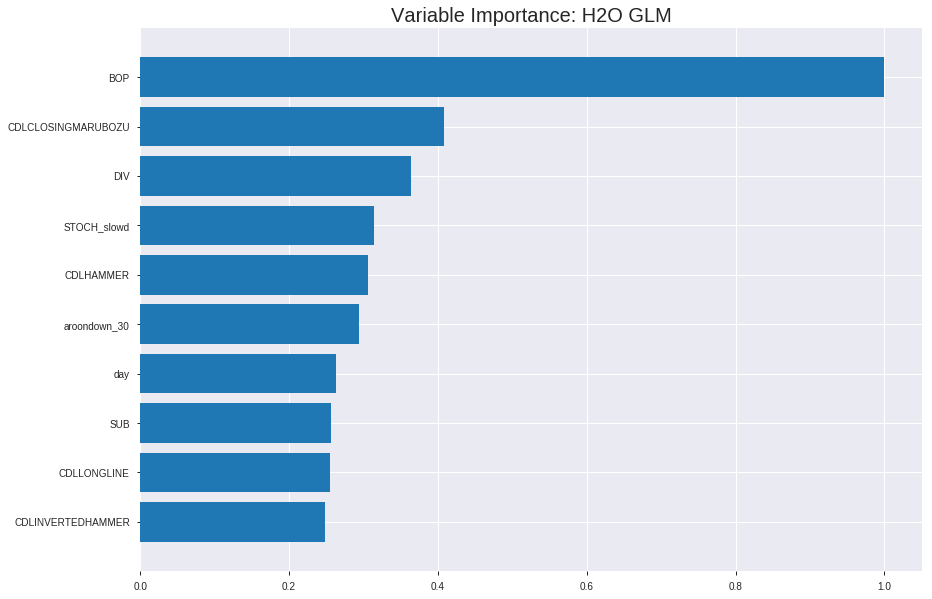

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_175421_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19614328947321377
RMSE: 0.44288067182167
LogLoss: 0.5753981334896189
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2429.39301010051
Residual deviance: 2017.3458560146037
AIC: 2119.3458560146037
AUC: 0.7689566485655871
pr_auc: 0.7217086658252645
Gini: 0.5379132971311742
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37117700374304835: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      434  461   0.5151   (461.0/895.0)
1      84   774   0.0979   (84.0/858.0)
Total  518  1235  0.3109   (545.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.371177     0.739608  267
max f2                       0.225524     0.848448  335
max f0point5                 0.568442     0.693451  158
max accuracy                 0.467558     0.700513  216
max precision                0.784904     0.851852  39
max recall                   0.128762     1         377
max specificity              0.907733     0.998883  0
max absolute_mcc             0.371177     0.424017  267
max min_per_class_accuracy   0.509184     0.689385  191
max mean_per_class_accuracy  0.467558     0.702127  216

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 48.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.861323           1.36208   1.36208            0.666667         0.876008  0.666667                    0.876008            0.013986        0.013986                   36.2082    36.2082
    2        0.0205362                   0.837296           1.92962   1.64585            0.944444         0.847413  0.805556                    0.861711            0.0198135       0.0337995                  92.9617    64.585
    3        0.0302339                   0.818576           1.56239   1.61908            0.764706         0.828731  0.792453                    0.851132            0.0151515       0.048951                   56.2389    61.9079
    4        0.040502                    0.810005           1.7026    1.64025            0.833333         0.812873  0.802817                    0.841433            0.0174825       0.0664336                  70.2603    64.0254
    5        0.0501997                   0.795433           2.04312   1.71808            1                0.802672  0.840909                    0.833945            0.0198135       0.0862471                  104.312    71.8081
    6        0.100399                    0.746961           1.55556   1.63682            0.761364         0.770324  0.801136                    0.802134            0.0780886       0.164336                   55.556     63.6821
    7        0.150029                    0.7059             1.62041   1.63139            0.793103         0.726343  0.798479                    0.777062            0.0804196       0.244755                   62.0408    63.1391
    8        0.200228                    0.676797           1.41626   1.57745            0.693182         0.691251  0.77208                     0.755548            0.0710956       0.315851                   41.6256    57.7454
    9        0.300057                    0.618663           1.48272   1.54594            0.725714         0.647478  0.756654                    0.719594            0.148019        0.463869                   48.2724    54.5938
    10       0.399886                    0.564471           1.27257   1.47769            0.622857         0.592043  0.723252                    0.687752            0.12704         0.590909                   27.2574    47.7694
    11       0.500285                    0.506926           1.02156   1.38616            0.5              0.536307  0.678449                    0.657359            0.102564        0.693473                   2.15618    38.6156
    12       0.600114                    0.449533           1.03907   1.32842            0.508571         0.477145  0.65019                     0.62738             0.10373         0.797203                   3.90743    32.8419
    13       0.699943                    0.373368           0.992374  1.28049            0.485714         0.412767  0.626732                    0.596771            0.0990676       0.89627                    -0.762571  28.0491
    14       0.799772                    0.296017           0.467     1.17895            0.228571         0.335705  0.577033                    0.564185            0.04662         0.94289                    -53.3      17.8949
    15       0.899601                    0.198489           0.431975  1.09606            0.211429         0.24563   0.536462                    0.528835            0.0431235       0.986014                   -56.8025   9.60574
    16       1                           0.0450784          0.139304  1                  0.0681818        0.136523  0.489447                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21486291218270065
RMSE: 0.4635330756080958
LogLoss: 0.6173538054465414
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 693.3634685719368
Residual deviance: 618.5885130574344
AIC: 720.5885130574344
AUC: 0.7184128813342296
pr_auc: 0.6670350539674811
Gini: 0.4368257626684593
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43723261596711005: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      130  137  0.5131   (137.0/267.0)
1      36   198  0.1538   (36.0/234.0)
Total  166  335  0.3453   (173.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.437233     0.695958  254
max f2                       0.272474     0.826087  346
max f0point5                 0.554514     0.642978  180
max accuracy                 0.554514     0.666667  180
max precision                0.888289     1         0
max recall                   0.146484     1         386
max specificity              0.888289     1         0
max absolute_mcc             0.456012     0.357145  245
max min_per_class_accuracy   0.542908     0.662921  187
max mean_per_class_accuracy  0.462841     0.672165  240

Gains/Lift Table: Avg response rate: 46.71 %, avg score: 51.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.847576           2.14103   2.14103            1                0.862296  1                           0.862296            0.025641        0.025641                   114.103   114.103
    2        0.0219561                   0.827291           1.71282   1.94639            0.8              0.832308  0.909091                    0.848665            0.017094        0.042735                   71.2821   94.6387
    3        0.0319361                   0.802112           1.71282   1.8734             0.8              0.813656  0.875                       0.837725            0.017094        0.0598291                  71.2821   87.3397
    4        0.0419162                   0.792403           1.28462   1.73321            0.6              0.794867  0.809524                    0.82752             0.0128205       0.0726496                  28.4615   73.3211
    5        0.0518962                   0.780049           1.28462   1.64694            0.6              0.787374  0.769231                    0.8198              0.0128205       0.0854701                  28.4615   64.6943
    6        0.101796                    0.731725           1.54154   1.59527            0.72             0.746954  0.745098                    0.784091            0.0769231       0.162393                   54.1538   59.5274
    7        0.151697                    0.706112           1.54154   1.5776             0.72             0.716261  0.736842                    0.761778            0.0769231       0.239316                   54.1538   57.7598
    8        0.201597                    0.676013           1.37026   1.52628            0.64             0.691141  0.712871                    0.744294            0.0683761       0.307692                   37.0256   52.6276
    9        0.301397                    0.639246           1.24179   1.43208            0.58             0.65856   0.668874                    0.715905            0.123932        0.431624                   24.1795   43.2077
    10       0.401198                    0.589              1.19897   1.37409            0.56             0.61494   0.641791                    0.690789            0.119658        0.551282                   19.8974   37.4091
    11       0.500998                    0.540352           1.19897   1.33921            0.56             0.564354  0.625498                    0.665603            0.119658        0.67094                    19.8974   33.9207
    12       0.600798                    0.477502           0.984872  1.28035            0.46             0.51694   0.598007                    0.640908            0.0982906       0.769231                   -1.51282  28.0348
    13       0.700599                    0.421827           0.85641   1.21996            0.4              0.449868  0.569801                    0.613695            0.0854701       0.854701                   -14.359   21.9958
    14       0.800399                    0.345863           0.642308  1.14793            0.3              0.384728  0.53616                     0.585145            0.0641026       0.918803                   -35.7692  14.7931
    15       0.9002                      0.256245           0.556667  1.08238            0.26             0.305524  0.505543                    0.554145            0.0555556       0.974359                   -44.3333  8.2381
    16       1                           0.0246059          0.256923  1                  0.12             0.177436  0.467066                    0.516549          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 17:54:21  0.000 sec   2            20        51            1.36753           1.37123
    2019-08-27 17:54:21  0.012 sec   4            12        51            1.35822           1.36468
    2019-08-27 17:54:21  0.023 sec   6            7.7       51            1.34535           1.35554
    2019-08-27 17:54:21  0.034 sec   8            4.8       51            1.32856           1.34341
    2019-08-27 17:54:21  0.045 sec   10           3         51            1.308             1.32829
    2019-08-27 17:54:21  0.057 sec   12           1.9       51            1.28447           1.31071
    2019-08-27 17:54:21  0.069 sec   14           1.2       51            1.25948           1.29192
    2019-08-27 17:54:21  0.085 sec   16           0.71      51            1.23469           1.27373
    2019-08-27 17:54:21  0.096 sec   18           0.44      51            1.21164           1.25798
    2019-08-27 17:54:21  0.108 sec   20           0.28      51            1.19138           1.24603
    2019-08-27 17:54:21  0.119 sec   22           0.17      51            1.17444           1.23844
    2019-08-27 17:54:21  0.132 sec   24           0.11      51            1.16096           1.23494
    2019-08-27 17:54:21  0.145 sec   26           0.066     51            1.1508            1.23471
    2019-08-27 17:54:21  0.157 sec   28           0.041     51            1.14346           1.23671
    2019-08-27 17:54:21  0.169 sec   30           0.025     51            1.13827           1.23992
    2019-08-27 17:54:21  0.184 sec   32           0.016     51            1.13459           1.24352
    2019-08-27 17:54:21  0.196 sec   34           0.0098    51            1.13191           1.24714
    2019-08-27 17:54:22  0.207 sec   36           0.0061    51            1.12996           1.25065

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6972111553784861)

('F1', 0.708955223880597)

('auc', 0.7409901244068231)

('logloss', 0.6124466213568649)

('mean_per_class_error', 0.2970373220469411)

('rmse', 0.4605383152439028)

('mse', 0.2120955398076924)

glm prediction progress: |████████████████████████████████████████████████| 100%


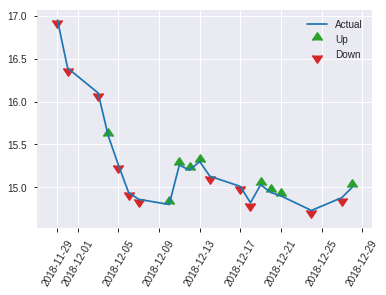


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2120955398076924
RMSE: 0.4605383152439028
LogLoss: 0.6124466213568649
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 347.0162375023202
Residual deviance: 307.44820392114616
AIC: 409.44820392114616
AUC: 0.7409901244068231
pr_auc: 0.6887478737064424
Gini: 0.4819802488136462
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47737626547704376: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      78   60   0.4348   (60.0/138.0)
1      18   95   0.1593   (18.0/113.0)
Total  96   155  0.3108   (78.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.477376     0.708955  154
max f2                       0.308403     0.813253  211
max f0point5                 0.585758     0.668663  96
max accuracy                 0.585758     0.697211  96
max precision                0.888103     1         0
max recall                   0.141086     1         247
max specificity              0.888103     1         0
max absolute_mcc             0.477376     0.41555   154
max min_per_class_accuracy   0.540949     0.666667  121
max mean_per_class_accuracy  0.477376     0.702963  154

Gains/Lift Table: Avg response rate: 45.02 %, avg score: 52.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.865609           2.22124   2.22124            1                0.879707  1                           0.879707            0.0265487       0.0265487                  122.124   122.124
    2        0.0239044                   0.831338           2.22124   2.22124            1                0.841556  1                           0.860632            0.0265487       0.0530973                  122.124   122.124
    3        0.0318725                   0.82168            1.11062   1.94358            0.5              0.827731  0.875                       0.852407            0.00884956      0.0619469                  11.0619   94.3584
    4        0.0438247                   0.80627            2.22124   2.01931            1                0.810817  0.909091                    0.841064            0.0265487       0.0884956                  122.124   101.931
    5        0.0517928                   0.796451           2.22124   2.05037            1                0.801055  0.923077                    0.834909            0.0176991       0.106195                   122.124   105.037
    6        0.103586                    0.756047           1.36692   1.70865            0.615385         0.771289  0.769231                    0.803099            0.0707965       0.176991                   36.6916   70.8645
    7        0.151394                    0.707494           1.48083   1.6367             0.666667         0.731198  0.736842                    0.780393            0.0707965       0.247788                   48.0826   63.6702
    8        0.203187                    0.678418           1.36692   1.56793            0.615385         0.690991  0.705882                    0.757604            0.0707965       0.318584                   36.6916   56.7933
    9        0.302789                    0.625961           1.51044   1.54902            0.68             0.649263  0.697368                    0.721966            0.150442        0.469027                   51.0442   54.9022
    10       0.40239                     0.575503           1.24389   1.4735             0.56             0.602386  0.663366                    0.692367            0.123894        0.59292                    24.3894   47.3495
    11       0.501992                    0.536998           0.977345  1.37505            0.44             0.553757  0.619048                    0.664865            0.0973451       0.690265                   -2.26549  37.5053
    12       0.601594                    0.484614           1.33274   1.36805            0.6              0.507846  0.615894                    0.638868            0.132743        0.823009                   33.2743   36.8048
    13       0.701195                    0.441001           0.533097  1.24945            0.24             0.459535  0.5625                      0.613395            0.0530973       0.876106                   -46.6903  24.9447
    14       0.800797                    0.366229           0.355398  1.13825            0.16             0.407329  0.512438                    0.587765            0.0353982       0.911504                   -64.4602  13.8247
    15       0.900398                    0.244504           0.444248  1.06148            0.2              0.301593  0.477876                    0.556109            0.0442478       0.955752                   -55.5752  6.1477
    16       1                           0.0694717          0.444248  1                  0.2              0.196274  0.450199                    0.520269          

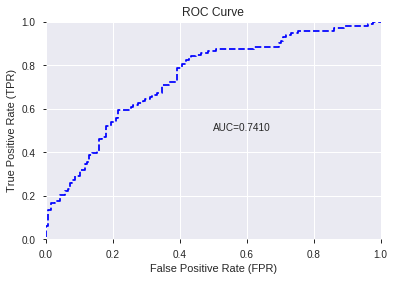

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


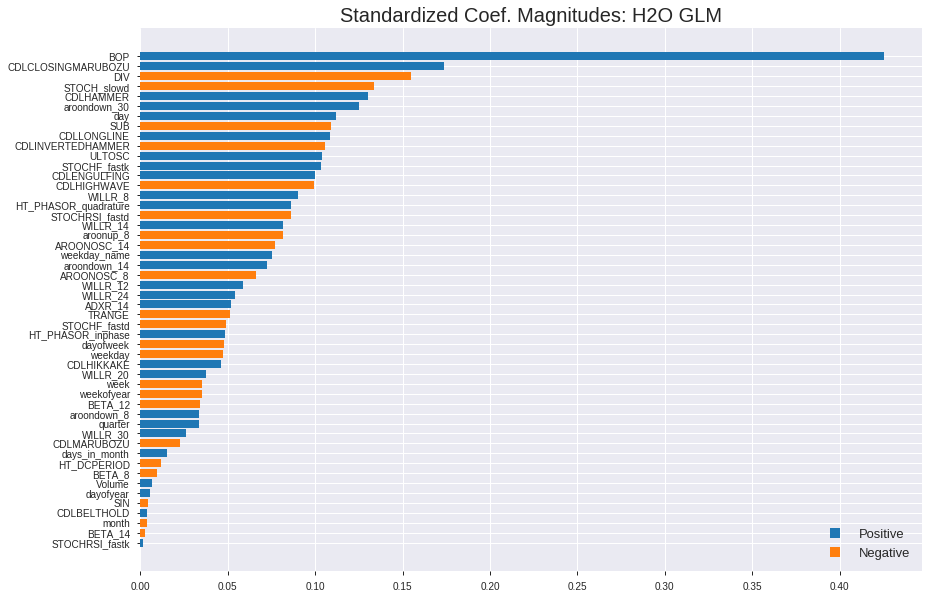

'log_likelihood'
--2019-08-27 17:54:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.238.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.238.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


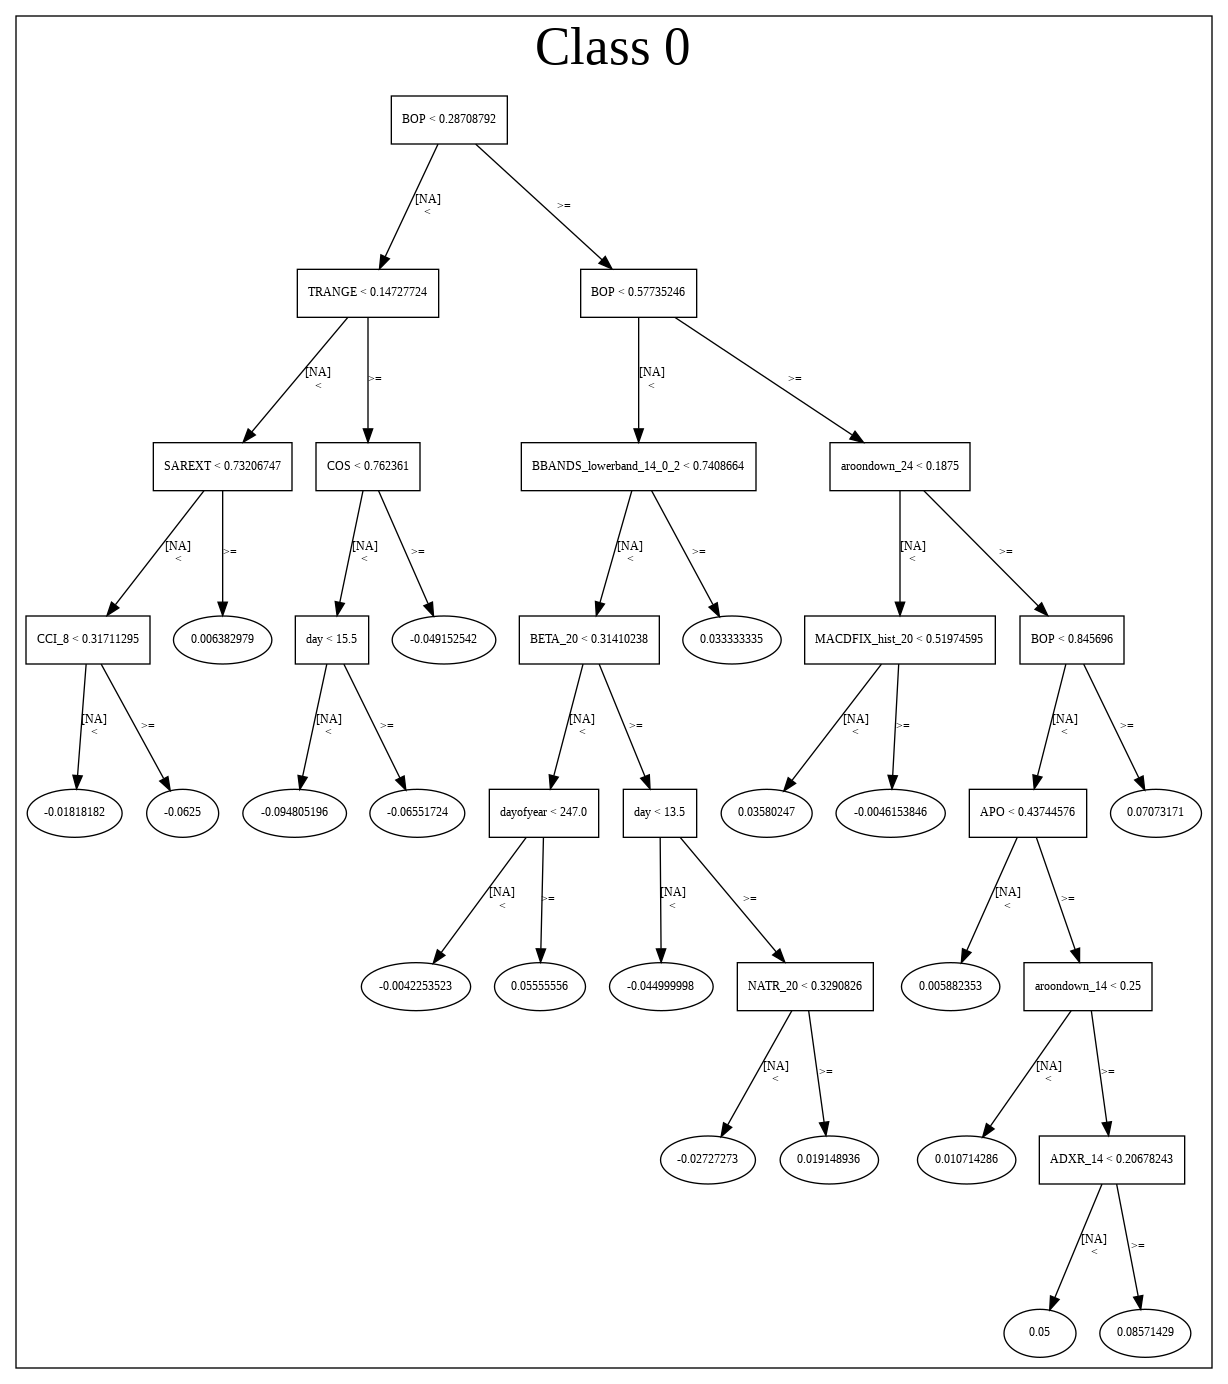

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_175421_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_175421_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_b872',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'STOCH_slowd',
 'CDLHAMMER',
 'aroondown_30',
 'day',
 'SUB',
 'CDLLONGLINE',
 'CDLINVERTEDHAMMER',
 'ULTOSC',
 'STOCHF_fastk',
 'CDLENGULFING',
 'CDLHIGHWAVE',
 'WILLR_8',
 'HT_PHASOR_quadrature',
 'STOCHRSI_fastd',
 'WILLR_14',
 'aroonup_8',
 'AROONOSC_14',
 'weekday_name',
 'aroondown_14',
 'AROONOSC_8',
 'WILLR_12',
 'WILLR_24',
 'ADXR_14',
 'TRANGE',
 'STOCHF_fastd',
 'HT_PHASOR_inphase',
 'dayofweek',
 'weekday',
 'CDLHIKKAKE',
 'WILLR_20',
 'week',
 'weekofyear',
 'BETA_12',
 'aroondown_8',
 'quarter',
 'WILLR_30',
 'CDLMARUBOZU',
 'days_in_month',
 'HT_DCPERIOD',
 'BETA_8',
 'Volume',
 'dayofyear',
 'SIN',
 'CDLBELTHOLD',
 'month',
 'BETA_14',
 'STOCHRSI_fastk']

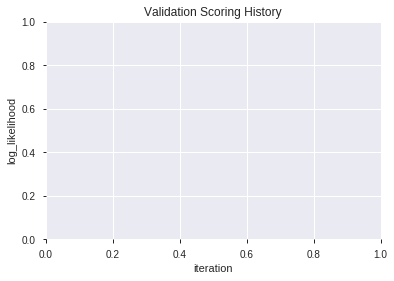

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_175438_model_6  0.741183  0.611524              0.299859  0.461062  0.212578
1  XGBoost_grid_1_AutoML_20190827_175438_model_2  0.730088  0.618641              0.307490  0.463764  0.215077
2               XGBoost_3_AutoML_20190827_175438  0.725022  0.626373              0.345774  0.468261  0.219268
3  XGBoost_grid_1_AutoML_20190827_175438_model_4  0.723868  0.621735              0.346576  0.465246  0.216454
4               XGBoost_2_AutoML_20190827_175438  0.718225  0.626965              0.347377  0.467943  0.218971
5  XGBoost_grid_1_AutoML_20190827_175438_model_5  0.717904  0.631910              0.361068  0.470153  0.221044
6  XGBoost_grid_1_AutoML_20190827_175438_model_3  0.717135  0.624154              0.359465  0.467186  0.218263
7  XGBoost_grid_1_AutoML_20190827_175438_model_7  0.712646  0.629784              0.351417  0.469705  0.220622
8  XGBoost_grid_1_AutoML_20190827_175438_model_1  0.702257  0.638040              0.336892  0.474078  0.224750
9               XGBoost_1_AutoML_20190827_175438  0.700782  0.644239              0.360684  0.475470  0.226071

variable  relative_importance  scaled_importance  percentage
0                    BOP          2121.132568           1.000000    0.215327
1                    DIV           571.601013           0.269479    0.058026
2                    SUB           421.918671           0.198912    0.042831
3           STOCHF_fastk           377.996216           0.178205    0.038372
4                 TRANGE           372.458649           0.175594    0.037810
5         STOCHRSI_fastd           365.150421           0.172149    0.037068
6                    day           325.332855           0.153377    0.033026
7   HT_PHASOR_quadrature           305.581207           0.144065    0.031021
8            HT_DCPERIOD           296.070587           0.139581    0.030056
9            STOCH_slowd           295.600067           0.139360    0.030008
10                Volume           278.404816           0.131253    0.028262
11                ULTOSC           250.536591           0.118115    0.025433
12          aroondown_30           247.096863           0.116493    0.025084
13             dayofyear           245.140961           0.115571    0.024886
14                   SIN           232.899673           0.109800    0.023643
15               ADXR_14           232.766510           0.109737    0.023629
16               BETA_14           225.357834           0.106244    0.022877
17               WILLR_8           224.453506           0.105818    0.022785
18           AROONOSC_14           175.850937           0.082904    0.017852
19     HT_PHASOR_inphase           166.334366           0.078418    0.016885
20               BETA_12           162.048935           0.076397    0.016450
21        STOCHRSI_fastk           157.235703           0.074128    0.015962
22              WILLR_30           148.171539           0.069855    0.015042
23             aroonup_8           135.689896           0.063970    0.013775
24              WILLR_20           131.044647           0.061781    0.013303
25              WILLR_12           128.069931           0.060378    0.013001
26          STOCHF_fastd           125.315018           0.059079    0.012721
27                BETA_8           123.929184           0.058426    0.012581
28             dayofweek           118.145126           0.055699    0.011994
29          aroondown_14           101.855232           0.048019    0.010340
30              WILLR_24            96.624146           0.045553    0.009809
31            AROONOSC_8            93.451714           0.044057    0.009487
32              WILLR_14            84.557205           0.039864    0.008584
33           aroondown_8            84.405220           0.039793    0.008568
34    CDLCLOSINGMARUBOZU            62.267075           0.029356    0.006321
35                  week            51.533150           0.024295    0.005231
36           CDLHIGHWAVE            46.899910           0.022111    0.004761
37          weekday_name            40.908344           0.019286    0.004153
38           CDLLONGLINE            38.769253           0.018278    0.003936
39             CDLHAMMER            34.634186           0.016328    0.003516
40               weekday            32.462914           0.015305    0.003295
41         days_in_month            30.307280           0.014288    0.003077
42            weekofyear            28.414379           0.013396    0.002884
43           CDLBELTHOLD            24.364801           0.011487    0.002473
44     CDLINVERTEDHAMMER            22.876276           0.010785    0.002322
45            CDLHIKKAKE            15.070222           0.007105    0.001530

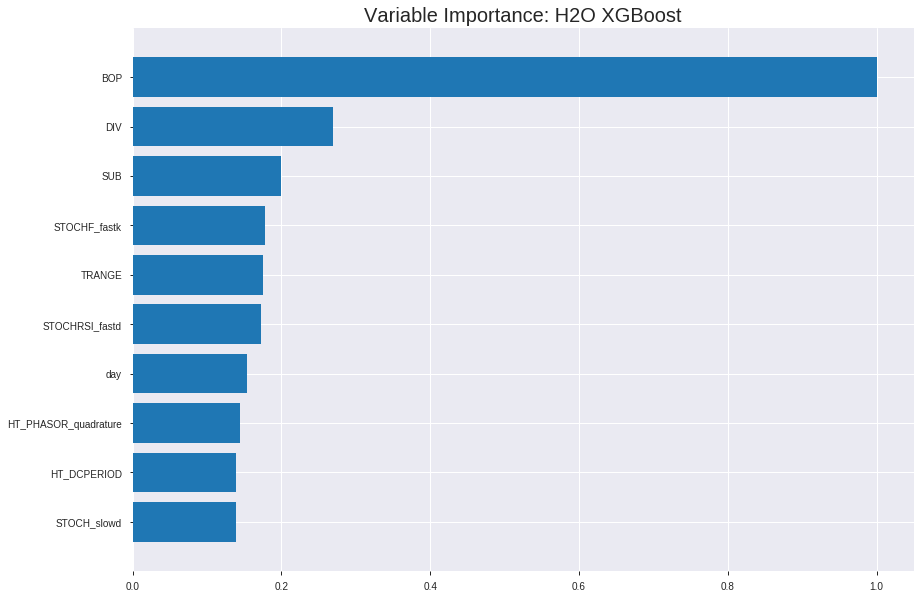

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_175438_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13944568563532955
RMSE: 0.3734242702815787
LogLoss: 0.4448180182131838
Mean Per-Class Error: 0.1605533200505267
AUC: 0.9211632873644047
pr_auc: 0.9183600393082031
Gini: 0.8423265747288093
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5242881178855896: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      738  157  0.1754   (157.0/895.0)
1      125  733  0.1457   (125.0/858.0)
Total  863  890  0.1609   (282.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.524288     0.838673  184
max f2                       0.383167     0.897271  254
max f0point5                 0.599565     0.852117  142
max accuracy                 0.550757     0.839133  170
max precision                0.887103     1         0
max recall                   0.175624     1         334
max specificity              0.887103     1         0
max absolute_mcc             0.524288     0.678823  184
max min_per_class_accuracy   0.536971     0.836872  177
max mean_per_class_accuracy  0.524288     0.839447  184

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 49.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.861231           2.04312   2.04312            1                0.875193   1                           0.875193            0.020979        0.020979                   104.312   104.312
    2        0.0205362                   0.845276           2.04312   2.04312            1                0.852886   1                           0.86404             0.020979        0.041958                   104.312   104.312
    3        0.0302339                   0.833313           2.04312   2.04312            1                0.838722   1                           0.855919            0.0198135       0.0617716                  104.312   104.312
    4        0.040502                    0.823683           2.04312   2.04312            1                0.827732   1                           0.848773            0.020979        0.0827506                  104.312   104.312
    5        0.0501997                   0.814225           2.04312   2.04312            1                0.818391   1                           0.842904            0.0198135       0.102564                   104.312   104.312
    6        0.100399                    0.772345           2.04312   2.04312            1                0.79329    1                           0.818097            0.102564        0.205128                   104.312   104.312
    7        0.150029                    0.732403           1.99616   2.02759            0.977011         0.751577   0.992395                    0.796092            0.0990676       0.304196                   99.6155   102.759
    8        0.200228                    0.702437           1.99669   2.01984            0.977273         0.718689   0.988604                    0.776686            0.100233        0.404429                   99.6689   101.984
    9        0.300057                    0.648264           1.7279    1.92271            0.845714         0.675359   0.941065                    0.742975            0.172494        0.576923                   72.7899   92.2711
    10       0.399886                    0.596553           1.4944    1.81579            0.731429         0.621915   0.88873                     0.712753            0.149184        0.726107                   49.4399   81.5786
    11       0.500285                    0.530512           1.17247   1.68668            0.573864         0.565251   0.825542                    0.683152            0.117716        0.843823                   17.2474   68.6684
    12       0.600114                    0.465627           0.747199  1.5304             0.365714         0.497351   0.749049                    0.652244            0.0745921       0.918415                   -25.2801  53.0401
    13       0.699943                    0.376756           0.548725  1.39039            0.268571         0.424823   0.680522                    0.619808            0.0547786       0.973193                   -45.1275  39.039
    14       0.799772                    0.259526           0.221825  1.24453            0.108571         0.316995   0.60913                     0.58201             0.0221445       0.995338                   -77.8175  24.4527
    15       0.899601                    0.125848           0.0467    1.1116             0.0228571        0.187095   0.544071                    0.538187            0.004662        1                          -95.33    11.1604
    16       1                           0.0477687          0         1                  0                0.0909703  0.489447                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.21673385131708975
RMSE: 0.46554683042320216
LogLoss: 0.6189385763685228
Mean Per-Class Error: 0.30682800345721684
AUC: 0.7296648420243925
pr_auc: 0.6719778368602467
Gini: 0.45932968404878505
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4768630266189575: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      114  153  0.573    (153.0/267.0)
1      32   202  0.1368   (32.0/234.0)
Total  146  355  0.3693   (185.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476863     0.685908  261
max f2                       0.244682     0.834538  349
max f0point5                 0.622608     0.680952  147
max accuracy                 0.622608     0.696607  147
max precision                0.870086     1         0
max recall                   0.16261      1         370
max specificity              0.870086     1         0
max absolute_mcc             0.613849     0.388791  156
max min_per_class_accuracy   0.589998     0.675214  176
max mean_per_class_accuracy  0.613849     0.693172  156

Gains/Lift Table: Avg response rate: 46.71 %, avg score: 54.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.834498           2.14103   2.14103            1                0.848847  1                           0.848847            0.025641        0.025641                   114.103   114.103
    2        0.0219561                   0.821274           1.71282   1.94639            0.8              0.826189  0.909091                    0.838548            0.017094        0.042735                   71.2821   94.6387
    3        0.0319361                   0.8032             1.28462   1.73958            0.6              0.810574  0.8125                      0.829806            0.0128205       0.0555556                  28.4615   73.9583
    4        0.0419162                   0.781044           1.28462   1.63126            0.6              0.78494   0.761905                    0.819124            0.0128205       0.0683761                  28.4615   63.1258
    5        0.0518962                   0.777926           0.85641   1.48225            0.4              0.779803  0.692308                    0.811562            0.00854701      0.0769231                  -14.359   48.2249
    6        0.101796                    0.748631           1.62718   1.55329            0.76             0.762311  0.72549                     0.78742             0.0811966       0.15812                    62.7179   55.3293
    7        0.151697                    0.718894           1.4559    1.52126            0.68             0.730613  0.710526                    0.768733            0.0726496       0.230769                   45.5897   52.1255
    8        0.201597                    0.703337           1.71282   1.56867            0.8              0.71063   0.732673                    0.754351            0.0854701       0.316239                   71.2821   56.8672
    9        0.301397                    0.66242            1.37026   1.50297            0.64             0.68404   0.701987                    0.731069            0.136752        0.452991                   37.0256   50.2972
    10       0.401198                    0.624512           1.4559    1.49126            0.68             0.64365   0.696517                    0.709323            0.145299        0.598291                   45.5897   49.1262
    11       0.500998                    0.582487           0.899231  1.37333            0.42             0.6045    0.641434                    0.688442            0.0897436       0.688034                   -10.0769  37.3327
    12       0.600798                    0.540884           0.685128  1.25901            0.32             0.562413  0.58804                     0.667507            0.0683761       0.75641                    -31.4872  25.9008
    13       0.700599                    0.486942           0.942051  1.21386            0.44             0.515767  0.566952                    0.645892            0.0940171       0.850427                   -5.79487  21.3858
    14       0.800399                    0.39339            0.727949  1.15327            0.34             0.438189  0.538653                    0.619993            0.0726496       0.923077                   -27.2051  15.3271
    15       0.9002                      0.2401             0.642308  1.09662            0.3              0.321493  0.512195                    0.5869              0.0641026       0.987179                   -35.7692  9.66229
    16       1                           0.0538708          0.128462  1                  0.06             0.142313  0.467066                    0.54253          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:54:54  9.455 sec   0                  0.5              0.693147            0.5             0                  1                0.510553                         0.5                0.693147              0.5               0                    1                  0.532934
    2019-08-27 17:54:54  9.564 sec   5                  0.472591         0.639437            0.828755        0.798505           2.04312          0.245864                         0.490034           0.673277              0.664154          0.603913             0.713675           0.43513
    2019-08-27 17:54:54  9.628 sec   10                 0.452226         0.600067            0.840755        0.827306           2.04312          0.251569                         0.48156            0.656164              0.693484          0.641223             1.42735            0.427146
    2019-08-27 17:54:54  9.697 sec   15                 0.436675         0.569728            0.852932        0.841844           2.04312          0.238448                         0.476613           0.645762              0.704176          0.644261             1.78419            0.433134
    2019-08-27 17:54:54  9.763 sec   20                 0.424932         0.546495            0.86352         0.856309           2.04312          0.230462                         0.47195            0.635751              0.715204          0.652179             1.78419            0.419162
    2019-08-27 17:54:54  9.832 sec   25                 0.415929         0.528085            0.872537        0.866392           2.04312          0.236167                         0.46949            0.630091              0.72231           0.661644             2.14103            0.341317
    2019-08-27 17:54:54  9.907 sec   30                 0.407822         0.511554            0.879341        0.874901           2.04312          0.209355                         0.46854            0.627335              0.723887          0.661316             2.14103            0.397206
    2019-08-27 17:54:54  9.979 sec   35                 0.399987         0.496268            0.889854        0.886858           2.04312          0.209355                         0.467867           0.62548               0.722678          0.661835             2.14103            0.367265
    2019-08-27 17:54:54  10.053 sec  40                 0.393462         0.48338             0.897513        0.892501           2.04312          0.197946                         0.467412           0.623922              0.725343          0.66417              1.78419            0.343313
    2019-08-27 17:54:54  10.137 sec  45                 0.387991         0.472742            0.904075        0.901961           2.04312          0.180833                         0.467328           0.623396              0.724247          0.662248             1.78419            0.343313
    2019-08-27 17:54:55  10.211 sec  50                 0.382936         0.462796            0.910141        0.906224           2.04312          0.172847                         0.46639            0.620913              0.724999          0.665966             1.78419            0.345309
    2019-08-27 17:54:55  10.287 sec  55                 0.377589         0.452559            0.915968        0.912323           2.04312          0.16429                          0.46633            0.620632              0.726272          0.

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
BOP                2121.132568359375      1.0                   0.21532732738151675
DIV                571.6010131835938      0.26947915548046486   0.05802622633463671
SUB                421.9186706542969      0.1989119760584492    0.04283118418884211
STOCHF_fastk       377.9962158203125      0.1782048993348303    0.03837238470006124
TRANGE             372.4586486816406      0.17559423406040336   0.03781023712383115
---                ---                    ---                   ---
days_in_month      30.307279586791992     0.014288253378822832  0.0030766514130118466
weekofyear         28.414379119873047     0.013395852547703145  0.0028844931270938
CDLBELTHOLD        24.36480140686035      0.011486694311476114  0.0024733991865386233
CDLINVERTEDHAMMER  22.87627601623535      0.010784934594601687  0.002322291142240043
CDLHIKKAKE         15.070221900939941     0.007104799636637635  0.0015298575173383533


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6852589641434262)

('F1', 0.7084870848708488)

('auc', 0.7411825060920867)

('logloss', 0.6115241637371408)

('mean_per_class_error', 0.2998589200974734)

('rmse', 0.4610616556073298)

('mse', 0.21257785027137202)

xgboost prediction progress: |████████████████████████████████████████████| 100%


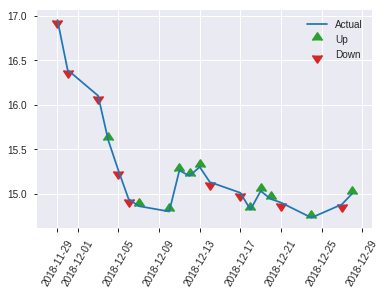


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21257785027137202
RMSE: 0.4610616556073298
LogLoss: 0.6115241637371408
Mean Per-Class Error: 0.2998589200974734
AUC: 0.7411825060920867
pr_auc: 0.6717275681560467
Gini: 0.4823650121841734
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5073301792144775: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      76   62   0.4493   (62.0/138.0)
1      17   96   0.1504   (17.0/113.0)
Total  93   158  0.3147   (79.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.50733      0.708487  157
max f2                       0.280502     0.825959  225
max f0point5                 0.50733      0.644295  157
max accuracy                 0.50733      0.685259  157
max precision                0.888619     1         0
max recall                   0.217515     1         236
max specificity              0.888619     1         0
max absolute_mcc             0.50733      0.412359  157
max min_per_class_accuracy   0.589297     0.646018  118
max mean_per_class_accuracy  0.50733      0.700141  157

Gains/Lift Table: Avg response rate: 45.02 %, avg score: 53.71 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.836372           1.48083    1.48083            0.666667         0.863044  0.666667                    0.863044            0.0176991       0.0176991                  48.0826   48.0826
    2        0.0239044                   0.796286           2.22124    1.85103            1                0.820839  0.833333                    0.841941            0.0265487       0.0442478                  122.124   85.1032
    3        0.0318725                   0.782439           2.22124    1.94358            1                0.787505  0.875                       0.828332            0.0176991       0.0619469                  122.124   94.3584
    4        0.0438247                   0.764688           2.22124    2.01931            1                0.772891  0.909091                    0.813212            0.0265487       0.0884956                  122.124   101.931
    5        0.0517928                   0.760425           1.11062    1.87951            0.5              0.76112   0.846154                    0.805198            0.00884956      0.0973451                  11.0619   87.951
    6        0.103586                    0.726946           1.70865    1.79408            0.769231         0.740183  0.807692                    0.77269             0.0884956       0.185841                   70.8645   79.4078
    7        0.151394                    0.71251            1.29572    1.6367             0.583333         0.718061  0.736842                    0.755439            0.0619469       0.247788                   29.5723   63.6702
    8        0.203187                    0.681346           1.53778    1.61149            0.692308         0.694298  0.72549                     0.739854            0.079646        0.327434                   53.7781   61.1487
    9        0.302789                    0.651272           1.33274    1.5198             0.6              0.667382  0.684211                    0.716015            0.132743        0.460177                   33.2743   51.9795
    10       0.40239                     0.610328           1.15504    1.42951            0.52             0.631583  0.643564                    0.695116            0.115044        0.575221                   15.5044   42.951
    11       0.501992                    0.576206           0.977345   1.33979            0.44             0.594508  0.603175                    0.675154            0.0973451       0.672566                   -2.26549  33.9795
    12       0.601594                    0.531734           1.33274    1.33863            0.6              0.549263  0.602649                    0.654311            0.132743        0.80531                    33.2743   33.8627
    13       0.701195                    0.459981           0.888496   1.27469            0.4              0.491999  0.573864                    0.631255            0.0884956       0.893805                   -11.1504  27.4688
    14       0.800797                    0.381995           0.355398   1.16035            0.16             0.418801  0.522388                    0.604831            0.0353982       0.929204                   -64.4602  16.0349
    15       0.900398                    0.280502           0.621947   1.10079            0.28             0.342761  0.495575                    0.575841            0.0619469       0.99115                    -37.8053  10.0791
    16       1                           0.0640066          0.0888496  1                  0.04             0.186603  0.450199                    0

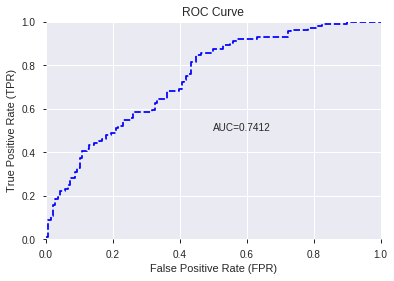

This function is available for GLM models only


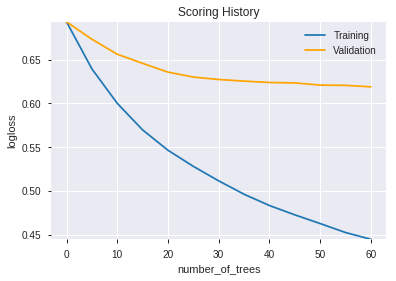

--2019-08-27 17:55:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.84
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.84|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.jav

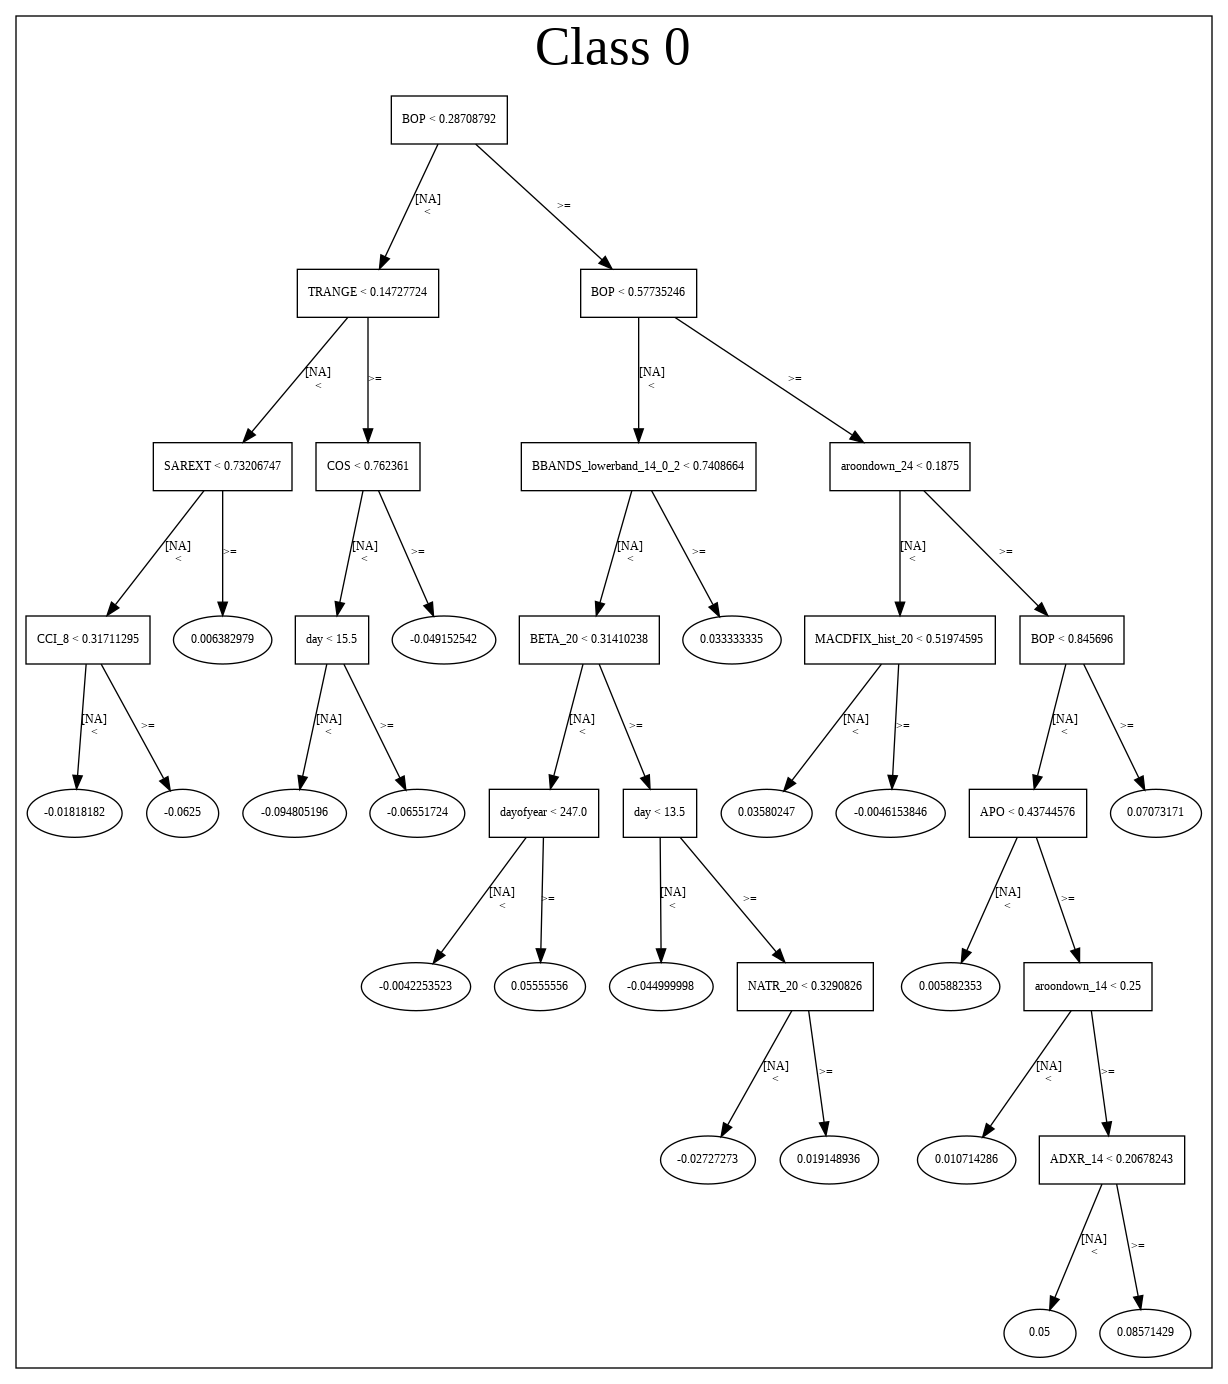

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_175438_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_175438_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_b872',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'SUB',
 'STOCHF_fastk',
 'TRANGE',
 'STOCHRSI_fastd',
 'day',
 'HT_PHASOR_quadrature',
 'HT_DCPERIOD',
 'STOCH_slowd',
 'Volume',
 'ULTOSC',
 'aroondown_30',
 'dayofyear',
 'SIN',
 'ADXR_14',
 'BETA_14',
 'WILLR_8',
 'AROONOSC_14',
 'HT_PHASOR_inphase',
 'BETA_12',
 'STOCHRSI_fastk',
 'WILLR_30',
 'aroonup_8',
 'WILLR_20',
 'WILLR_12',
 'STOCHF_fastd',
 'BETA_8',
 'dayofweek',
 'aroondown_14',
 'WILLR_24',
 'AROONOSC_8',
 'WILLR_14',
 'aroondown_8',
 'CDLCLOSINGMARUBOZU',
 'week',
 'CDLHIGHWAVE',
 'weekday_name',
 'CDLLONGLINE',
 'CDLHAMMER',
 'weekday',
 'days_in_month',
 'weekofyear',
 'CDLBELTHOLD',
 'CDLINVERTEDHAMMER',
 'CDLHIKKAKE']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

37

['BOP',
 'CCI_8',
 'CMO_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'RSI_14',
 'WILLR_14',
 'CMO_20',
 'RSI_20',
 'WILLR_20',
 'WILLR_24',
 'WILLR_30',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_175513_model_9  0.743235  0.634988              0.289791  0.471905  0.222694
1  DeepLearning_grid_1_AutoML_20190827_175513_model_8  0.731050  0.655469              0.299442  0.482573  0.232877
2  DeepLearning_grid_1_AutoML_20190827_175513_model_6  0.716429  0.657940              0.301077  0.483272  0.233552
3  DeepLearning_grid_1_AutoML_20190827_175513_model_5  0.705784  0.669096              0.319161  0.489971  0.240071
4  DeepLearning_grid_1_AutoML_20190827_175513_model_7  0.688053  0.634691              0.327658  0.468867  0.219837
5  DeepLearning_grid_1_AutoML_20190827_175513_model_4  0.682057  0.718925              0.411408  0.506248  0.256287
6  DeepLearning_grid_1_AutoML_20190827_175513_model_2  0.631525  1.071043              0.393677  0.582246  0.339010
7  DeepLearning_grid_1_AutoML_20190827_175513_model_3  0.629922  0.939905              0.415031  0.569569  0.324409
8               DeepLearning_1_AutoML_20190827_175513  0.597473  0.845037              0.429524  0.539131  0.290662
9  DeepLearning_grid_1_AutoML_20190827_175513_model_1  0.585866  1.309053              0.435167  0.617160  0.380886

variable  relative_importance  scaled_importance  percentage
0   CDLCLOSINGMARUBOZU             1.000000           1.000000    0.060340
1                  BOP             0.965639           0.965639    0.058266
2          CDLLONGLINE             0.843468           0.843468    0.050895
3                  DIV             0.801536           0.801536    0.048364
4         CDLENGULFING             0.793634           0.793634    0.047888
5                  SUB             0.787043           0.787043    0.047490
6               TRANGE             0.595027           0.595027    0.035904
7          CDLMARUBOZU             0.542207           0.542207    0.032717
8               ULTOSC             0.511152           0.511152    0.030843
9          CDLBELTHOLD             0.502039           0.502039    0.030293
10             WILLR_8             0.443732           0.443732    0.026775
11        STOCHF_fastk             0.440420           0.440420    0.026575
12            WILLR_14             0.421695           0.421695    0.025445
13      STOCHRSI_fastk             0.421095           0.421095    0.025409
14              CCI_12             0.401903           0.401903    0.024251
15               CCI_8             0.393578           0.393578    0.023748
16              CCI_14             0.382193           0.382193    0.023061
17            WILLR_12             0.363557           0.363557    0.021937
18               ADOSC             0.335752           0.335752    0.020259
19        STOCHF_fastd             0.334211           0.334211    0.020166
20            WILLR_20             0.331618           0.331618    0.020010
21              CMO_20             0.331349           0.331349    0.019993
22         STOCH_slowk             0.327589           0.327589    0.019767
23               MOM_8             0.318165           0.318165    0.019198
24              CMO_14             0.313759           0.313759    0.018932
25              RSI_20             0.312843           0.312843    0.018877
26            WILLR_30             0.312695           0.312695    0.018868
27              RSI_14             0.311208           0.311208    0.018778
28            WILLR_24             0.310992           0.310992    0.018765
29              CMO_12             0.310702           0.310702    0.018748
30              ROCR_8             0.309655           0.309655    0.018684
31               RSI_8             0.306922           0.306922    0.018520
32              ROCP_8             0.302288           0.302288    0.018240
33               ROC_8             0.301102           0.301102    0.018168
34           ROCR100_8             0.298679           0.298679    0.018022
35              RSI_12             0.297899           0.297899    0.017975
36               CMO_8             0.295489           0.295489    0.017830

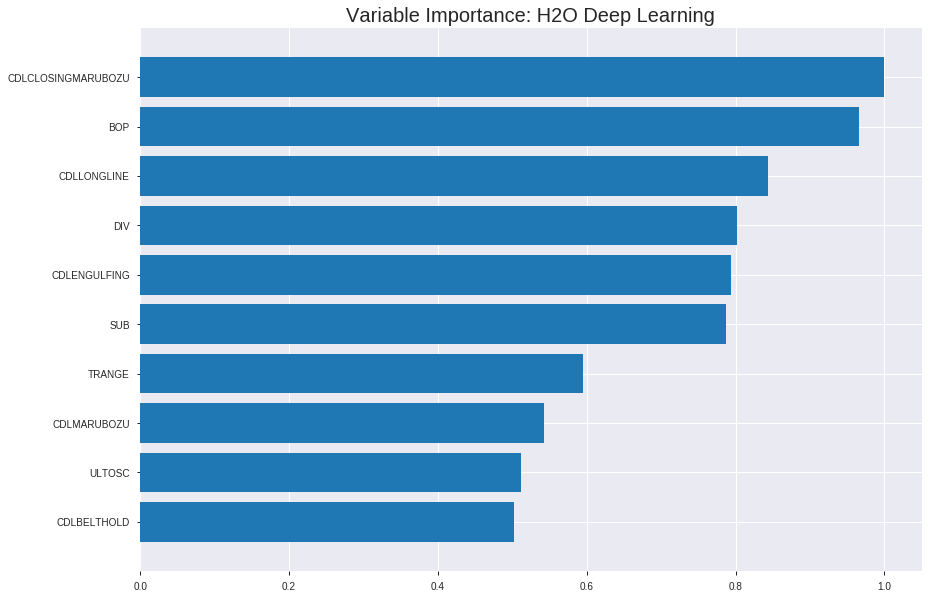

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_175513_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19759262936038238
RMSE: 0.4445139248216892
LogLoss: 0.577030300421076
Mean Per-Class Error: 0.2974638955085882
AUC: 0.7644242163795236
pr_auc: 0.7284488570458304
Gini: 0.5288484327590472
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35971022897574445: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      394  501   0.5598   (501.0/895.0)
1      73   785   0.0851   (73.0/858.0)
Total  467  1286  0.3274   (574.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.35971      0.732276  260
max f2                       0.146545     0.846417  341
max f0point5                 0.579542     0.687014  164
max accuracy                 0.552434     0.700513  185
max precision                0.879288     1         0
max recall                   0.0321065    1         395
max specificity              0.879288     1         0
max absolute_mcc             0.552434     0.411947  185
max min_per_class_accuracy   0.580555     0.693473  163
max mean_per_class_accuracy  0.552434     0.702536  185

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 49.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.846264           1.92962   1.92962            0.944444         0.856782   0.944444                    0.856782            0.0198135       0.0198135                  92.9617   92.9617
    2        0.0205362                   0.829926           1.5891    1.75936            0.777778         0.837431   0.861111                    0.847106            0.016317        0.0361305                  58.9096   75.9356
    3        0.0302339                   0.812573           1.56239   1.69618            0.764706         0.821485   0.830189                    0.838888            0.0151515       0.0512821                  56.2389   69.6178
    4        0.040502                    0.798725           1.92962   1.75536            0.944444         0.805153   0.859155                    0.830336            0.0198135       0.0710956                  92.9617   75.536
    5        0.0501997                   0.784098           1.80276   1.76452            0.882353         0.791109   0.863636                    0.822758            0.0174825       0.0885781                  80.2756   76.4516
    6        0.100399                    0.750204           1.64843   1.70647            0.806818         0.766788   0.835227                    0.794773            0.0827506       0.171329                   64.8429   70.6473
    7        0.150029                    0.699598           1.45602   1.62362            0.712644         0.727686   0.794677                    0.772581            0.0722611       0.24359                    45.6019   62.3623
    8        0.200228                    0.649234           1.41626   1.57163            0.693182         0.672047   0.769231                    0.747376            0.0710956       0.314685                   41.6256   57.1633
    9        0.300057                    0.620441           1.401     1.51486            0.685714         0.633062   0.741445                    0.709343            0.13986         0.454545                   40.0999   51.4863
    10       0.399886                    0.596138           1.27257   1.45438            0.622857         0.608594   0.71184                     0.684192            0.12704         0.581585                   27.2574   45.4378
    11       0.500285                    0.579434           1.17247   1.3978             0.573864         0.586987   0.684151                    0.664684            0.117716        0.699301                   17.2474   39.7804
    12       0.600114                    0.543022           1.06242   1.34201            0.52             0.567497   0.656844                    0.648517            0.106061        0.805361                   6.24242   34.2014
    13       0.699943                    0.439148           0.805574  1.2655             0.394286         0.500827   0.619397                    0.627453            0.0804196       0.885781                   -19.4426  26.5504
    14       0.799772                    0.230599           0.6071    1.18332            0.297143         0.332338   0.579173                    0.590616            0.0606061       0.946387                   -39.29    18.3321
    15       0.899601                    0.124338           0.39695   1.09606            0.194286         0.173627   0.536462                    0.544343            0.039627        0.986014                   -60.305   9.60574
    16       1                           0.0111942          0.139304  1                  0.0681818        0.0798632  0.489447                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.22138360811401697
RMSE: 0.47051419544368367
LogLoss: 0.6284562064069069
Mean Per-Class Error: 0.3009699414193796
AUC: 0.7271599603060278
pr_auc: 0.6458863167276392
Gini: 0.4543199206120556
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5481541132728013: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      116  151  0.5655   (151.0/267.0)
1      29   205  0.1239   (29.0/234.0)
Total  145  356  0.3593   (180.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.548154     0.694915  259
max f2                       0.232556     0.835745  346
max f0point5                 0.588653     0.679862  182
max accuracy                 0.588653     0.700599  182
max precision                0.864647     1         0
max recall                   0.120735     1         380
max specificity              0.864647     1         0
max absolute_mcc             0.588653     0.398283  182
max min_per_class_accuracy   0.586685     0.685393  190
max mean_per_class_accuracy  0.588653     0.69903   182

Gains/Lift Table: Avg response rate: 46.71 %, avg score: 53.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.819053           1.78419   1.78419            0.833333         0.83956   0.833333                    0.83956             0.0213675       0.0213675                  78.4188   78.4188
    2        0.0219561                   0.777703           1.71282   1.75175            0.8              0.788743  0.818182                    0.816461            0.017094        0.0384615                  71.2821   75.1748
    3        0.0319361                   0.762089           0         1.20433            0                0.766575  0.5625                      0.800872            0               0.0384615                  -100      20.4327
    4        0.0419162                   0.737835           1.71282   1.3254             0.8              0.751617  0.619048                    0.789144            0.017094        0.0555556                  71.2821   32.5397
    5        0.0518962                   0.726087           1.71282   1.3999             0.8              0.73041   0.653846                    0.777849            0.017094        0.0726496                  71.2821   39.9901
    6        0.101796                    0.677277           1.28462   1.34339            0.6              0.700399  0.627451                    0.739883            0.0641026       0.136752                   28.4615   34.3389
    7        0.151697                    0.648184           1.54154   1.40857            0.72             0.660858  0.657895                    0.713888            0.0769231       0.213675                   54.1538   40.857
    8        0.201597                    0.634697           1.8841    1.52628            0.88             0.639939  0.712871                    0.695584            0.0940171       0.307692                   88.4103   52.6276
    9        0.301397                    0.615786           1.41308   1.48879            0.66             0.624051  0.695364                    0.671898            0.141026        0.448718                   41.3077   48.8793
    10       0.401198                    0.596762           1.41308   1.46996            0.66             0.606814  0.686567                    0.655708            0.141026        0.589744                   41.3077   46.9958
    11       0.500998                    0.585838           1.07051   1.39039            0.5              0.590808  0.649402                    0.64278             0.106838        0.696581                   7.05128   39.0387
    12       0.600798                    0.578971           0.81359   1.29457            0.38             0.582549  0.604651                    0.632774            0.0811966       0.777778                   -18.641   29.4574
    13       0.700599                    0.561369           0.85641   1.23216            0.4              0.57316   0.575499                    0.624282            0.0854701       0.863248                   -14.359   23.2157
    14       0.800399                    0.424088           0.599487  1.15327            0.28             0.498964  0.538653                    0.608657            0.0598291       0.923077                   -40.0513  15.3271
    15       0.9002                      0.223426           0.642308  1.09662            0.3              0.323864  0.512195                    0.577083            0.0641026       0.987179                   -35.7692  9.66229
    16       1                           0.0229399          0.128462  1                  0.06             0.131248  0.467066                    0.532589          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:03:03  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 18:03:05  2 min 12.698 sec  503 obs/sec       0.554478  1             972        0.688416         2.60405             -0.896513      0.724858        0.6895             1.81611          0.343982                         0.671473           2.26374               -0.811363        0.73309           0.645623             1.42735            0.325349
    2019-08-27 18:03:15  2 min 22.561 sec  835 obs/sec       5.17285   9             9068       0.45703          0.604564            0.16412        0.740001        0.708255           1.81611          0.333714                         0.469197           0.630734              0.115581         0.736811          0.649884             1.42735            0.329341
    2019-08-27 18:03:24  2 min 31.997 sec  985 obs/sec       10.8568   19            19032      0.457993         0.607145            0.160595       0.740847        0.702342           1.7026           0.338848                         0.47379            0.639416              0.0981789        0.72868           0.63487              1.78419            0.329341
    2019-08-27 18:03:34  2 min 42.343 sec  1113 obs/sec      18.2447   32            31983      0.458067         0.608325            0.160323       0.753654        0.711362           1.81611          0.339418                         0.482007           0.657123              0.0666262        0.727552          0.644034             2.14103            0.337325
    2019-08-27 18:03:44  2 min 52.473 sec  1216 obs/sec      26.2858   46            46079      0.449498         0.588922            0.191447       0.756449        0.713782           1.7026           0.330291                         0.469055           0.628562              0.116114         0.732466          0.649793             1.78419            0.353293
    2019-08-27 18:03:55  3 min  2.556 sec  1298 obs/sec      34.8397   61            61074      0.448547         0.585557            0.194864       0.762351        0.721317           1.81611          0.328009                         0.473703           0.636487              0.0985099        0.732282          0.648147             1.78419            0.327345
    2019-08-27 18:04:04  3 min 12.260 sec  1363 obs/sec      43.3942   76            76070      0.444514         0.57703             0.209277       0.764424        0.728449           1.92962          0.327439                         0.470514           0.628456              0.110607         0.72716           0.645886             1.78419            0.359281

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.06033971585121532
BOP                 0.9656389951705933     0.9656389951705933   0.058266382583446685
CDLLONGLINE         0.8434675931930542     0.8434675931930542   0.050894594902977375
DIV                 0.8015363812446594     0.8015363812446594   0.04836447748871415
CDLENGULFING        0.7936339378356934     0.7936339378356934   0.047887646298886824
---                 ---                    ---                  ---
ROCP_8              0.30228835344314575    0.30228835344314575  0.01823999335189116
ROC_8               0.30110207200050354    0.30110207200050354  0.01816841346672256
ROCR100_8           0.29867857694625854    0.29867857694625854  0.018022180463782594
RSI_12              0.2978994846343994     0.2978994846343994   0.017975170255063146
CMO_8               0.29548871517181396    0.29548871517181396  0.017829705110707954


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6972111553784861)

('F1', 0.7142857142857143)

('auc', 0.7432345774015647)

('logloss', 0.6349884191755514)

('mean_per_class_error', 0.2897909452353469)

('rmse', 0.4719045372408194)

('mse', 0.22269389226847186)

deeplearning prediction progress: |███████████████████████████████████████| 100%


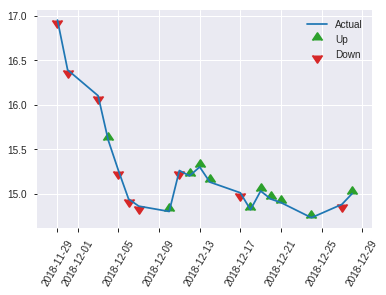


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.22269389226847186
RMSE: 0.4719045372408194
LogLoss: 0.6349884191755514
Mean Per-Class Error: 0.2897909452353469
AUC: 0.7432345774015647
pr_auc: 0.6723296878402126
Gini: 0.48646915480312947
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5776694476663056: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      80   58   0.4203   (58.0/138.0)
1      18   95   0.1593   (18.0/113.0)
Total  98   153  0.3028   (76.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.577669     0.714286  152
max f2                       0.422613     0.824508  208
max f0point5                 0.584307     0.658915  132
max accuracy                 0.584307     0.697211  132
max precision                0.832647     1         0
max recall                   0.0904228    1         247
max specificity              0.832647     1         0
max absolute_mcc             0.577669     0.428747  152
max min_per_class_accuracy   0.587666     0.672566  119
max mean_per_class_accuracy  0.577669     0.710209  152

Gains/Lift Table: Avg response rate: 45.02 %, avg score: 54.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.814818           2.22124   2.22124            1                0.823768  1                           0.823768            0.0265487       0.0265487                  122.124   122.124
    2        0.0239044                   0.779777           1.48083   1.85103            0.666667         0.798218  0.833333                    0.810993            0.0176991       0.0442478                  48.0826   85.1032
    3        0.0318725                   0.761987           2.22124   1.94358            1                0.778058  0.875                       0.802759            0.0176991       0.0619469                  122.124   94.3584
    4        0.0438247                   0.733973           2.22124   2.01931            1                0.742625  0.909091                    0.786359            0.0265487       0.0884956                  122.124   101.931
    5        0.0517928                   0.720082           1.11062   1.87951            0.5              0.724253  0.846154                    0.776804            0.00884956      0.0973451                  11.0619   87.951
    6        0.103586                    0.66575            1.19605   1.53778            0.538462         0.689429  0.692308                    0.733117            0.0619469       0.159292                   19.6052   53.7781
    7        0.151394                    0.639923           1.66593   1.57825            0.75             0.648375  0.710526                    0.706356            0.079646        0.238938                   66.5929   57.8249
    8        0.203187                    0.629874           1.53778   1.56793            0.692308         0.634964  0.705882                    0.688158            0.079646        0.318584                   53.7781   56.7933
    9        0.302789                    0.613009           1.33274   1.49057            0.6              0.620302  0.671053                    0.665837            0.132743        0.451327                   33.2743   49.0568
    10       0.40239                     0.598661           1.24389   1.42951            0.56             0.604421  0.643564                    0.650635            0.123894        0.575221                   24.3894   42.951
    11       0.501992                    0.586245           1.33274   1.41031            0.6              0.591055  0.634921                    0.638814            0.132743        0.707965                   33.2743   41.031
    12       0.601594                    0.578249           1.15504   1.36805            0.52             0.582616  0.615894                    0.629509            0.115044        0.823009                   15.5044   36.8048
    13       0.701195                    0.560975           0.621947  1.26207            0.28             0.571556  0.568182                    0.621277            0.0619469       0.884956                   -37.8053  26.2068
    14       0.800797                    0.445607           0.533097  1.1714             0.24             0.514877  0.527363                    0.608044            0.0530973       0.938053                   -46.6903  17.14
    15       0.900398                    0.301027           0.355398  1.08113            0.16             0.379544  0.486726                    0.582767            0.0353982       0.973451                   -64.4602  8.1134
    16       1                           0.0426654          0.266549  1                  0.12             0.173852  0.450199                    0.542038            0.0

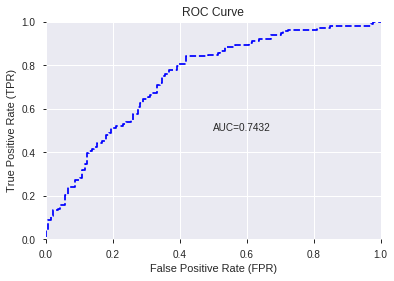

This function is available for GLM models only


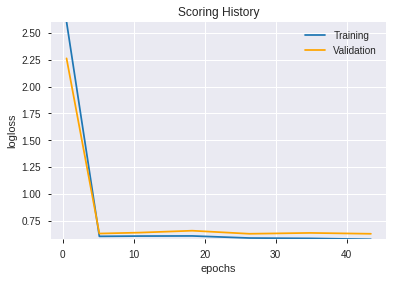

--2019-08-27 18:04:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.128.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.128.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


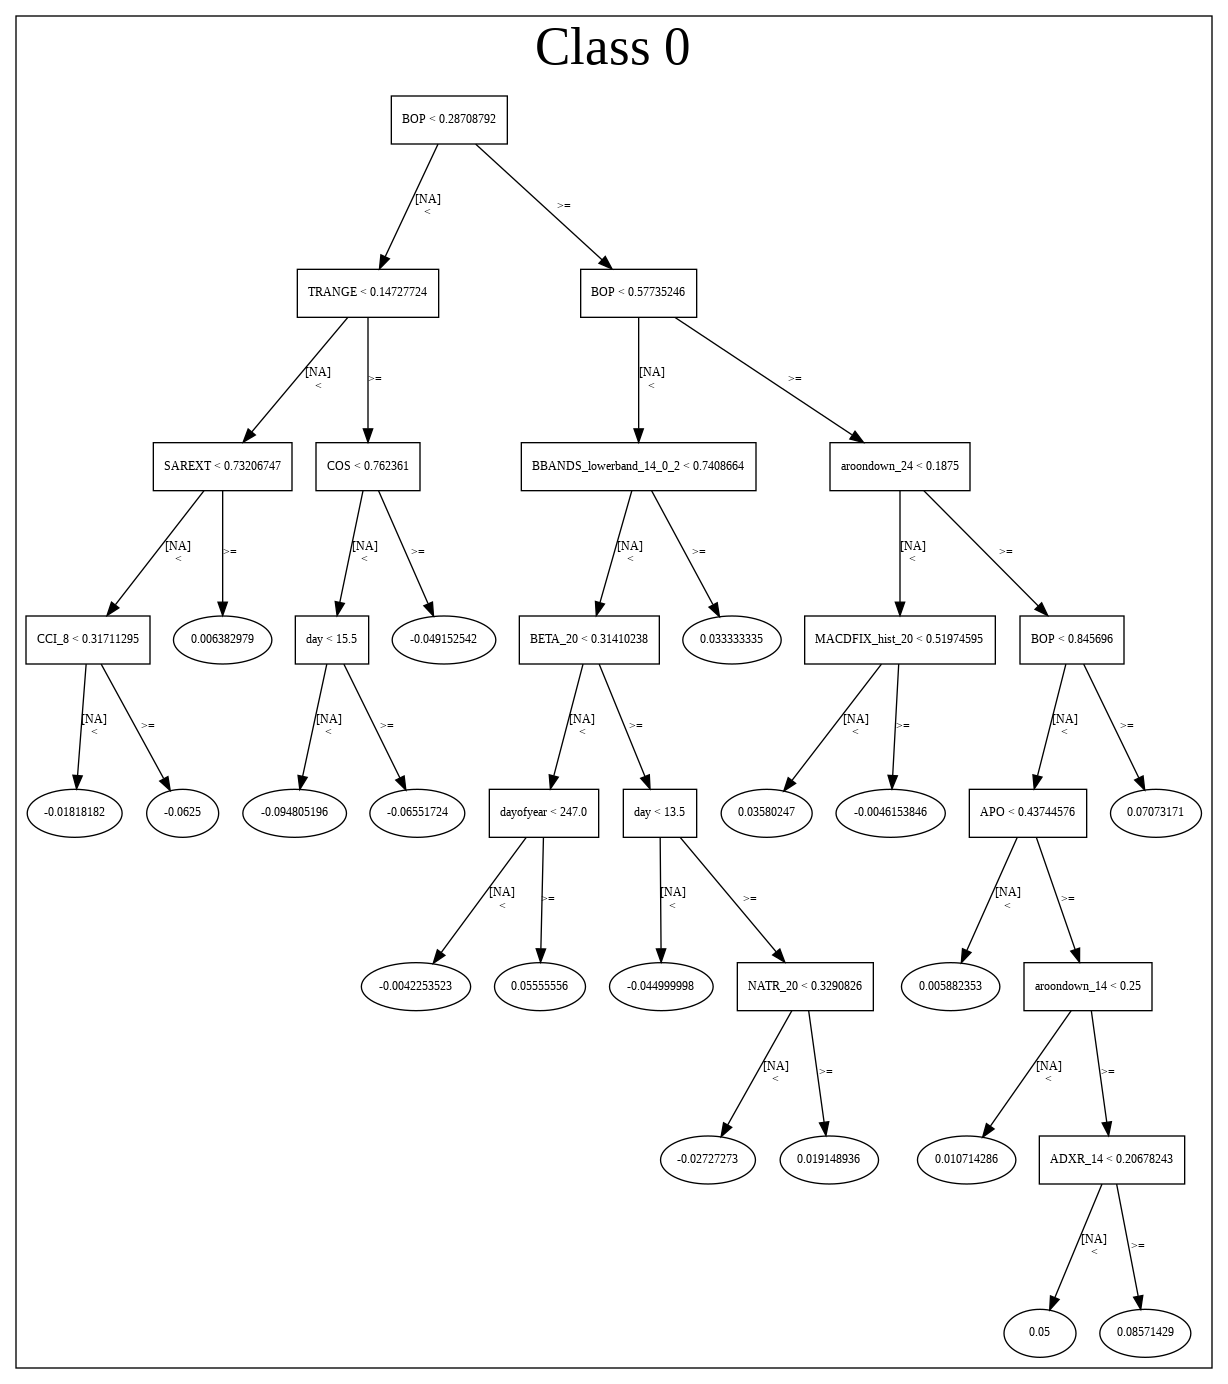

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_175513_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_175513_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_b872',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'BOP',
 'CDLLONGLINE',
 'DIV',
 'CDLENGULFING',
 'SUB',
 'TRANGE',
 'CDLMARUBOZU',
 'ULTOSC',
 'CDLBELTHOLD',
 'WILLR_8',
 'STOCHF_fastk',
 'WILLR_14',
 'STOCHRSI_fastk',
 'CCI_12',
 'CCI_8',
 'CCI_14',
 'WILLR_12',
 'ADOSC',
 'STOCHF_fastd',
 'WILLR_20',
 'CMO_20',
 'STOCH_slowk',
 'MOM_8',
 'CMO_14',
 'RSI_20',
 'WILLR_30',
 'RSI_14',
 'WILLR_24',
 'CMO_12',
 'ROCR_8',
 'RSI_8',
 'ROCP_8',
 'ROC_8',
 'ROCR100_8',
 'RSI_12',
 'CMO_8']

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_180423_model_1  0.743363  0.61071               0.31557  0.459811  0.211426

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.602161           1.000000    0.147443
1              WILLR_8             0.248887           0.413324    0.060942
2         STOCHF_fastk             0.239347           0.397480    0.058606
3               ULTOSC             0.214309           0.355900    0.052475
4                MOM_8             0.195980           0.325462    0.047987
5   CDLCLOSINGMARUBOZU             0.195626           0.324874    0.047900
6                  DIV             0.191687           0.318333    0.046936
7             WILLR_14             0.174044           0.289032    0.042616
8               CCI_12             0.168011           0.279014    0.041139
9                CCI_8             0.165257           0.274441    0.040464
10                 SUB             0.157940           0.262288    0.038673
11               ADOSC             0.156521           0.259931    0.038325
12              CCI_14             0.136253           0.226273    0.033362
13            WILLR_12             0.115019           0.191011    0.028163
14         STOCH_slowk             0.096243           0.159829    0.023566
15        STOCHF_fastd             0.095867           0.159206    0.023474
16            WILLR_24             0.093170           0.154727    0.022813
17        CDLENGULFING             0.086411           0.143501    0.021158
18         CDLMARUBOZU             0.078369           0.130146    0.019189
19         CDLLONGLINE             0.071032           0.117961    0.017393
20              CMO_12             0.062064           0.103068    0.015197
21              RSI_12             0.061043           0.101374    0.014947
22               RSI_8             0.060351           0.100224    0.014777
23               CMO_8             0.057618           0.095685    0.014108
24            WILLR_30             0.054073           0.089798    0.013240
25              CMO_14             0.045981           0.076360    0.011259
26              RSI_14             0.044631           0.074118    0.010928
27           ROCR100_8             0.034025           0.056505    0.008331
28              ROCR_8             0.033759           0.056063    0.008266
29               ROC_8             0.033719           0.055997    0.008256
30              ROCP_8             0.033442           0.055536    0.008188
31      STOCHRSI_fastk             0.032241           0.053542    0.007894
32              RSI_20             0.015515           0.025766    0.003799
33              CMO_20             0.015253           0.025331    0.003735
34              TRANGE             0.008871           0.014731    0.002172
35         CDLBELTHOLD             0.007979           0.013251    0.001954
36            WILLR_20             0.001334           0.002216    0.000327

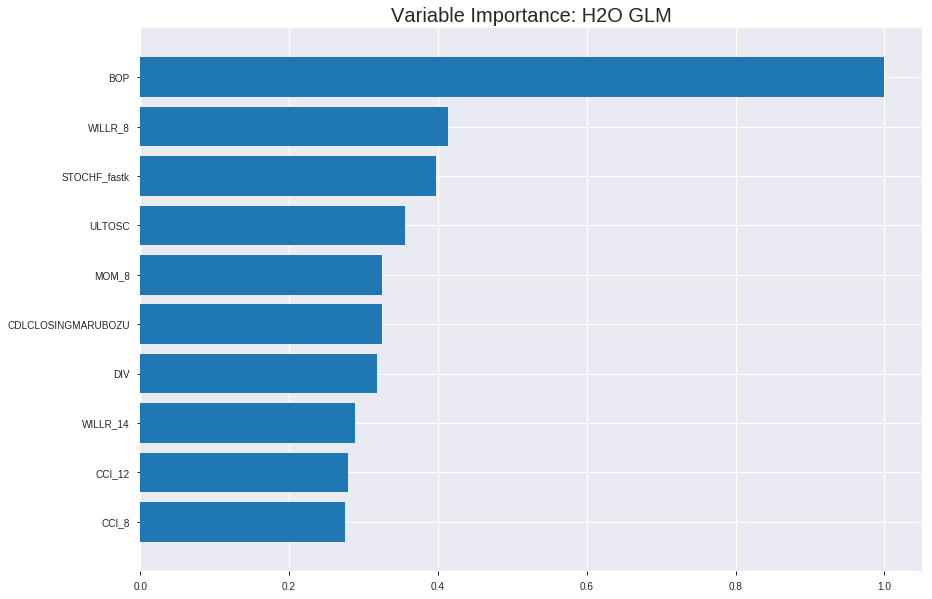

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_180423_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19944509016617246
RMSE: 0.4465927565088494
LogLoss: 0.5818906792631704
Null degrees of freedom: 1752
Residual degrees of freedom: 1715
Null deviance: 2429.39301010051
Residual deviance: 2040.1087214966756
AIC: 2116.1087214966756
AUC: 0.7575008790092589
pr_auc: 0.7116820339991626
Gini: 0.5150017580185178
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3889114537717606: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      467  428   0.4782   (428.0/895.0)
1      119  739   0.1387   (119.0/858.0)
Total  586  1167  0.312    (547.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.388911     0.729877  252
max f2                       0.169764     0.84675   353
max f0point5                 0.564503     0.684126  158
max accuracy                 0.453824     0.690816  219
max precision                0.903588     1         0
max recall                   0.0993685    1         382
max specificity              0.903588     1         0
max absolute_mcc             0.388911     0.405953  252
max min_per_class_accuracy   0.511313     0.683799  188
max mean_per_class_accuracy  0.453824     0.692557  219

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 48.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.872419           1.47559   1.47559            0.722222         0.88343   0.722222                    0.88343             0.0151515       0.0151515                  47.5589   47.5589
    2        0.0205362                   0.853415           1.36208   1.41884            0.666667         0.860025  0.694444                    0.871727            0.013986        0.0291375                  36.2082   41.8836
    3        0.0302339                   0.841316           1.92294   1.58053            0.941176         0.847427  0.773585                    0.863933            0.018648        0.0477855                  92.294    58.053
    4        0.040502                    0.829317           1.92962   1.66903            0.944444         0.835944  0.816901                    0.856837            0.0198135       0.0675991                  92.9617   66.9031
    5        0.0501997                   0.812789           1.68257   1.67165            0.823529         0.820478  0.818182                    0.849813            0.016317        0.0839161                  68.2572   67.1647
    6        0.100399                    0.761135           1.60199   1.63682            0.784091         0.786846  0.801136                    0.81833             0.0804196       0.164336                   60.1995   63.6821
    7        0.150029                    0.728202           1.62041   1.63139            0.793103         0.746083  0.798479                    0.79443             0.0804196       0.244755                   62.0408   63.1391
    8        0.200228                    0.687682           1.30017   1.54835            0.636364         0.706764  0.757835                    0.772452            0.0652681       0.310023                   30.017    54.835
    9        0.300057                    0.626459           1.38932   1.49544            0.68             0.658704  0.731939                    0.734608            0.138695        0.448718                   38.9324   49.5442
    10       0.399886                    0.568623           1.34262   1.45729            0.657143         0.59593   0.713267                    0.699988            0.134033        0.582751                   34.2624   45.7292
    11       0.500285                    0.507739           1.05639   1.37684            0.517045         0.538594  0.673888                    0.667599            0.106061        0.688811                   5.63877   37.6837
    12       0.600114                    0.435638           1.01572   1.31677            0.497143         0.47315   0.644487                    0.635252            0.101399        0.79021                    1.57243   31.6766
    13       0.699943                    0.367067           0.945674  1.26384            0.462857         0.40043   0.618582                    0.601761            0.0944056       0.884615                   -5.43257  26.3839
    14       0.799772                    0.284765           0.6071    1.18186            0.297143         0.327535  0.578459                    0.567532            0.0606061       0.945221                   -39.29    18.1864
    15       0.899601                    0.181468           0.39695   1.09476            0.194286         0.232324  0.535828                    0.530334            0.039627        0.984848                   -60.305   9.47618
    16       1                           0.037506           0.150913  1                  0.0738636        0.123091  0.489447                    0.489447           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20868284745596621
RMSE: 0.4568181776768151
LogLoss: 0.6049680242727122
Null degrees of freedom: 500
Residual degrees of freedom: 463
Null deviance: 693.3634685719368
Residual deviance: 606.1779603212576
AIC: 682.1779603212576
AUC: 0.7380758026825442
pr_auc: 0.6606812853441925
Gini: 0.4761516053650885
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45116361786890313: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      146  121  0.4532   (121.0/267.0)
1      36   198  0.1538   (36.0/234.0)
Total  182  319  0.3134   (157.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.451164     0.716094  243
max f2                       0.243649     0.833333  355
max f0point5                 0.568189     0.668224  156
max accuracy                 0.491127     0.690619  216
max precision                0.906065     1         0
max recall                   0.189952     1         380
max specificity              0.906065     1         0
max absolute_mcc             0.451164     0.407655  243
max min_per_class_accuracy   0.536004     0.683761  184
max mean_per_class_accuracy  0.487724     0.696533  219

Gains/Lift Table: Avg response rate: 46.71 %, avg score: 51.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.848021           2.14103   2.14103            1                0.868852  1                           0.868852            0.025641        0.025641                   114.103   114.103
    2        0.0219561                   0.816016           0.85641   1.55711            0.4              0.82397   0.727273                    0.848451            0.00854701      0.034188                   -14.359   55.711
    3        0.0319361                   0.806165           1.71282   1.60577            0.8              0.810069  0.75                        0.836457            0.017094        0.0512821                  71.2821   60.5769
    4        0.0419162                   0.794091           1.71282   1.63126            0.8              0.799669  0.761905                    0.827698            0.017094        0.0683761                  71.2821   63.1258
    5        0.0518962                   0.779327           1.28462   1.5646             0.6              0.786176  0.730769                    0.819713            0.0128205       0.0811966                  28.4615   56.4596
    6        0.101796                    0.740008           1.28462   1.42735            0.6              0.758085  0.666667                    0.789503            0.0641026       0.145299                   28.4615   42.735
    7        0.151697                    0.69906            1.4559    1.43674            0.68             0.72083   0.671053                    0.766913            0.0726496       0.217949                   45.5897   43.6741
    8        0.201597                    0.675718           1.54154   1.46268            0.72             0.68493   0.683168                    0.74662             0.0769231       0.294872                   54.1538   46.2681
    9        0.301397                    0.626872           1.49872   1.47461            0.7              0.652068  0.688742                    0.715312            0.149573        0.444444                   49.8718   47.4614
    10       0.401198                    0.57668            1.4559    1.46996            0.68             0.609519  0.686567                    0.688995            0.145299        0.589744                   45.5897   46.9958
    11       0.500998                    0.528419           1.02769   1.38186            0.48             0.551585  0.645418                    0.661623            0.102564        0.692308                   2.76923   38.1857
    12       0.600798                    0.472532           1.07051   1.33014            0.5              0.499917  0.621262                    0.634761            0.106838        0.799145                   7.05128   33.0139
    13       0.700599                    0.408616           0.770769  1.25046            0.36             0.442113  0.584046                    0.607318            0.0769231       0.876068                   -22.9231  25.0457
    14       0.800399                    0.338323           0.513846  1.15861            0.24             0.375745  0.541147                    0.578444            0.0512821       0.92735                    -48.6154  15.861
    15       0.9002                      0.243029           0.599487  1.09662            0.28             0.290097  0.512195                    0.546476            0.0598291       0.987179                   -40.0513  9.66229
    16       1                           0.0147198          0.128462  1                  0.06             0.185066  0.467066                    0.510407            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 18:04:23  0.000 sec   2            .2E2      38            1.3658515916540543  1.370887905444944
     2019-08-27 18:04:23  0.009 sec   4            .12E2     38            1.3569803799072016  1.3649836983768528
     2019-08-27 18:04:23  0.018 sec   6            .77E1     38            1.345548802884005   1.3571716718628242
     2019-08-27 18:04:23  0.027 sec   8            .48E1     38            1.33139826859122    1.3470950034619429
     2019-08-27 18:04:23  0.036 sec   10           .3E1      38            1.314480802927403   1.3343790836320386
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 18:04:24  0.153 sec   34           .98E-2    38            1.1614482968374498  1.2110283572399712
     2019-08-27 18:04:24  0.162 sec   36           .61E-2    38            1.1599718010654136  1.2129549028805866
     2019-08-27 18:04:24  0.177 sec   38           .38E-2    38            1.159061429980505   1.2151736097015131
     2019-08-27 18:04:24  0.185 sec   39           .24E-2    38            1.1585155634869695  1.2173878817652384
     2019-08-27 18:04:24  0.190 sec   40           .15E-2    38            1.158193161578381   1.2193805247649052


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6932270916334662)

('F1', 0.7021276595744681)

('auc', 0.7433628318584071)

('logloss', 0.6107096045776331)

('mean_per_class_error', 0.2974220854174683)

('rmse', 0.4598107476258023)

('mse', 0.21142592363219925)

glm prediction progress: |████████████████████████████████████████████████| 100%


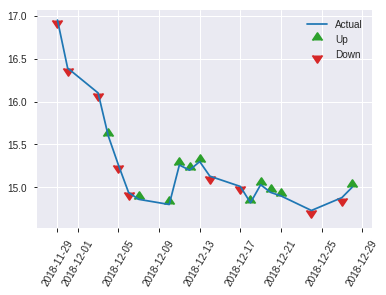


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21142592363219925
RMSE: 0.4598107476258023
LogLoss: 0.6107096045776331
Null degrees of freedom: 250
Residual degrees of freedom: 213
Null deviance: 347.0162375023202
Residual deviance: 306.5762214979718
AIC: 382.5762214979718
AUC: 0.7433628318584071
pr_auc: 0.6896627197989227
Gini: 0.48672566371681425
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4576462033113733: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      68   70   0.5072   (70.0/138.0)
1      14   99   0.1239   (14.0/113.0)
Total  82   169  0.3347   (84.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.457646     0.702128  168
max f2                       0.213683     0.812772  236
max f0point5                 0.544103     0.655608  129
max accuracy                 0.544103     0.693227  129
max precision                0.918052     1         0
max recall                   0.122098     1         248
max specificity              0.918052     1         0
max absolute_mcc             0.505875     0.407594  143
max min_per_class_accuracy   0.553731     0.673913  121
max mean_per_class_accuracy  0.505875     0.702578  143

Gains/Lift Table: Avg response rate: 45.02 %, avg score: 53.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.86719            2.22124   2.22124            1                0.8973    1                           0.8973              0.0265487       0.0265487                  122.124   122.124
    2        0.0239044                   0.831938           2.22124   2.22124            1                0.851489  1                           0.874395            0.0265487       0.0530973                  122.124   122.124
    3        0.0318725                   0.823872           2.22124   2.22124            1                0.828242  1                           0.862857            0.0176991       0.0707965                  122.124   122.124
    4        0.0438247                   0.811411           1.48083   2.01931            0.666667         0.815294  0.909091                    0.849885            0.0176991       0.0884956                  48.0826   101.931
    5        0.0517928                   0.800232           1.11062   1.87951            0.5              0.802323  0.846154                    0.842568            0.00884956      0.0973451                  11.0619   87.951
    6        0.103586                    0.754484           1.70865   1.79408            0.769231         0.776765  0.807692                    0.809666            0.0884956       0.185841                   70.8645   79.4078
    7        0.151394                    0.716364           1.66593   1.75361            0.75             0.731102  0.789474                    0.784857            0.079646        0.265487                   66.5929   75.361
    8        0.203187                    0.699451           1.70865   1.74215            0.769231         0.708678  0.784314                    0.765439            0.0884956       0.353982                   70.8645   74.2148
    9        0.302789                    0.648062           0.888496  1.46134            0.4              0.671018  0.657895                    0.734379            0.0884956       0.442478                   -11.1504  46.1341
    10       0.40239                     0.598345           1.42159   1.4515             0.64             0.624053  0.653465                    0.707071            0.141593        0.584071                   42.1593   45.1503
    11       0.501992                    0.550857           1.24389   1.41031            0.56             0.570206  0.634921                    0.679915            0.123894        0.707965                   24.3894   41.031
    12       0.601594                    0.484603           0.977345  1.33863            0.44             0.518235  0.602649                    0.653147            0.0973451       0.80531                    -2.26549  33.8627
    13       0.701195                    0.436227           0.799646  1.26207            0.36             0.465133  0.568182                    0.62644             0.079646        0.884956                   -20.0354  26.2068
    14       0.800797                    0.364102           0.444248  1.16035            0.2              0.407786  0.522388                    0.599245            0.0442478       0.929204                   -55.5752  16.0349
    15       0.900398                    0.252575           0.355398  1.07131            0.16             0.310005  0.482301                    0.567249            0.0353982       0.964602                   -64.4602  7.13055
    16       1                           0.0664554          0.355398  1                  0.16             0.19702   0.450199                    0.530374            

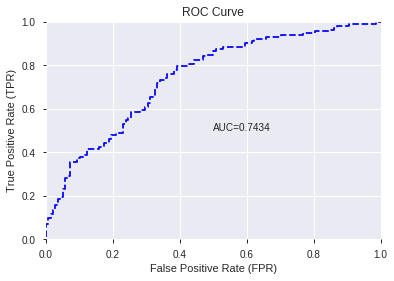

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


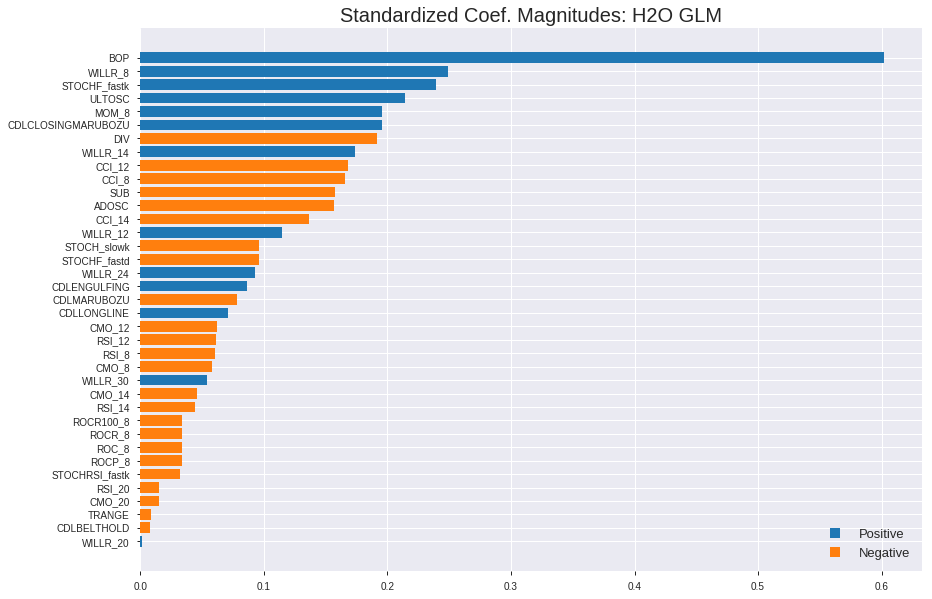

'log_likelihood'
--2019-08-27 18:04:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.124
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.124|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


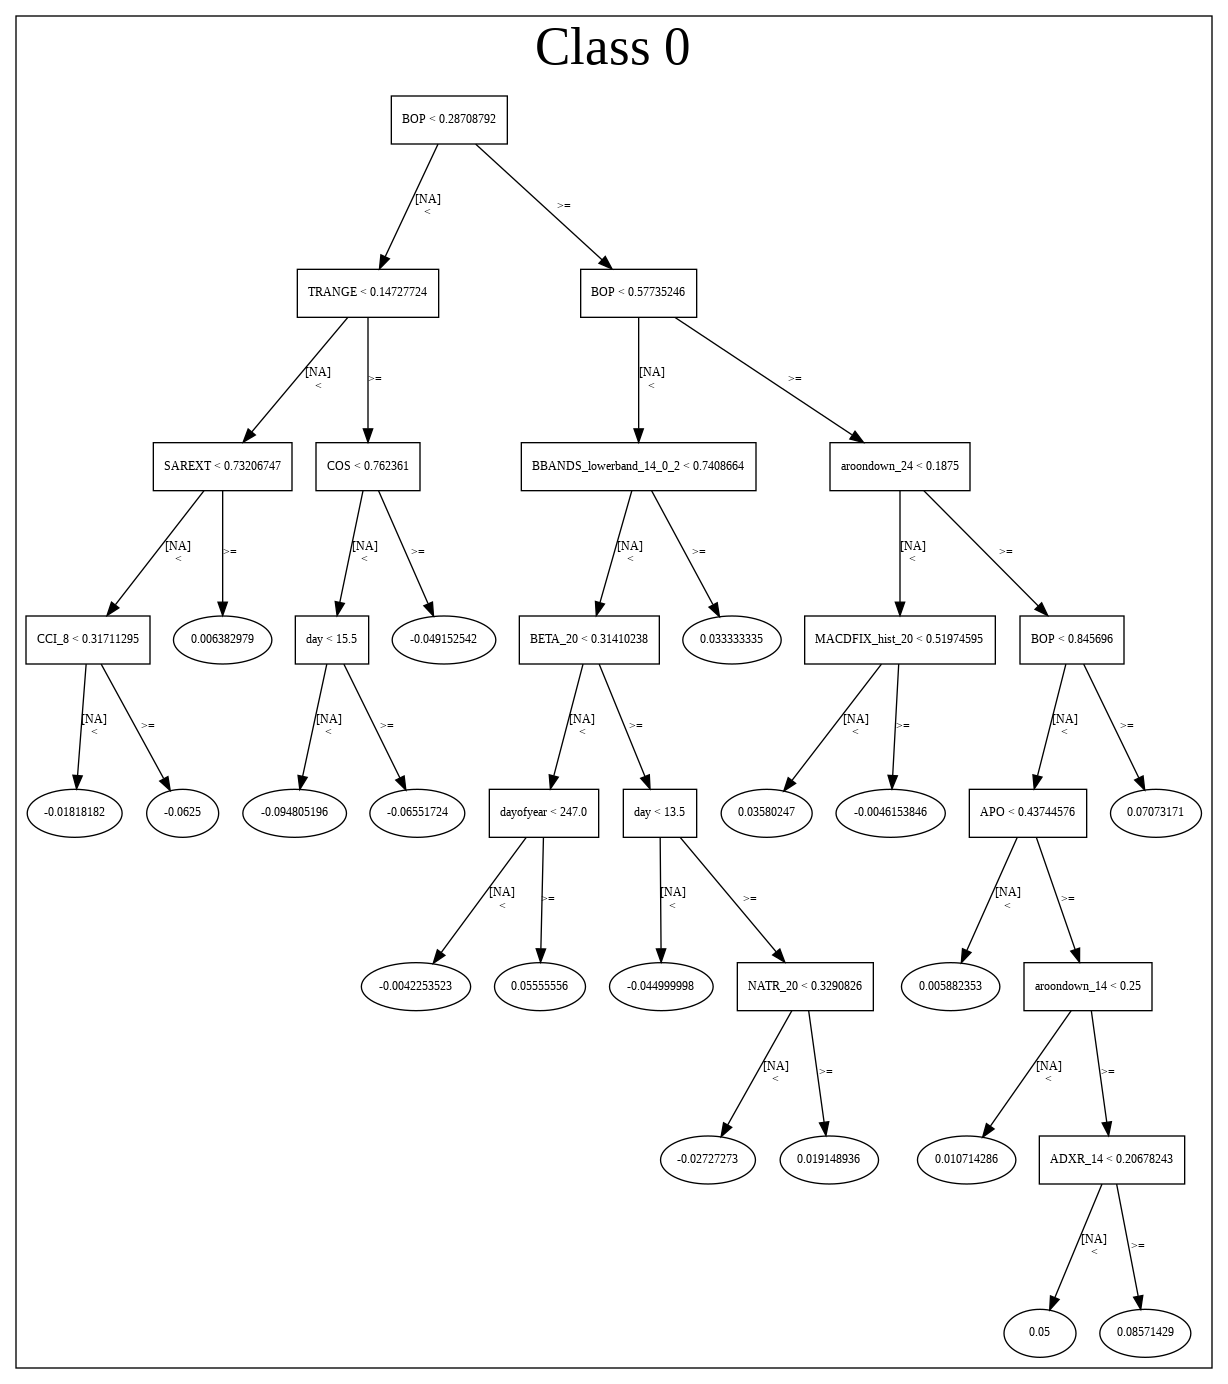

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_180423_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_180423_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_b872',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'WILLR_8',
 'STOCHF_fastk',
 'ULTOSC',
 'MOM_8',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'WILLR_14',
 'CCI_12',
 'CCI_8',
 'SUB',
 'ADOSC',
 'CCI_14',
 'WILLR_12',
 'STOCH_slowk',
 'STOCHF_fastd',
 'WILLR_24',
 'CDLENGULFING',
 'CDLMARUBOZU',
 'CDLLONGLINE',
 'CMO_12',
 'RSI_12',
 'RSI_8',
 'CMO_8',
 'WILLR_30',
 'CMO_14',
 'RSI_14',
 'ROCR100_8',
 'ROCR_8',
 'ROC_8',
 'ROCP_8',
 'STOCHRSI_fastk',
 'RSI_20',
 'CMO_20',
 'TRANGE',
 'CDLBELTHOLD',
 'WILLR_20']

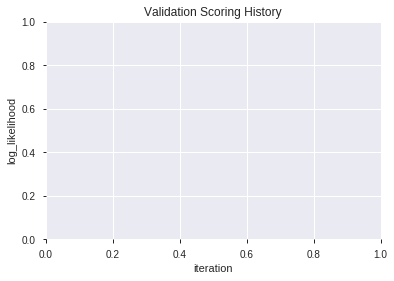

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_180440_model_1  0.736437  0.615716              0.289759  0.463108  0.214469
1               XGBoost_1_AutoML_20190827_180440  0.732910  0.617797              0.317558  0.463836  0.215144
2               XGBoost_3_AutoML_20190827_180440  0.729062  0.623336              0.332884  0.466783  0.217886
3  XGBoost_grid_1_AutoML_20190827_180440_model_4  0.727972  0.617883              0.329646  0.463588  0.214914
4  XGBoost_grid_1_AutoML_20190827_180440_model_2  0.727203  0.626469              0.307105  0.467565  0.218617
5               XGBoost_2_AutoML_20190827_180440  0.726818  0.623588              0.311113  0.465913  0.217075
6  XGBoost_grid_1_AutoML_20190827_180440_model_7  0.710401  0.627676              0.332051  0.468365  0.219365
7  XGBoost_grid_1_AutoML_20190827_180440_model_3  0.708542  0.631782              0.322400  0.471022  0.221862
8  XGBoost_grid_1_AutoML_20190827_180440_model_6  0.704566  0.634995              0.340900  0.471948  0.222735
9  XGBoost_grid_1_AutoML_20190827_180440_model_5  0.692574  0.641899              0.346159  0.474835  0.225468

variable  relative_importance  scaled_importance  percentage
0                  BOP          3255.885986           1.000000    0.385315
1                  DIV           570.261414           0.175148    0.067487
2                  SUB           534.389832           0.164130    0.063242
3         STOCHF_fastk           366.373932           0.112527    0.043358
4          STOCH_slowk           277.510284           0.085233    0.032842
5               ULTOSC           277.040100           0.085089    0.032786
6                ADOSC           269.026001           0.082628    0.031838
7               CMO_20           249.738678           0.076704    0.029555
8              WILLR_8           245.133896           0.075289    0.029010
9               TRANGE           232.690186           0.071468    0.027538
10              CCI_12           215.220413           0.066102    0.025470
11               CCI_8           207.368179           0.063690    0.024541
12               MOM_8           186.914658           0.057408    0.022120
13            WILLR_12           167.989441           0.051596    0.019881
14              CCI_14           167.673691           0.051499    0.019843
15               ROC_8           150.617126           0.046260    0.017825
16            WILLR_20           125.691010           0.038604    0.014875
17            WILLR_24           114.571663           0.035189    0.013559
18            WILLR_14           106.901611           0.032833    0.012651
19      STOCHRSI_fastk           106.730537           0.032781    0.012631
20               CMO_8           106.104462           0.032589    0.012557
21            WILLR_30           100.477982           0.030860    0.011891
22              CMO_12            66.672874           0.020478    0.007890
23              CMO_14            64.916878           0.019938    0.007683
24  CDLCLOSINGMARUBOZU            53.796806           0.016523    0.006367
25         CDLLONGLINE            48.077438           0.014766    0.005690
26        STOCHF_fastd            45.528484           0.013983    0.005388
27              RSI_14            37.582893           0.011543    0.004448
28              ROCP_8            36.878647           0.011327    0.004364
29              RSI_20            32.255642           0.009907    0.003817
30              ROCR_8            11.647312           0.003577    0.001378
31               RSI_8             9.980555           0.003065    0.001181
32              RSI_12             4.199059           0.001290    0.000497
33        CDLENGULFING             2.709369           0.000832    0.000321
34         CDLBELTHOLD             1.375330           0.000422    0.000163

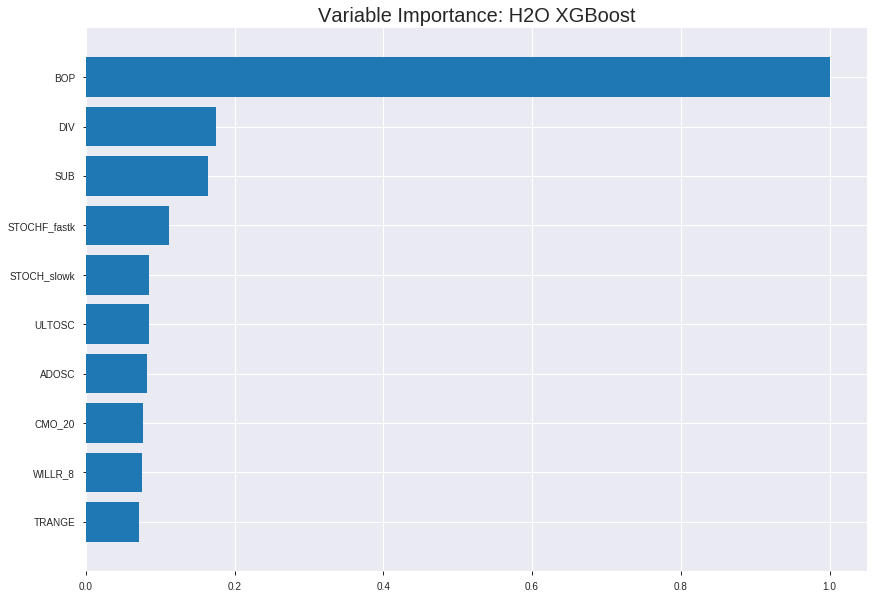

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_180440_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14617046229465866
RMSE: 0.38232245852769187
LogLoss: 0.4583165447889388
Mean Per-Class Error: 0.18374744436196955
AUC: 0.9016883488950528
pr_auc: 0.8956054563174255
Gini: 0.8033766977901056
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4633120000362396: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      620  275   0.3073   (275.0/895.0)
1      71   787   0.0828   (71.0/858.0)
Total  691  1062  0.1974   (346.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.463312     0.819792  217
max f2                       0.314039     0.889822  284
max f0point5                 0.594749     0.823154  144
max accuracy                 0.53071      0.815744  182
max precision                0.901281     1         0
max recall                   0.148337     1         347
max specificity              0.901281     1         0
max absolute_mcc             0.529148     0.632747  183
max min_per_class_accuracy   0.5435       0.811189  175
max mean_per_class_accuracy  0.529148     0.816253  183

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 49.01 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.873574           2.04312    2.04312            1                0.884412   1                           0.884412            0.020979        0.020979                   104.312   104.312
    2        0.0205362                   0.856971           2.04312    2.04312            1                0.864347   1                           0.87438             0.020979        0.041958                   104.312   104.312
    3        0.0302339                   0.84237            2.04312    2.04312            1                0.850094   1                           0.86659             0.0198135       0.0617716                  104.312   104.312
    4        0.040502                    0.827905           2.04312    2.04312            1                0.83557    1                           0.858726            0.020979        0.0827506                  104.312   104.312
    5        0.0501997                   0.818595           1.92294    2.01991            0.941176         0.822835   0.988636                    0.851792            0.018648        0.101399                   92.294    101.991
    6        0.100399                    0.763071           1.97347    1.99669            0.965909         0.790125   0.977273                    0.820959            0.0990676       0.200466                   97.3472   99.6689
    7        0.150029                    0.727828           1.97267    1.98874            0.965517         0.744369   0.973384                    0.795623            0.0979021       0.298368                   97.2671   98.8744
    8        0.200228                    0.701145           1.90382    1.96745            0.931818         0.713797   0.962963                    0.775108            0.0955711       0.393939                   90.382    96.7452
    9        0.300057                    0.639287           1.5878     1.84114            0.777143         0.666105   0.901141                    0.738843            0.158508        0.552448                   58.7799   84.1142
    10       0.399886                    0.589646           1.48272    1.75167            0.725714         0.614203   0.857347                    0.707727            0.148019        0.700466                   48.2724   75.1665
    11       0.500285                    0.539447           1.2073     1.64242            0.590909         0.563848   0.803877                    0.678853            0.121212        0.821678                   20.73     64.242
    12       0.600114                    0.467507           0.887299   1.51681            0.434286         0.50536    0.742395                    0.649992            0.0885781       0.910256                   -11.2701  51.6806
    13       0.699943                    0.369568           0.5137     1.37374            0.251429         0.423502   0.672372                    0.617689            0.0512821       0.961538                   -48.63    37.3738
    14       0.799772                    0.250364           0.30355    1.24016            0.148571         0.318718   0.60699                     0.580371            0.030303        0.991841                   -69.645   24.0156
    15       0.899601                    0.121963           0.0817249  1.1116             0.04             0.179575   0.544071                    0.535895            0.00815851      1                          -91.8275  11.1604
    16       1                           0.0383661          0          1                  0                0.0797094  0.489447  



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.21609357200165255
RMSE: 0.4648586580904486
LogLoss: 0.6180592857941017
Mean Per-Class Error: 0.33340535868625754
AUC: 0.7152597714395468
pr_auc: 0.6522981079103621
Gini: 0.43051954287909355
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3943465054035187: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      96   171  0.6404   (171.0/267.0)
1      23   211  0.0983   (23.0/234.0)
Total  119  382  0.3872   (194.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.394347     0.685065  294
max f2                       0.18351      0.832148  369
max f0point5                 0.575495     0.64695   171
max accuracy                 0.575495     0.668663  171
max precision                0.877056     1         0
max recall                   0.18351      1         369
max specificity              0.877056     1         0
max absolute_mcc             0.517651     0.336678  224
max min_per_class_accuracy   0.547208     0.655431  194
max mean_per_class_accuracy  0.517651     0.666595  224

Gains/Lift Table: Avg response rate: 46.71 %, avg score: 51.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.863311           1.78419   1.78419            0.833333         0.869636  0.833333                    0.869636            0.0213675       0.0213675                  78.4188   78.4188
    2        0.0219561                   0.828921           1.71282   1.75175            0.8              0.837614  0.818182                    0.855081            0.017094        0.0384615                  71.2821   75.1748
    3        0.0319361                   0.817968           0.85641   1.47196            0.4              0.822051  0.6875                      0.844759            0.00854701      0.0470085                  -14.359   47.1955
    4        0.0419162                   0.803674           1.71282   1.5293             0.8              0.809158  0.714286                    0.836282            0.017094        0.0641026                  71.2821   52.9304
    5        0.0518962                   0.794272           2.14103   1.64694            1                0.796602  0.769231                    0.828652            0.0213675       0.0854701                  114.103   64.6943
    6        0.101796                    0.745026           1.28462   1.46933            0.6              0.768206  0.686275                    0.799022            0.0641026       0.149573                   28.4615   46.9331
    7        0.151697                    0.710932           1.62718   1.52126            0.76             0.72467   0.710526                    0.774564            0.0811966       0.230769                   62.7179   52.1255
    8        0.201597                    0.682656           1.62718   1.54747            0.76             0.698364  0.722772                    0.755703            0.0811966       0.311966                   62.7179   54.7474
    9        0.301397                    0.635678           1.24179   1.44626            0.58             0.662767  0.675497                    0.724929            0.123932        0.435897                   24.1795   44.6256
    10       0.401198                    0.585048           1.24179   1.39539            0.58             0.609968  0.651741                    0.696332            0.123932        0.559829                   24.1795   39.5395
    11       0.500998                    0.545311           1.02769   1.32215            0.48             0.565676  0.61753                     0.670305            0.102564        0.662393                   2.76923   32.2147
    12       0.600798                    0.503525           1.02769   1.27323            0.48             0.526561  0.594684                    0.646427            0.102564        0.764957                   2.76923   27.3235
    13       0.700599                    0.450002           0.770769  1.20166            0.36             0.478684  0.561254                    0.622532            0.0769231       0.84188                    -22.9231  20.1658
    14       0.800399                    0.355838           0.81359   1.15327            0.38             0.400905  0.538653                    0.594898            0.0811966       0.923077                   -18.641   15.3271
    15       0.9002                      0.233287           0.556667  1.08713            0.26             0.29689   0.507761                    0.561859            0.0555556       0.978632                   -44.3333  8.71283
    16       1                           0.0511015          0.214103  1                  0.1              0.14128   0.467066                    0.519885         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:04:44  0.013 sec   0                  0.5              0.693147            0.5             0                  1                0.510553                         0.5                0.693147              0.5               0                    1                  0.532934
    2019-08-27 18:04:45  0.114 sec   5                  0.472201         0.638645            0.819506        0.796803           2.04312          0.258985                         0.486344           0.666014              0.699174          0.633907             2.14103            0.383234
    2019-08-27 18:04:45  0.177 sec   10                 0.452165         0.599726            0.826547        0.799136           2.04312          0.248146                         0.479593           0.652209              0.690483          0.634145             1.78419            0.429142
    2019-08-27 18:04:45  0.240 sec   15                 0.438051         0.571682            0.835655        0.815737           2.04312          0.24016                          0.474827           0.642                 0.695981          0.638149             1.78419            0.41517
    2019-08-27 18:04:45  0.311 sec   20                 0.426979         0.549269            0.846619        0.828679           2.04312          0.239589                         0.470987           0.633609              0.703896          0.642658             1.78419            0.38523
    2019-08-27 18:04:45  0.389 sec   25                 0.419199         0.5329              0.853014        0.837302           2.04312          0.224187                         0.468866           0.628526              0.705856          0.645259             1.78419            0.409182
    2019-08-27 18:04:45  0.457 sec   30                 0.412602         0.518697            0.859635        0.845953           2.04312          0.217912                         0.467542           0.625035              0.710394          0.648245             1.78419            0.399202
    2019-08-27 18:04:45  0.542 sec   35                 0.406402         0.505871            0.867596        0.853643           2.04312          0.211067                         0.466505           0.622485              0.712075          0.651044             2.14103            0.401198
    2019-08-27 18:04:45  0.606 sec   40                 0.40081          0.494566            0.875709        0.863243           2.04312          0.206503                         0.46573            0.620498              0.713051          0.651089             1.78419            0.389222
    2019-08-27 18:04:45  0.675 sec   45                 0.396214         0.484982            0.881806        0.872126           2.04312          0.198517                         0.465082           0.618917              0.714676          0.650736             1.78419            0.399202
    2019-08-27 18:04:45  0.744 sec   50                 0.390586         0.474234            0.889835        0.880946           2.04312          0.201369                         0.464584           0.617815              0.716556          0.65285              1.78419            0.407186
    2019-08-27 18:04:45  0.811 sec   55                 0.386712         0.466531            0.894997        0.888235           2.04312          0.199658                         0.465257           0.619046              0.714027          0.6

Variable Importances: 


variable      relative_importance    scaled_importance       percentage
------------  ---------------------  ----------------------  ----------------------
BOP           3255.885986328125      1.0                     0.3853150349462792
DIV           570.2614135742188      0.1751478448473989      0.06748709795814099
SUB           534.3898315429688      0.1641303884063935      0.0632419063445559
STOCHF_fastk  366.3739318847656      0.11252664664033565     0.04335820878260854
STOCH_slowk   277.5102844238281      0.08523341590864322     0.03284171662942961
---           ---                    ---                     ---
ROCR_8        11.64731216430664      0.003577309590451008    0.0013783911698582898
RSI_8         9.980554580688477      0.003065388229992721    0.0011811401729635584
RSI_12        4.19905948638916       0.0012896825945446307   0.0004969340939865724
CDLENGULFING  2.7093687057495117     0.0008321448346552957   0.00032063791604557097
CDLBELTHOLD   1.3753304481506348     0.00042241357772533205  0.00016276230246301915


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7051792828685259)

('F1', 0.6991869918699186)

('auc', 0.7364370911889189)

('logloss', 0.6157157964204341)

('mean_per_class_error', 0.2897588816211363)

('rmse', 0.4631077196941261)

('mse', 0.2144687600402933)

xgboost prediction progress: |████████████████████████████████████████████| 100%


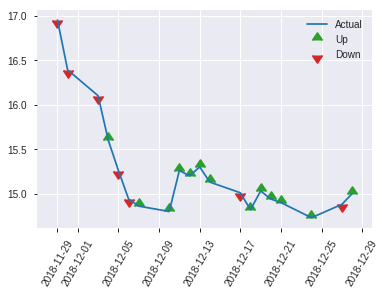


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2144687600402933
RMSE: 0.4631077196941261
LogLoss: 0.6157157964204341
Mean Per-Class Error: 0.2897588816211363
AUC: 0.7364370911889189
pr_auc: 0.6633216291822803
Gini: 0.47287418237783774
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5478700399398804: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      91   47   0.3406   (47.0/138.0)
1      27   86   0.2389   (27.0/113.0)
Total  118  133  0.2948   (74.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.54787      0.699187  132
max f2                       0.225714     0.816327  233
max f0point5                 0.585158     0.671256  116
max accuracy                 0.585158     0.705179  116
max precision                0.865527     1         0
max recall                   0.179241     1         240
max specificity              0.865527     1         0
max absolute_mcc             0.54787      0.41914   132
max min_per_class_accuracy   0.585158     0.690265  116
max mean_per_class_accuracy  0.54787      0.710241  132

Gains/Lift Table: Avg response rate: 45.02 %, avg score: 52.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.827068           2.22124   2.22124            1                0.853036  1                           0.853036            0.0265487       0.0265487                  122.124   122.124
    2        0.0239044                   0.81753            1.48083   1.85103            0.666667         0.820531  0.833333                    0.836784            0.0176991       0.0442478                  48.0826   85.1032
    3        0.0318725                   0.787672           2.22124   1.94358            1                0.79348   0.875                       0.825958            0.0176991       0.0619469                  122.124   94.3584
    4        0.0438247                   0.778799           2.22124   2.01931            1                0.781493  0.909091                    0.813831            0.0265487       0.0884956                  122.124   101.931
    5        0.0517928                   0.775059           2.22124   2.05037            1                0.777129  0.923077                    0.808185            0.0176991       0.106195                   122.124   105.037
    6        0.103586                    0.733561           1.19605   1.62321            0.538462         0.752237  0.730769                    0.780211            0.0619469       0.168142                   19.6052   62.3213
    7        0.151394                    0.696886           1.11062   1.46134            0.5              0.714204  0.657895                    0.759366            0.0530973       0.221239                   11.0619   46.1341
    8        0.203187                    0.668653           1.36692   1.43727            0.615385         0.683896  0.647059                    0.740129            0.0707965       0.292035                   36.6916   43.7272
    9        0.302789                    0.637136           1.51044   1.46134            0.68             0.650193  0.657895                    0.710545            0.150442        0.442478                   51.0442   46.1341
    10       0.40239                     0.601803           1.51044   1.4735             0.68             0.61788   0.663366                    0.687608            0.150442        0.59292                    51.0442   47.3495
    11       0.501992                    0.559703           1.15504   1.41031            0.52             0.586778  0.634921                    0.667602            0.115044        0.707965                   15.5044   41.031
    12       0.601594                    0.521493           0.977345  1.33863            0.44             0.537541  0.602649                    0.646069            0.0973451       0.80531                    -2.26549  33.8627
    13       0.701195                    0.465716           0.710796  1.24945            0.32             0.49357   0.5625                      0.624407            0.0707965       0.876106                   -28.9204  24.9447
    14       0.800797                    0.379691           0.533097  1.16035            0.24             0.420085  0.522388                    0.598994            0.0530973       0.929204                   -46.6903  16.0349
    15       0.900398                    0.26477            0.444248  1.08113            0.2              0.319342  0.486726                    0.568059            0.0442478       0.973451                   -55.5752  8.1134
    16       1                           0.0492246          0.266549  1                  0.12             0.173207  0.450199                    0.528731           

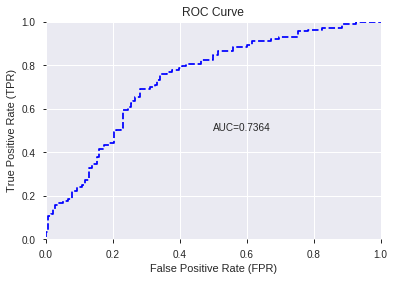

This function is available for GLM models only


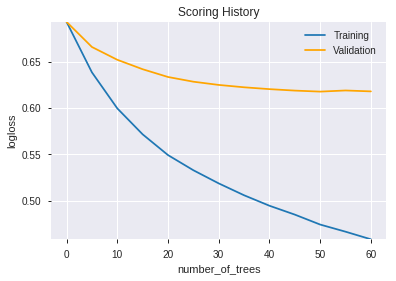

--2019-08-27 18:05:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.9.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.9.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

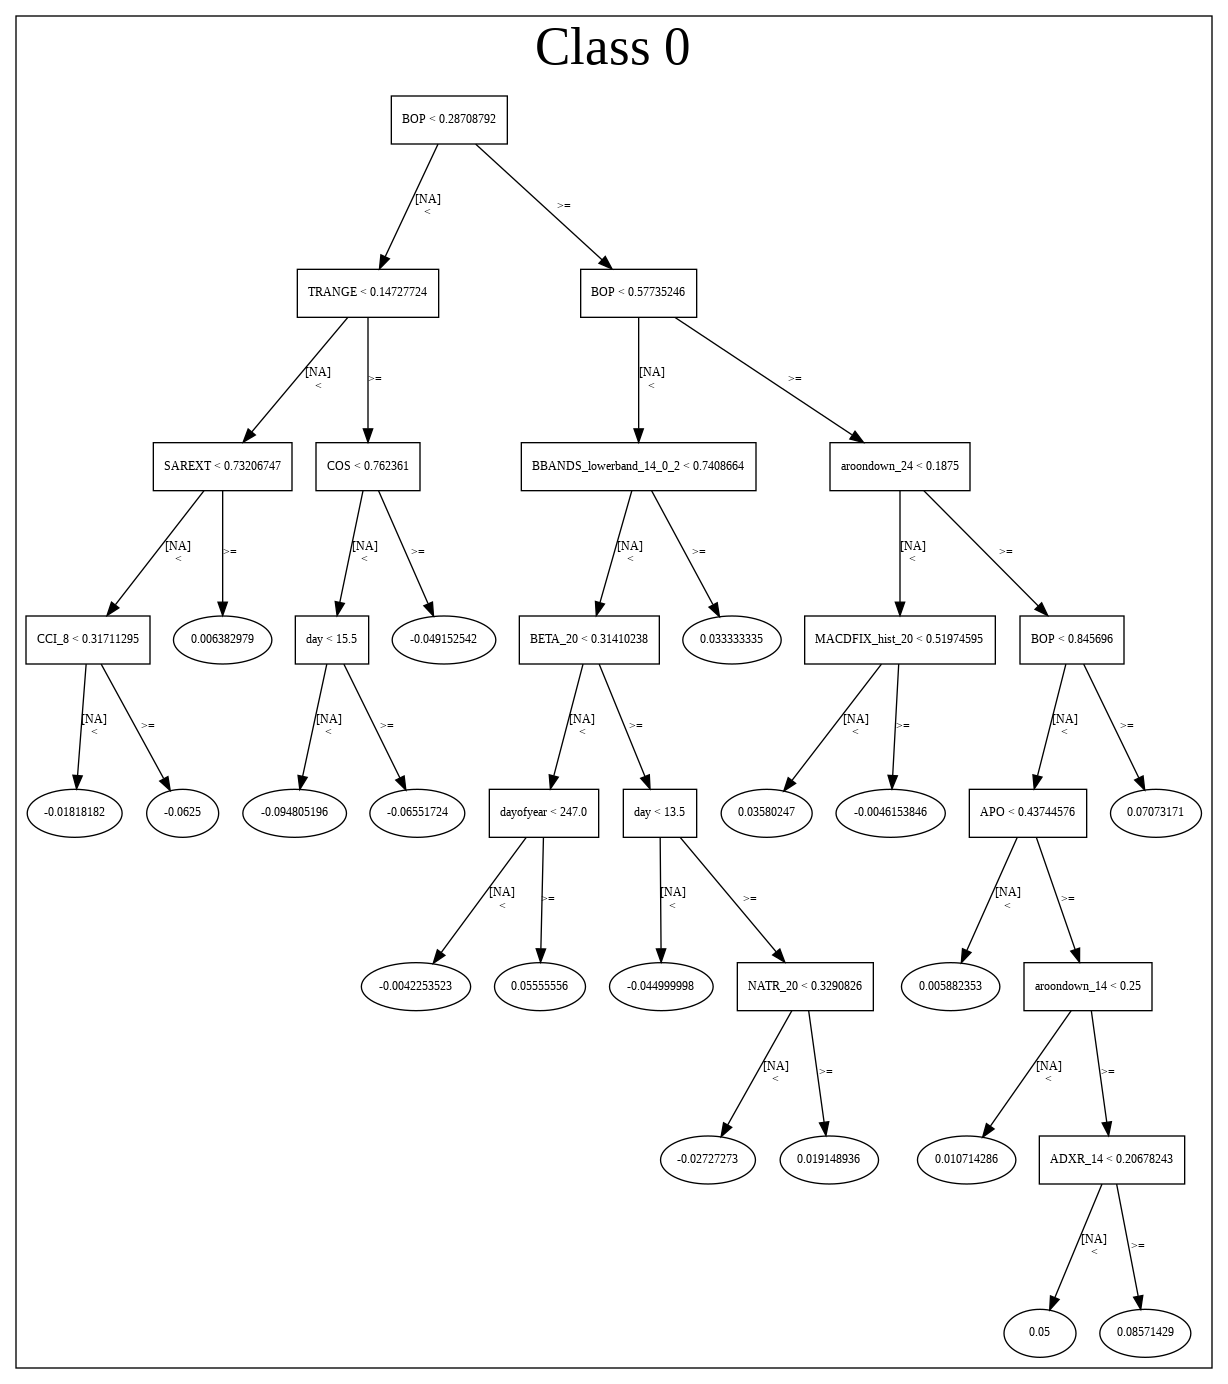

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_180440_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_180440_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_b872',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'SUB',
 'STOCHF_fastk',
 'STOCH_slowk',
 'ULTOSC',
 'ADOSC',
 'CMO_20',
 'WILLR_8',
 'TRANGE',
 'CCI_12',
 'CCI_8',
 'MOM_8',
 'WILLR_12',
 'CCI_14',
 'ROC_8',
 'WILLR_20',
 'WILLR_24',
 'WILLR_14',
 'STOCHRSI_fastk',
 'CMO_8',
 'WILLR_30',
 'CMO_12',
 'CMO_14',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'STOCHF_fastd',
 'RSI_14',
 'ROCP_8',
 'RSI_20',
 'ROCR_8',
 'RSI_8',
 'RSI_12',
 'CDLENGULFING',
 'CDLBELTHOLD']

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

73

['BBANDS_upperband_14_5_4',
 'BBANDS_upperband_14_6_4',
 'TRIMA_20',
 'BBANDS_upperband_20_0_2',
 'BBANDS_middleband_20_1_5',
 'BBANDS_lowerband_20_2_4',
 'BBANDS_lowerband_24_7_4',
 'BOP',
 'CCI_8',
 'CMO_8',
 'MFI_8',
 'ROCP_8',
 'ROCR_8',
 'TRIX_8',
 'WILLR_8',
 'ADX_12',
 'aroonup_12',
 'CMO_12',
 'DX_12',
 'MOM_12',
 'ROCP_12',
 'ROCR_12',
 'aroonup_14',
 'AROONOSC_14',
 'CCI_14',
 'MOM_14',
 'PLUS_DI_14',
 'PLUS_DM_14',
 'ROC_14',
 'ROCR_14',
 'ROCR100_14',
 'WILLR_14',
 'aroonup_20',
 'DX_20',
 'MACDFIX_20',
 'MFI_20',
 'MINUS_DI_20',
 'PLUS_DI_20',
 'RSI_20',
 'aroondown_24',
 'MACDFIX_hist_24',
 'PLUS_DM_24',
 'ROCR100_24',
 'CCI_30',
 'MFI_30',
 'MINUS_DI_30',
 'MINUS_DM_30',
 'ROCR_30',
 'WILLR_30',
 'MACD',
 'MACDEXT_hist',
 'PPO',
 'STOCH_slowk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ADOSC',
 'ATR_12',
 'NATR_12',
 'ATR_20',
 'TRANGE',
 'HT_PHASOR_inphase',
 'HT_PHASOR_quadrature',
 'CDLLONGLEGGEDDOJI',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'CORREL_8',
 'LIN

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_180630_model_9  0.720854  0.633348              0.338912  0.470383  0.221260
1  DeepLearning_grid_1_AutoML_20190827_180630_model_8  0.717391  0.619424              0.357445  0.464422  0.215688
2  DeepLearning_grid_1_AutoML_20190827_180630_model_6  0.712646  0.643149              0.320380  0.475859  0.226441
3  DeepLearning_grid_1_AutoML_20190827_180630_model_7  0.693792  0.653480              0.349782  0.478473  0.228937
4  DeepLearning_grid_1_AutoML_20190827_180630_model_5  0.686354  0.642534              0.344940  0.475410  0.226014
5  DeepLearning_grid_1_AutoML_20190827_180630_model_3  0.682057  0.787606              0.351385  0.522550  0.273058
6  DeepLearning_grid_1_AutoML_20190827_180630_model_2  0.615621  0.893698              0.413813  0.547748  0.300028
7  DeepLearning_grid_1_AutoML_20190827_180630_model_1  0.603886  1.012854              0.489130  0.559554  0.313101
8               DeepLearning_1_AutoML_20190827_180630  0.582532  0.813327              0.438374  0.538622  0.290114
9  DeepLearning_grid_1_AutoML_20190827_180630_model_4  0.566372  0.957053              0.452482  0.567995  0.322618

variable  relative_importance  scaled_importance  percentage
0                        BOP             1.000000           1.000000    0.029622
1                     TRANGE             0.667138           0.667138    0.019762
2                CDLLONGLINE             0.649315           0.649315    0.019234
3                    WILLR_8             0.516583           0.516583    0.015302
4                   WILLR_14             0.482730           0.482730    0.014300
..                       ...                  ...                ...         ...
68                       PPO             0.430225           0.430225    0.012744
69                   ROCR_30             0.429679           0.429679    0.012728
70  BBANDS_middleband_20_1_5             0.427749           0.427749    0.012671
71         CDLLONGLEGGEDDOJI             0.426095           0.426095    0.012622
72        LINEARREG_SLOPE_14             0.416390           0.416390    0.012335

[73 rows x 4 columns]

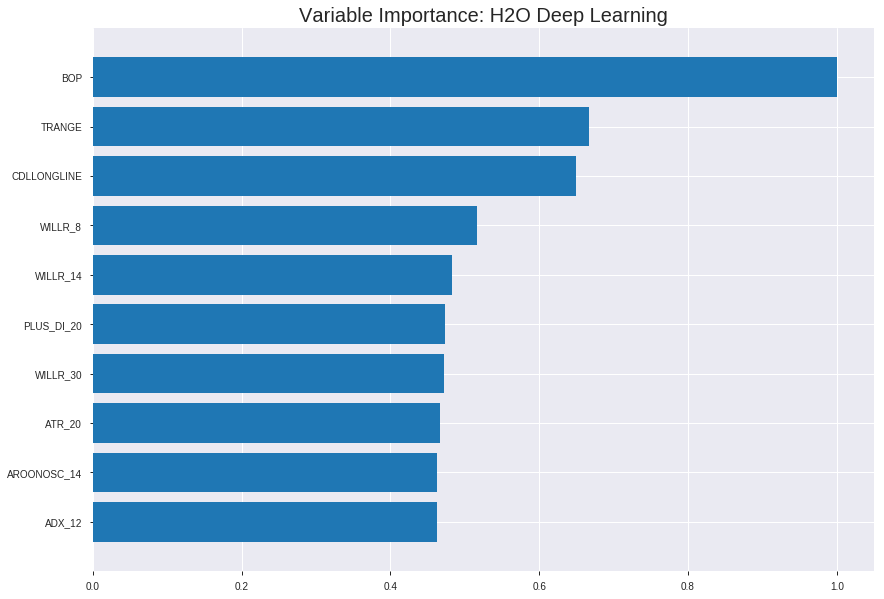

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_180630_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20532918254323135
RMSE: 0.45313263239721696
LogLoss: 0.5957173158533734
Mean Per-Class Error: 0.3202920915211418
AUC: 0.7432752536104491
pr_auc: 0.7157357712418596
Gini: 0.4865505072208982
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39499014167220775: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      366  529   0.5911   (529.0/895.0)
1      78   780   0.0909   (78.0/858.0)
Total  444  1309  0.3463   (607.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.39499      0.719889  258
max f2                       0.305838     0.841665  302
max f0point5                 0.527948     0.666984  173
max accuracy                 0.478871     0.677695  206
max precision                0.820606     1         0
max recall                   0.126125     1         379
max specificity              0.820606     1         0
max absolute_mcc             0.425584     0.371359  240
max min_per_class_accuracy   0.520098     0.665501  178
max mean_per_class_accuracy  0.478871     0.679708  206

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 49.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.79551            1.92962   1.92962            0.944444         0.808439  0.944444                    0.808439            0.0198135       0.0198135                  92.9617   92.9617
    2        0.0205362                   0.778921           1.92962   1.92962            0.944444         0.785943  0.944444                    0.797191            0.0198135       0.039627                   92.9617   92.9617
    3        0.0302339                   0.771851           1.56239   1.81183            0.764706         0.77536   0.886792                    0.790189            0.0151515       0.0547786                  56.2389   81.1827
    4        0.040502                    0.762928           1.81611   1.81291            0.888889         0.767357  0.887324                    0.7844              0.018648        0.0734266                  81.611    81.2912
    5        0.0501997                   0.745284           1.56239   1.76452            0.764706         0.755639  0.863636                    0.778844            0.0151515       0.0885781                  56.2389   76.4516
    6        0.100399                    0.707149           1.53234   1.64843            0.75             0.72161   0.806818                    0.750227            0.0769231       0.165501                   53.2343   64.8429
    7        0.150029                    0.681672           1.57344   1.62362            0.770115         0.694373  0.794677                    0.731751            0.0780886       0.24359                    57.344    62.3623
    8        0.200228                    0.659033           1.39304   1.56581            0.681818         0.671115  0.766382                    0.716549            0.0699301       0.31352                    39.3039   56.5813
    9        0.300057                    0.606816           1.27257   1.46825            0.622857         0.632458  0.718631                    0.688572            0.12704         0.440559                   27.2574   46.8252
    10       0.399886                    0.563894           1.17917   1.39609            0.577143         0.586204  0.68331                     0.663016            0.117716        0.558275                   17.9174   39.6086
    11       0.500285                    0.518263           1.13765   1.34422            0.556818         0.540034  0.657925                    0.638336            0.114219        0.672494                   13.7648   34.4222
    12       0.600114                    0.472488           1.08577   1.30123            0.531429         0.496091  0.636882                    0.614673            0.108392        0.780886                   8.57742   30.1229
    13       0.699943                    0.422201           0.933999  1.24885            0.457143         0.447739  0.611247                    0.590864            0.0932401       0.874126                   -6.60007  24.8853
    14       0.799772                    0.338999           0.63045   1.17166            0.308571         0.386302  0.573466                    0.565331            0.0629371       0.937063                   -36.955   17.1663
    15       0.899601                    0.227082           0.408625  1.08699            0.2              0.287707  0.532023                    0.534523            0.0407925       0.977855                   -59.1375  8.69884
    16       1                           0.059803           0.220564  1                  0.107955         0.153435  0.489447                    0.496262         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21074925743350348
RMSE: 0.45907434848127104
LogLoss: 0.6086476800705629
Mean Per-Class Error: 0.30591568232017674
AUC: 0.7469349210922245
pr_auc: 0.6791251050273251
Gini: 0.49386984218444896
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4948973975302132: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      147  120  0.4494   (120.0/267.0)
1      38   196  0.1624   (38.0/234.0)
Total  185  316  0.3154   (158.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.494897     0.712727  238
max f2                       0.230328     0.830956  364
max f0point5                 0.58201      0.675047  157
max accuracy                 0.58201      0.692615  157
max precision                0.799926     1         0
max recall                   0.204888     1         372
max specificity              0.799926     1         0
max absolute_mcc             0.494897     0.401287  238
max min_per_class_accuracy   0.553853     0.683761  183
max mean_per_class_accuracy  0.494897     0.694084  238

Gains/Lift Table: Avg response rate: 46.71 %, avg score: 52.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.771159           1.78419   1.78419            0.833333         0.785396  0.833333                    0.785396            0.0213675       0.0213675                  78.4188   78.4188
    2        0.0219561                   0.758353           1.28462   1.55711            0.6              0.760251  0.727273                    0.773967            0.0128205       0.034188                   28.4615   55.711
    3        0.0319361                   0.751655           1.71282   1.60577            0.8              0.753473  0.75                        0.767563            0.017094        0.0512821                  71.2821   60.5769
    4        0.0419162                   0.74453            2.14103   1.73321            1                0.747057  0.809524                    0.76268             0.0213675       0.0726496                  114.103   73.3211
    5        0.0518962                   0.730891           0.85641   1.5646             0.4              0.736541  0.730769                    0.757653            0.00854701      0.0811966                  -14.359   56.4596
    6        0.101796                    0.696398           1.54154   1.55329            0.72             0.713411  0.72549                     0.735966            0.0769231       0.15812                    54.1538   55.3293
    7        0.151697                    0.682311           1.79846   1.63394            0.84             0.688768  0.763158                    0.72044             0.0897436       0.247863                   79.8462   63.3941
    8        0.201597                    0.664118           1.54154   1.61107            0.72             0.673236  0.752475                    0.708756            0.0769231       0.324786                   54.1538   61.1069
    9        0.301397                    0.628376           1.28462   1.50297            0.6              0.643923  0.701987                    0.687288            0.128205        0.452991                   28.4615   50.2972
    10       0.401198                    0.585616           1.41308   1.48061            0.66             0.606656  0.691542                    0.66723             0.141026        0.594017                   41.3077   48.061
    11       0.500998                    0.549694           1.07051   1.39892            0.5              0.568793  0.653386                    0.647621            0.106838        0.700855                   7.05128   39.8917
    12       0.600798                    0.504654           1.02769   1.33725            0.48             0.525676  0.624585                    0.627365            0.102564        0.803419                   2.76923   33.7252
    13       0.700599                    0.460015           0.770769  1.25656            0.36             0.483258  0.586895                    0.606837            0.0769231       0.880342                   -22.9231  25.6556
    14       0.800399                    0.408615           0.428205  1.15327            0.2              0.432539  0.538653                    0.585104            0.042735        0.923077                   -57.1795  15.3271
    15       0.9002                      0.267653           0.556667  1.08713            0.26             0.335668  0.507761                    0.55745             0.0555556       0.978632                   -44.3333  8.71283
    16       1                           0.0460044          0.214103  1                  0.1              0.187865  0.467066                    0.520565           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:13:31  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 18:13:32  2 min 24.243 sec  514 obs/sec       0.548774  1             962        0.686873         2.40727             -0.88802       0.691873        0.647633           1.5891           0.397604                         0.668267           2.13202               -0.794106        0.688354          0.634447             1.78419            0.38523
    2019-08-27 18:13:42  2 min 34.129 sec  830 obs/sec       5.13976   9             9010       0.453133         0.595717            0.178317       0.743275        0.715736           1.92962          0.346264                         0.459074           0.608648              0.15333          0.746935          0.679125             1.78419            0.315369
    2019-08-27 18:13:52  2 min 43.527 sec  979 obs/sec       10.7981   19            18929      0.45348          0.596802            0.177059       0.759065        0.730462           1.92962          0.318882                         0.468848           0.627947              0.116895         0.739276          0.653621             1.07051            0.305389
    2019-08-27 18:14:02  2 min 53.424 sec  1088 obs/sec      17.5859   31            30828      0.448461         0.587272            0.195171       0.763239        0.731716           1.7026           0.322875                         0.463164           0.61755               0.138176         0.741557          0.655276             1.07051            0.345309
    2019-08-27 18:14:11  3 min  3.252 sec  1175 obs/sec      24.9766   44            43784      0.446574         0.583092            0.201932       0.766556        0.735859           1.7026           0.326868                         0.465146           0.623099              0.130787         0.726632          0.637378             0.356838           0.357285
    2019-08-27 18:14:21  3 min 12.455 sec  1246 obs/sec      32.3628   57            56732      0.442502         0.572447            0.216421       0.772049        0.744791           1.92962          0.310896                         0.46214            0.613815              0.141983         0.741381          0.64934              0.713675           0.315369
    2019-08-27 18:14:30  3 min 22.010 sec  1302 obs/sec      40.2647   71            70584      0.441948         0.573455            0.218378       0.775454        0.748673           1.81611          0.324016                         0.466278           0.62504               0.126551         0.723111          0.643653             1.07051            0.347305
    2019-08-27 18:14:31  3 min 22.954 sec  1302 obs/sec      40.2647   71            70584      0.453133         0.595717            0.178317       0.743275        0.715736           1.92962          0.346264                         0.459074           0.608648              0.15333          0.746935          0.679125             1.78419            0.315369

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
BOP                       1.0                    1.0                  0.02962249004351216
TRANGE                    0.667138397693634      0.667138397693634    0.01976230054332433
CDLLONGLINE               0.6493148803710938     0.6493148803710938   0.019234323578897015
WILLR_8                   0.5165830254554749     0.5165830254554749   0.015302475528202193
WILLR_14                  0.4827302098274231     0.4827302098274231   0.014299670834315378
---                       ---                    ---                  ---
PPO                       0.4302248954772949     0.4302248954772949   0.012744332682747229
ROCR_30                   0.42967909574508667    0.42967909574508667  0.01272816473561414
BBANDS_middleband_20_1_5  0.4277487099170685     0.4277487099170685   0.012670981900643533
CDLLONGLEGGEDDOJI         0.4260946810245514     0.4260946810245514   0.012621985446243263
LINEARREG_SLOPE_14        0.4163897633552551     0.4163897633552551   0.01233450161921143


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6812749003984063)

('F1', 0.6830985915492959)

('auc', 0.7208541746825702)

('logloss', 0.6333482660029992)

('mean_per_class_error', 0.3147043734769783)

('rmse', 0.47038309804179584)

('mse', 0.2212602589233977)

deeplearning prediction progress: |███████████████████████████████████████| 100%


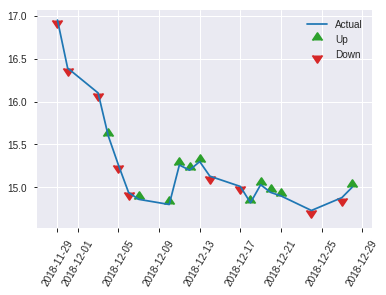


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2212602589233977
RMSE: 0.47038309804179584
LogLoss: 0.6333482660029992
Mean Per-Class Error: 0.3147043734769783
AUC: 0.7208541746825702
pr_auc: 0.6423425137559533
Gini: 0.44170834936514036
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46462262510498775: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   74   0.5362   (74.0/138.0)
1      16   97   0.1416   (16.0/113.0)
Total  80   171  0.3586   (90.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.464623     0.683099  170
max f2                       0.265197     0.812772  236
max f0point5                 0.526927     0.643642  130
max accuracy                 0.526927     0.681275  130
max precision                0.736118     0.875     7
max recall                   0.176562     1         248
max specificity              0.775867     0.992754  0
max absolute_mcc             0.526927     0.369103  130
max min_per_class_accuracy   0.5384       0.672566  119
max mean_per_class_accuracy  0.526927     0.685296  130

Gains/Lift Table: Avg response rate: 45.02 %, avg score: 51.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.761599           1.48083   1.48083            0.666667         0.768533  0.666667                    0.768533            0.0176991       0.0176991                  48.0826   48.0826
    2        0.0239044                   0.751227           2.22124   1.85103            1                0.756456  0.833333                    0.762495            0.0265487       0.0442478                  122.124   85.1032
    3        0.0318725                   0.730623           2.22124   1.94358            1                0.740487  0.875                       0.756993            0.0176991       0.0619469                  122.124   94.3584
    4        0.0438247                   0.698505           1.48083   1.81738            0.666667         0.707937  0.818182                    0.743614            0.0176991       0.079646                   48.0826   81.7377
    5        0.0517928                   0.693528           1.11062   1.70865            0.5              0.694584  0.769231                    0.736071            0.00884956      0.0884956                  11.0619   70.8645
    6        0.103586                    0.668742           1.19605   1.45235            0.538462         0.677432  0.653846                    0.706752            0.0619469       0.150442                   19.6052   45.2349
    7        0.151394                    0.652402           2.03614   1.6367             0.916667         0.66034   0.736842                    0.692095            0.0973451       0.247788                   103.614   63.6702
    8        0.203187                    0.641018           1.19605   1.52438            0.538462         0.645465  0.686275                    0.680209            0.0619469       0.309735                   19.6052   52.438
    9        0.302789                    0.604479           1.33274   1.46134            0.6              0.622774  0.657895                    0.661316            0.132743        0.442478                   33.2743   46.1341
    10       0.40239                     0.568726           1.24389   1.40752            0.56             0.587416  0.633663                    0.643024            0.123894        0.566372                   24.3894   40.7518
    11       0.501992                    0.534214           1.15504   1.35742            0.52             0.549092  0.611111                    0.624386            0.115044        0.681416                   15.5044   35.7424
    12       0.601594                    0.496138           1.06619   1.30921            0.48             0.515484  0.589404                    0.606356            0.106195        0.787611                   6.61947   30.9207
    13       0.701195                    0.458203           0.799646  1.23683            0.36             0.47761   0.556818                    0.588068            0.079646        0.867257                   -20.0354  23.6826
    14       0.800797                    0.420584           0.533097  1.1493             0.24             0.439724  0.517413                    0.569618            0.0530973       0.920354                   -46.6903  14.9298
    15       0.900398                    0.338994           0.533097  1.08113            0.24             0.381039  0.486726                    0.548757            0.0530973       0.973451                   -46.6903  8.1134
    16       1                           0.120385           0.266549  1                  0.12             0.254     0.450199                    0.519399           

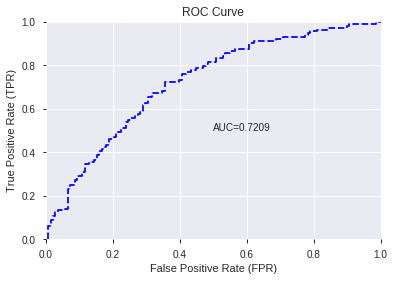

This function is available for GLM models only


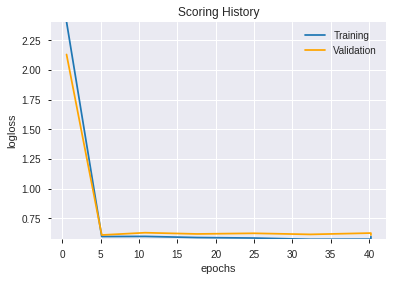

--2019-08-27 18:14:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.129.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.129.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


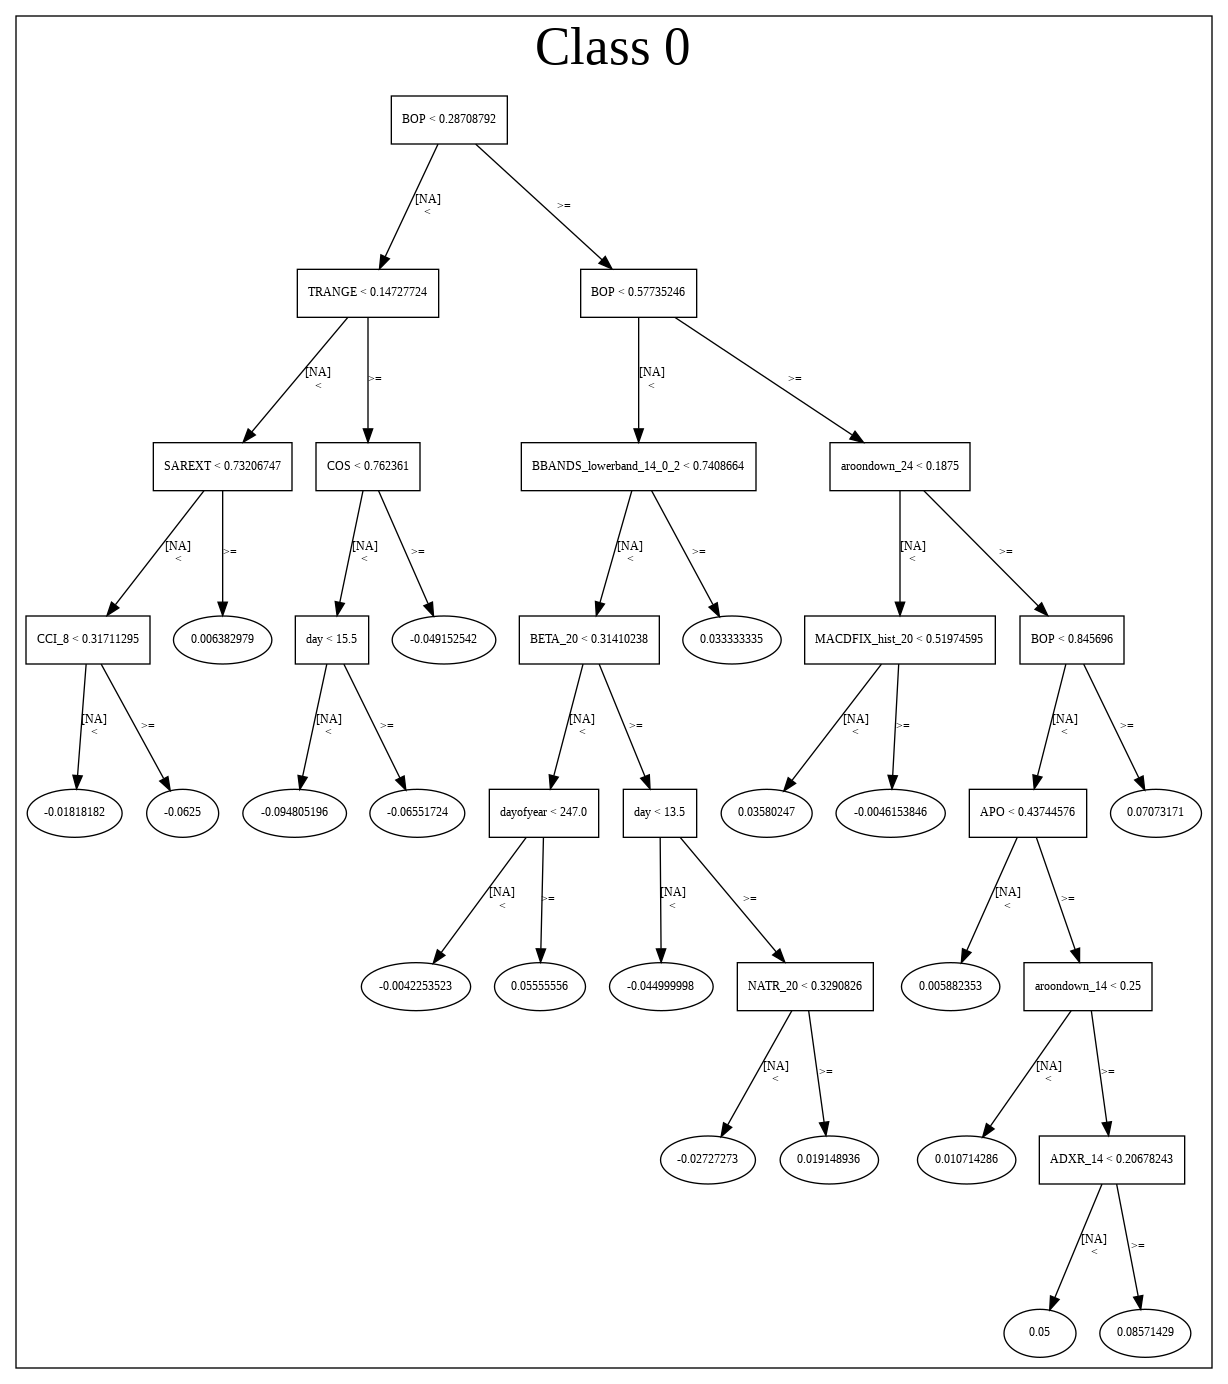

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_180630_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_180630_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_b872',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'TRANGE',
 'CDLLONGLINE',
 'WILLR_8',
 'WILLR_14',
 'PLUS_DI_20',
 'WILLR_30',
 'ATR_20',
 'AROONOSC_14',
 'ADX_12',
 'RSI_20',
 'MACDFIX_20',
 'BBANDS_lowerband_20_2_4',
 'CCI_8',
 'STOCHRSI_fastk',
 'aroonup_12',
 'PLUS_DI_14',
 'HT_PHASOR_quadrature',
 'TRIX_8',
 'MACD',
 'DX_12',
 'ROCR_14',
 'STOCHF_fastd',
 'ROCP_8',
 'ROCR_8',
 'LINEARREG_SLOPE_8',
 'aroonup_20',
 'aroondown_24',
 'MACDEXT_hist',
 'MINUS_DM_30',
 'CORREL_12',
 'MINUS_DI_30',
 'STDDEV_12',
 'STOCHRSI_fastd',
 'MACDFIX_hist_24',
 'CMO_12',
 'MOM_14',
 'BBANDS_upperband_14_5_4',
 'CCI_14',
 'LINEARREG_SLOPE_12',
 'MOM_12',
 'ROCR_12',
 'ATR_12',
 'ROCP_12',
 'PLUS_DM_14',
 'HT_PHASOR_inphase',
 'CORREL_8',
 'MFI_8',
 'ROC_14',
 'BBANDS_upperband_14_6_4',
 'CCI_30',
 'PLUS_DM_24',
 'ROCR100_14',
 'aroonup_14',
 'ADOSC',
 'STOCH_slowk',
 'MFI_30',
 'TRIMA_20',
 'MFI_20',
 'CMO_8',
 'BBANDS_lowerband_24_7_4',
 'VAR_12',
 'NATR_12',
 'CDLSHORTLINE',
 'ROCR100_24',
 'MINUS_DI_20',
 'BBANDS_upperband_20_0_2',
 '

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190827_181449_model_1  0.74984  0.596107              0.295819  0.45104  0.203438

variable  relative_importance  scaled_importance  percentage
0            BOP             0.720543           1.000000    0.125350
1         TRANGE             0.349538           0.485103    0.060808
2       WILLR_14             0.273051           0.378951    0.047501
3          CCI_8             0.268126           0.372116    0.046645
4        WILLR_8             0.263649           0.365903    0.045866
..           ...                  ...                ...         ...
68  STOCHF_fastd             0.008395           0.011651    0.001460
69         DX_12             0.006450           0.008952    0.001122
70        MFI_20             0.004599           0.006382    0.000800
71    PLUS_DM_14             0.002807           0.003896    0.000488
72      CORREL_8             0.002482           0.003445    0.000432

[73 rows x 4 columns]

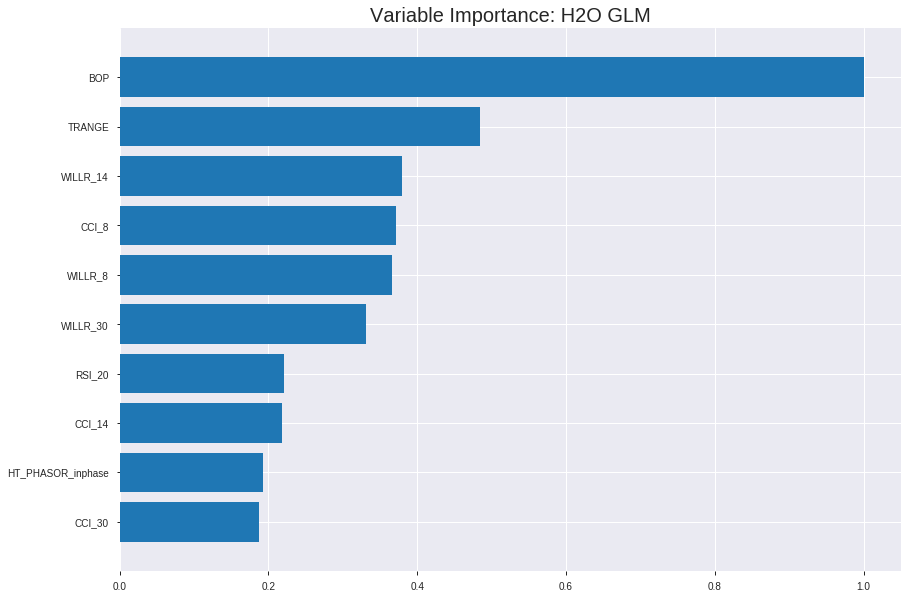

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_181449_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19767258890558706
RMSE: 0.44460385615240344
LogLoss: 0.5781561676261929
Null degrees of freedom: 1752
Residual degrees of freedom: 1679
Null deviance: 2429.39301010051
Residual deviance: 2027.0155236974322
AIC: 2175.0155236974324
AUC: 0.7626681512156372
pr_auc: 0.7294937520626611
Gini: 0.5253363024312745
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31834447538401184: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      375  520   0.581    (520.0/895.0)
1      70   788   0.0816   (70.0/858.0)
Total  445  1308  0.3366   (590.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.318344     0.727608  279
max f2                       0.212261     0.848124  334
max f0point5                 0.479974     0.694985  200
max accuracy                 0.479974     0.706788  200
max precision                0.895511     1         0
max recall                   0.098783     1         386
max specificity              0.895511     1         0
max absolute_mcc             0.466577     0.417545  207
max min_per_class_accuracy   0.508486     0.693473  185
max mean_per_class_accuracy  0.475376     0.707838  203

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 48.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.857002           1.92962   1.92962            0.944444         0.870552  0.944444                    0.870552            0.0198135       0.0198135                  92.9617    92.9617
    2        0.0205362                   0.838801           1.81611   1.87286            0.888889         0.848338  0.916667                    0.859445            0.018648        0.0384615                  81.611     87.2863
    3        0.0302339                   0.828085           1.80276   1.85038            0.882353         0.833026  0.90566                     0.850971            0.0174825       0.0559441                  80.2756    85.0376
    4        0.040502                    0.808151           1.36208   1.72658            0.666667         0.817404  0.84507                     0.842461            0.013986        0.0699301                  36.2082    72.6583
    5        0.0501997                   0.800042           1.80276   1.7413             0.882353         0.803645  0.852273                    0.834962            0.0174825       0.0874126                  80.2756    74.1298
    6        0.100399                    0.763941           1.60199   1.67165            0.784091         0.780275  0.818182                    0.807619            0.0804196       0.167832                   60.1995    67.1647
    7        0.150029                    0.729104           1.54996   1.63139            0.758621         0.746114  0.798479                    0.787273            0.0769231       0.244755                   54.9956    63.1391
    8        0.200228                    0.69641            1.53234   1.60656            0.75             0.712671  0.786325                    0.768569            0.0769231       0.321678                   53.2343    60.6559
    9        0.300057                    0.637788           1.31927   1.51098            0.645714         0.665292  0.739544                    0.734209            0.131702        0.45338                    31.9274    51.0979
    10       0.399886                    0.569866           1.23755   1.44272            0.605714         0.605097  0.706134                    0.701977            0.123543        0.576923                   23.7549    44.2719
    11       0.500285                    0.505043           1.24213   1.40246            0.607955         0.539563  0.686431                    0.669383            0.124709        0.701632                   24.2126    40.2463
    12       0.600114                    0.436197           0.992374  1.33425            0.485714         0.470703  0.653042                    0.636333            0.0990676       0.800699                   -0.762571  33.4245
    13       0.699943                    0.353721           0.747199  1.25052            0.365714         0.397784  0.612062                    0.60231             0.0745921       0.875291                   -25.2801   25.0518
    14       0.799772                    0.27062            0.688825  1.18041            0.337143         0.315327  0.577746                    0.566488            0.0687646       0.944056                   -31.1175   18.0407
    15       0.899601                    0.189177           0.431975  1.09735            0.211429         0.228306  0.537096                    0.52896             0.0431235       0.987179                   -56.8025   9.7353
    16       1                           0.0441132          0.127695  1                  0.0625           0.135398  0.489447                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.205792943279162
RMSE: 0.4536440711385546
LogLoss: 0.598575933649619
Null degrees of freedom: 500
Residual degrees of freedom: 427
Null deviance: 693.3634685719368
Residual deviance: 599.7730855169183
AIC: 747.7730855169183
AUC: 0.7439738788053395
pr_auc: 0.6757026527163665
Gini: 0.487947757610679
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4115590793144944: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      162  105  0.3933   (105.0/267.0)
1      50   184  0.2137   (50.0/234.0)
Total  212  289  0.3094   (155.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.411559     0.703633  230
max f2                       0.15098      0.825071  375
max f0point5                 0.466783     0.681818  197
max accuracy                 0.466783     0.704591  197
max precision                0.847875     1         0
max recall                   0.135466     1         384
max specificity              0.847875     1         0
max absolute_mcc             0.461737     0.411035  203
max min_per_class_accuracy   0.466783     0.70412   197
max mean_per_class_accuracy  0.461737     0.705944  203

Gains/Lift Table: Avg response rate: 46.71 %, avg score: 46.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.791411           1.42735   1.42735            0.666667         0.819673  0.666667                    0.819673            0.017094        0.017094                   42.735    42.735
    2        0.0219561                   0.783805           1.71282   1.55711            0.8              0.787147  0.727273                    0.804888            0.017094        0.034188                   71.2821   55.711
    3        0.0319361                   0.764086           1.28462   1.47196            0.6              0.772026  0.6875                      0.794619            0.0128205       0.0470085                  28.4615   47.1955
    4        0.0419162                   0.751142           1.71282   1.5293             0.8              0.7579    0.714286                    0.785876            0.017094        0.0641026                  71.2821   52.9304
    5        0.0518962                   0.742018           2.14103   1.64694            1                0.745361  0.769231                    0.778085            0.0213675       0.0854701                  114.103   64.6943
    6        0.101796                    0.71057            1.62718   1.63725            0.76             0.723639  0.764706                    0.751396            0.0811966       0.166667                   62.7179   63.7255
    7        0.151697                    0.671341           1.54154   1.60577            0.72             0.694609  0.75                        0.732716            0.0769231       0.24359                    54.1538   60.5769
    8        0.201597                    0.651523           1.62718   1.61107            0.76             0.661092  0.752475                    0.714987            0.0811966       0.324786                   62.7179   61.1069
    9        0.301397                    0.595143           1.32744   1.51715            0.62             0.621951  0.708609                    0.68418             0.132479        0.457265                   32.7436   51.7151
    10       0.401198                    0.511427           1.24179   1.44865            0.58             0.555732  0.676617                    0.652228            0.123932        0.581197                   24.1795   44.8654
    11       0.500998                    0.462362           1.41308   1.44157            0.66             0.487733  0.673307                    0.61946             0.141026        0.722222                   41.3077   44.1567
    12       0.600798                    0.401116           0.685128  1.31591            0.32             0.430446  0.614618                    0.588062            0.0683761       0.790598                   -31.4872  31.5913
    13       0.700599                    0.349819           0.81359   1.24436            0.38             0.371088  0.581197                    0.557154            0.0811966       0.871795                   -18.641   24.4357
    14       0.800399                    0.278086           0.513846  1.15327            0.24             0.316905  0.538653                    0.527198            0.0512821       0.923077                   -48.6154  15.3271
    15       0.9002                      0.202106           0.428205  1.07289            0.2              0.237186  0.501109                    0.495046            0.042735        0.965812                   -57.1795  7.28865
    16       1                           0.0299649          0.342564  1                  0.16             0.144544  0.467066                    0.460066           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 18:14:49  0.000 sec   2            .2E2      72            1.373305382895107   1.3752042860946503
     2019-08-27 18:14:49  0.019 sec   4            .12E2     74            1.3670790966162718  1.3706057328505161
     2019-08-27 18:14:49  0.040 sec   6            .77E1     74            1.358327887079039   1.363941793970815
     2019-08-27 18:14:49  0.064 sec   8            .48E1     74            1.3465004503183446  1.3546548055704053
     2019-08-27 18:14:49  0.085 sec   10           .3E1      74            1.3311938609084646  1.3423397785045121
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 18:14:49  0.343 sec   34           .98E-2    74            1.1517700698979332  1.1981568482861837
     2019-08-27 18:14:49  0.362 sec   36           .61E-2    74            1.1480968537809666  1.2012685313988214
     2019-08-27 18:14:49  0.387 sec   38           .38E-2    74            1.1449088571650137  1.2063924998445312
     2019-08-27 18:14:50  0.408 sec   40           .24E-2    74            1.141888596756028   1.2135571048905256
     2019-08-27 18:14:50  0.431 sec   42           .15E-2    74            1.1390543856406148  1.2230204786752135


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7250996015936255)

('F1', 0.7049808429118773)

('auc', 0.749839681928947)

('logloss', 0.5961069139186634)

('mean_per_class_error', 0.27484930101321026)

('rmse', 0.451040490036402)

('mse', 0.20343752365227766)

glm prediction progress: |████████████████████████████████████████████████| 100%


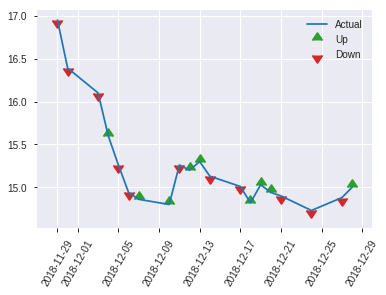


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20343752365227766
RMSE: 0.451040490036402
LogLoss: 0.5961069139186634
Null degrees of freedom: 250
Residual degrees of freedom: 177
Null deviance: 347.0162375023202
Residual deviance: 299.24567078716905
AIC: 447.24567078716905
AUC: 0.749839681928947
pr_auc: 0.6866663136380153
Gini: 0.499679363857894
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39480905346646555: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      82   56   0.4058   (56.0/138.0)
1      21   92   0.1858   (21.0/113.0)
Total  103  148  0.3068   (77.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.394809     0.704981  147
max f2                       0.182083     0.811594  237
max f0point5                 0.516098     0.702306  90
max accuracy                 0.44955      0.7251    119
max precision                0.751524     0.9       9
max recall                   0.143379     1         246
max specificity              0.845641     0.992754  0
max absolute_mcc             0.44955      0.448493  119
max min_per_class_accuracy   0.44955      0.724638  119
max mean_per_class_accuracy  0.44955      0.725151  119

Gains/Lift Table: Avg response rate: 45.02 %, avg score: 44.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.802153           1.48083   1.48083            0.666667         0.82037   0.666667                    0.82037             0.0176991       0.0176991                  48.0826   48.0826
    2        0.0239044                   0.771828           2.22124   1.85103            1                0.788066  0.833333                    0.804218            0.0265487       0.0442478                  122.124   85.1032
    3        0.0318725                   0.754143           2.22124   1.94358            1                0.757625  0.875                       0.79257             0.0176991       0.0619469                  122.124   94.3584
    4        0.0438247                   0.742336           1.48083   1.81738            0.666667         0.749299  0.818182                    0.780769            0.0176991       0.079646                   48.0826   81.7377
    5        0.0517928                   0.726167           1.11062   1.70865            0.5              0.72784   0.769231                    0.772626            0.00884956      0.0884956                  11.0619   70.8645
    6        0.103586                    0.691052           1.53778   1.62321            0.692308         0.712174  0.730769                    0.7424              0.079646        0.168142                   53.7781   62.3213
    7        0.151394                    0.655042           2.03614   1.75361            0.916667         0.67218   0.789474                    0.720225            0.0973451       0.265487                   103.614   75.361
    8        0.203187                    0.623113           1.53778   1.69859            0.692308         0.641396  0.764706                    0.700131            0.079646        0.345133                   53.7781   69.8594
    9        0.302789                    0.57024            1.33274   1.57825            0.6              0.597444  0.710526                    0.666353            0.132743        0.477876                   33.2743   57.8249
    10       0.40239                     0.491363           1.42159   1.53947            0.64             0.52379   0.693069                    0.631065            0.141593        0.619469                   42.1593   53.9473
    11       0.501992                    0.440019           1.15504   1.4632             0.52             0.464048  0.65873                     0.597927            0.115044        0.734513                   15.5044   46.3197
    12       0.601594                    0.386605           0.799646  1.35334            0.36             0.412655  0.609272                    0.567253            0.079646        0.814159                   -20.0354  35.3338
    13       0.701195                    0.319638           0.444248  1.22421            0.2              0.358795  0.551136                    0.537642            0.0442478       0.858407                   -55.5752  22.4206
    14       0.800797                    0.268564           0.355398  1.11614            0.16             0.286381  0.502488                    0.506391            0.0353982       0.893805                   -64.4602  11.6145
    15       0.900398                    0.211265           0.621947  1.06148            0.28             0.235631  0.477876                    0.476439            0.0619469       0.955752                   -37.8053  6.1477
    16       1                           0.0852487          0.444248  1                  0.2              0.168466  0.450199                    0.445765           

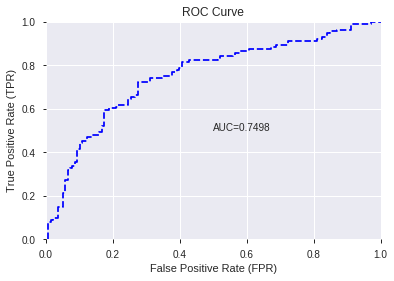

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


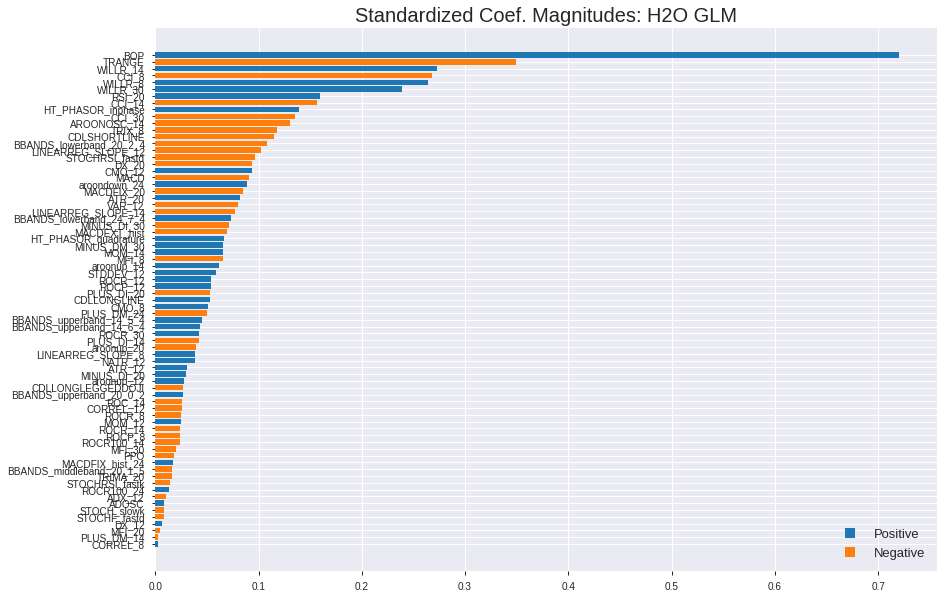

'log_likelihood'
--2019-08-27 18:14:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.44
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.44|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


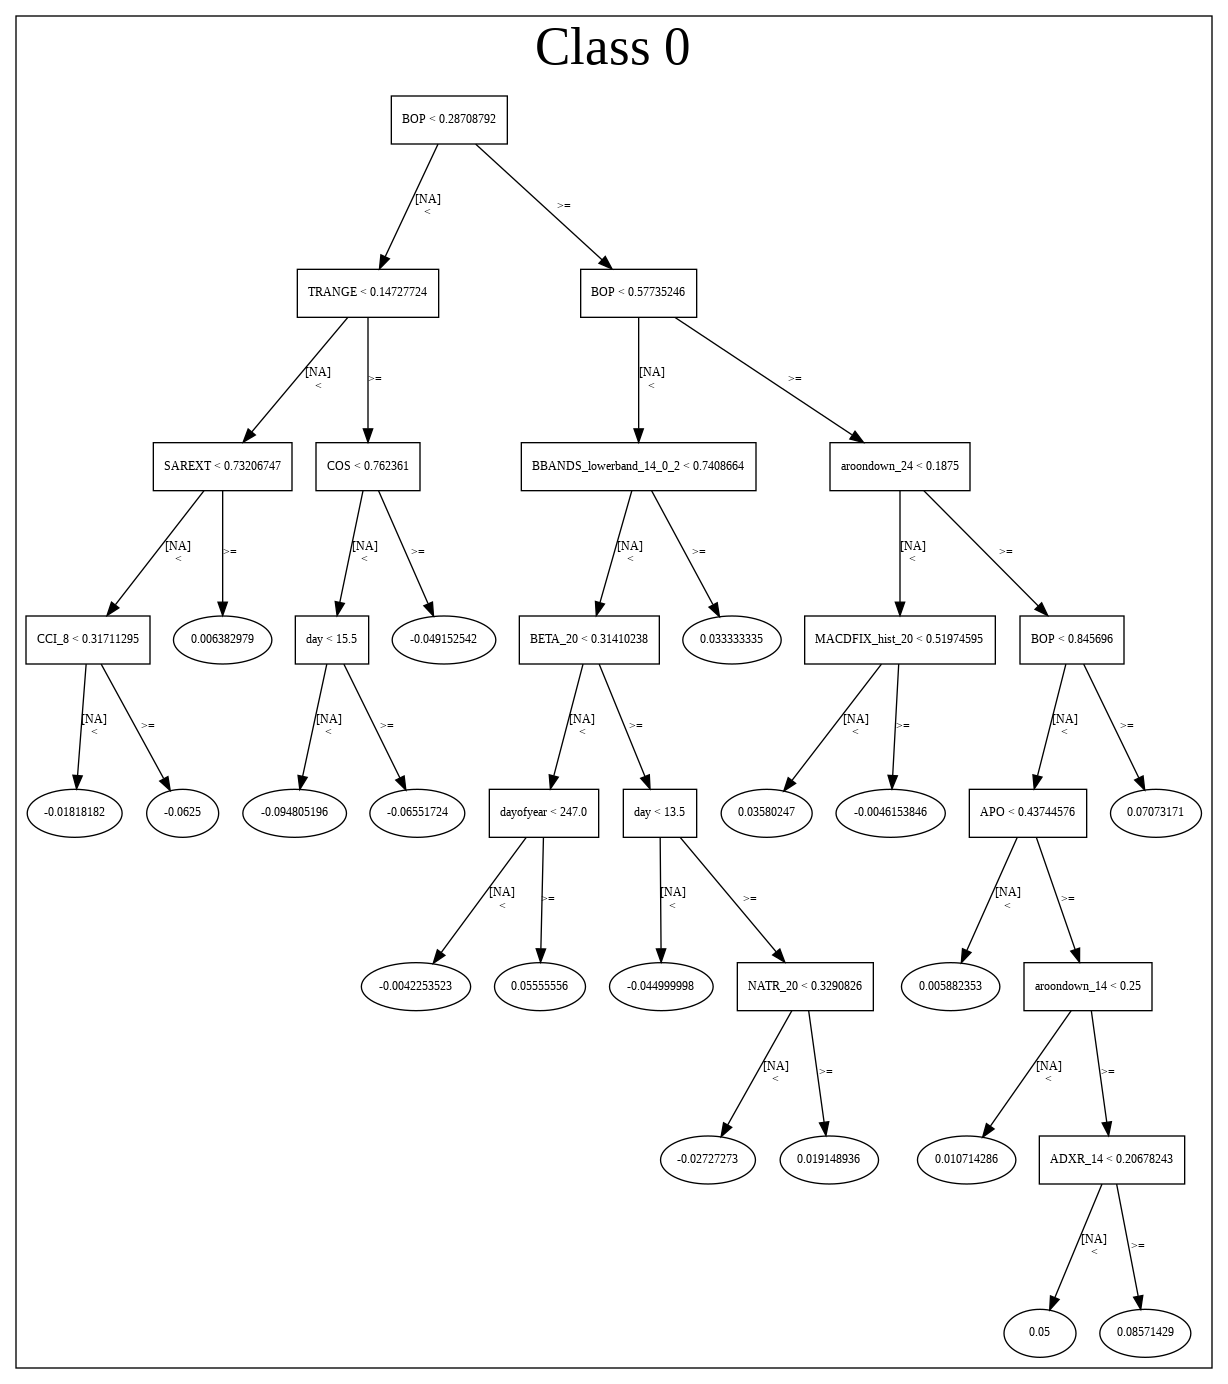

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_181449_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_181449_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_b872',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'WILLR_14',
 'CCI_8',
 'WILLR_8',
 'WILLR_30',
 'RSI_20',
 'CCI_14',
 'HT_PHASOR_inphase',
 'CCI_30',
 'AROONOSC_14',
 'TRIX_8',
 'CDLSHORTLINE',
 'BBANDS_lowerband_20_2_4',
 'LINEARREG_SLOPE_12',
 'STOCHRSI_fastd',
 'DX_20',
 'CMO_12',
 'MACD',
 'aroondown_24',
 'MACDFIX_20',
 'ATR_20',
 'VAR_12',
 'LINEARREG_SLOPE_14',
 'BBANDS_lowerband_24_7_4',
 'MINUS_DI_30',
 'MACDEXT_hist',
 'HT_PHASOR_quadrature',
 'MINUS_DM_30',
 'MOM_14',
 'MFI_8',
 'aroonup_14',
 'STDDEV_12',
 'ROCR_12',
 'ROCP_12',
 'PLUS_DI_20',
 'CDLLONGLINE',
 'CMO_8',
 'PLUS_DM_24',
 'BBANDS_upperband_14_5_4',
 'BBANDS_upperband_14_6_4',
 'ROCR_30',
 'PLUS_DI_14',
 'aroonup_20',
 'LINEARREG_SLOPE_8',
 'NATR_12',
 'ATR_12',
 'MINUS_DI_20',
 'aroonup_12',
 'CDLLONGLEGGEDDOJI',
 'BBANDS_upperband_20_0_2',
 'ROC_14',
 'CORREL_12',
 'ROCR_8',
 'MOM_12',
 'ROCR_14',
 'ROCP_8',
 'ROCR100_14',
 'MFI_30',
 'PPO',
 'MACDFIX_hist_24',
 'BBANDS_middleband_20_1_5',
 'TRIMA_20',
 'STOCHRSI_fastk',
 'ROCR100_24',
 

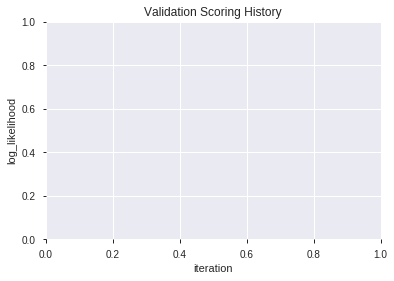

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_181506_model_4  0.721656  0.617135              0.348179  0.462987  0.214357
1               XGBoost_2_AutoML_20190827_181506  0.718417  0.613110              0.342952  0.461469  0.212954
2               XGBoost_1_AutoML_20190827_181506  0.710466  0.625543              0.344556  0.467369  0.218433
3  XGBoost_grid_1_AutoML_20190827_181506_model_6  0.704181  0.633118              0.397332  0.471364  0.222184
4  XGBoost_grid_1_AutoML_20190827_181506_model_2  0.702001  0.627487              0.366327  0.468319  0.219322
5  XGBoost_grid_1_AutoML_20190827_181506_model_1  0.700398  0.631054              0.404579  0.470588  0.221453
6  XGBoost_grid_1_AutoML_20190827_181506_model_5  0.699179  0.639000              0.386848  0.473052  0.223779
7  XGBoost_grid_1_AutoML_20190827_181506_model_3  0.698410  0.628150              0.346960  0.469000  0.219961
8               XGBoost_3_AutoML_20190827_181506  0.694883  0.633433              0.373573  0.471555  0.222364
9  XGBoost_grid_1_AutoML_20190827_181506_model_7  0.688726  0.634153              0.355425  0.472017  0.222800

variable  relative_importance  scaled_importance  percentage
0                        BOP          2265.045166           1.000000    0.485476
1                     TRANGE           454.398499           0.200613    0.097393
2                    WILLR_8            95.918747           0.042347    0.020559
3                      CCI_8            93.926178           0.041468    0.020132
4                      ADOSC            91.632156           0.040455    0.019640
5                  CORREL_12            86.202148           0.038058    0.018476
6                   WILLR_14            64.939163           0.028670    0.013919
7               MACDEXT_hist            63.352234           0.027970    0.013579
8                      MFI_8            60.720356           0.026808    0.013014
9                      DX_12            60.217178           0.026585    0.012907
10                ROCR100_24            56.108208           0.024771    0.012026
11                    ATR_12            56.020588           0.024733    0.012007
12                    MFI_20            55.308540           0.024418    0.011854
13            STOCHRSI_fastd            51.533470           0.022752    0.011045
14                    CCI_14            50.015110           0.022081    0.010720
15                PLUS_DI_20            48.370392           0.021355    0.010367
16                   NATR_12            46.704762           0.020620    0.010010
17                     DX_20            44.453747           0.019626    0.009528
18      HT_PHASOR_quadrature            44.280994           0.019550    0.009491
19                 STDDEV_12            41.395897           0.018276    0.008873
20   BBANDS_upperband_20_0_2            40.186081           0.017742    0.008613
21               AROONOSC_14            37.274242           0.016456    0.007989
22               MINUS_DI_20            35.281300           0.015576    0.007562
23                  CORREL_8            35.206829           0.015544    0.007546
24                    ROCP_8            34.321255           0.015153    0.007356
25                    MFI_30            33.828014           0.014935    0.007250
26            STOCHRSI_fastk            31.931355           0.014097    0.006844
27                    ATR_20            30.464828           0.013450    0.006530
28              aroondown_24            27.893549           0.012315    0.005979
29                PLUS_DM_14            27.559525           0.012167    0.005907
30        LINEARREG_SLOPE_12            27.364929           0.012081    0.005865
31               MINUS_DI_30            27.234467           0.012024    0.005837
32                    MOM_12            26.026665           0.011491    0.005578
33         LINEARREG_SLOPE_8            26.004776           0.011481    0.005574
34           MACDFIX_hist_24            25.823582           0.011401    0.005535
35   BBANDS_lowerband_24_7_4            25.786844           0.011385    0.005527
36               STOCH_slowk            25.633121           0.011317    0.005494
37                   ROCP_12            24.367865           0.010758    0.005223
38   BBANDS_upperband_14_5_4            23.003380           0.010156    0.004930
39   BBANDS_upperband_14_6_4            22.915371           0.010117    0.004912
40                  WILLR_30            21.388641           0.009443    0.004584
41                PLUS_DM_24            21.049438           0.009293    0.004512
42                    ADX_12            19.866636           0.008771    0.004258
43                PLUS_DI_14            17.615589           0.007777    0.003776
44                aroonup_12            17.448217           0.007703    0.003740
45                       PPO            17.349594           0.007660    0.003719
46   BBANDS_lowerband_20_2_4            17.286758           0.007632    0.003705
47         HT_PHASOR_inphase            16.248264           0.007173    0.003483
48                aroonup_14            15.864840  

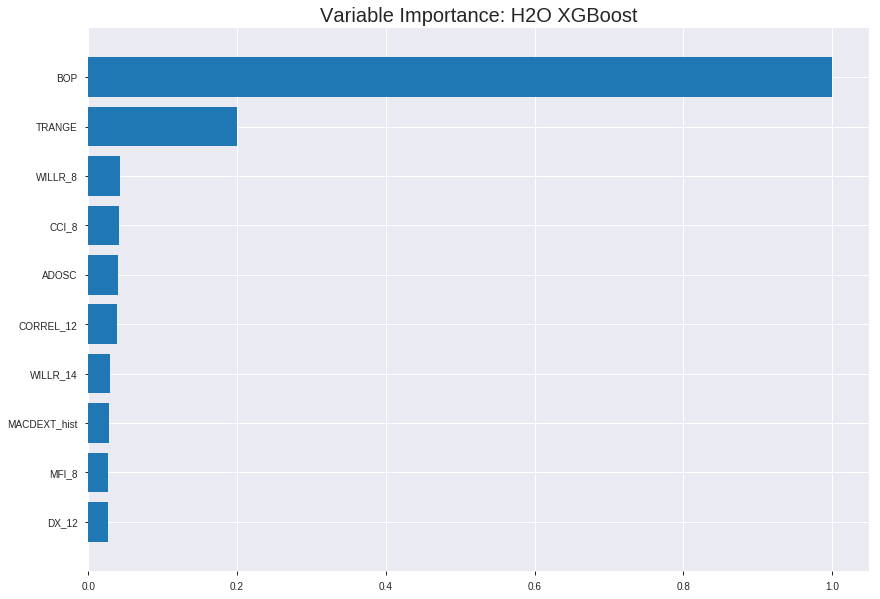

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_181506_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2117876490979958
RMSE: 0.46020392121101683
LogLoss: 0.6089487771662898
Mean Per-Class Error: 0.36396257373911
AUC: 0.7153396882447162
pr_auc: 0.7249749399105524
Gini: 0.43067937648943233
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49999934152697856: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      328  567   0.6335   (567.0/895.0)
1      81   777   0.0944   (81.0/858.0)
Total  409  1344  0.3697   (648.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.499999     0.705722  198
max f2                       0.239419     0.845478  320
max f0point5                 0.52841      0.627369  180
max accuracy                 0.52841      0.634341  180
max precision                0.828475     1         0
max recall                   0.148741     1         372
max specificity              0.828475     1         0
max absolute_mcc             0.499999     0.321575  198
max min_per_class_accuracy   0.501811     0.403263  197
max mean_per_class_accuracy  0.499999     0.636037  198

Gains/Lift Table: Avg response rate: 48.94 %, avg score: 49.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.786042           2.04312   2.04312            1                0.800769  1                           0.800769            0.020979        0.020979                   104.312   104.312
    2        0.0205362                   0.772773           1.92962   1.98637            0.944444         0.780697  0.972222                    0.790733            0.0198135       0.0407925                  92.9617   98.637
    3        0.0302339                   0.760845           1.92294   1.96602            0.941176         0.76567   0.962264                    0.782694            0.018648        0.0594406                  92.294    96.6025
    4        0.040502                    0.750897           1.81611   1.92802            0.888889         0.755571  0.943662                    0.775818            0.018648        0.0780886                  81.611    92.8018
    5        0.0501997                   0.74126            1.56239   1.85739            0.764706         0.746998  0.909091                    0.77025             0.0151515       0.0932401                  56.2389   85.7385
    6        0.100399                    0.673412           1.78773   1.82256            0.875            0.705488  0.892045                    0.737869            0.0897436       0.182984                   78.7733   82.2559
    7        0.150029                    0.626947           1.40905   1.68577            0.689655         0.649603  0.825095                    0.708671            0.0699301       0.252914                   40.9051   68.5771
    8        0.200228                    0.581034           1.23052   1.57163            0.602273         0.604458  0.769231                    0.682543            0.0617716       0.314685                   23.0518   57.1633
    9        0.766115                    0.5                1.04422   1.18206            0.511089         0.505495  0.578555                    0.551767            0.590909        0.905594                   4.42174   18.206
    10       0.799772                    0.451338           0.519438  1.15418            0.254237         0.479506  0.564907                    0.548727            0.0174825       0.923077                   -48.0562  15.4175
    11       0.899601                    0.238306           0.642125  1.09735            0.314286         0.360788  0.537096                    0.527871            0.0641026       0.987179                   -35.7875  9.7353
    12       1                           0.113339           0.127695  1                  0.0625           0.162576  0.489447                    0.491196            0.0128205       1                          -87.2305  0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.21450419751230093
RMSE: 0.46314597862045714
LogLoss: 0.6165708804065745
Mean Per-Class Error: 0.3298280994910209
AUC: 0.7172524728704504
pr_auc: 0.6446766324501735
Gini: 0.4345049457409007
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4085412174463272: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      113  154  0.5768   (154.0/267.0)
1      29   205  0.1239   (29.0/234.0)
Total  142  359  0.3653   (183.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.408541     0.6914    268
max f2                       0.225829     0.827415  371
max f0point5                 0.548564     0.650264  179
max accuracy                 0.548564     0.672655  179
max precision                0.8191       1         0
max recall                   0.165147     1         381
max specificity              0.8191       1         0
max absolute_mcc             0.548564     0.341241  179
max min_per_class_accuracy   0.532388     0.645299  191
max mean_per_class_accuracy  0.548564     0.670172  179

Gains/Lift Table: Avg response rate: 46.71 %, avg score: 49.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.765768           1.42735   1.42735            0.666667         0.779724  0.666667                    0.779724            0.017094        0.017094                   42.735    42.735
    2        0.0219561                   0.748501           1.71282   1.55711            0.8              0.757671  0.727273                    0.7697              0.017094        0.034188                   71.2821   55.711
    3        0.0319361                   0.743179           0.85641   1.33814            0.4              0.745521  0.625                       0.762144            0.00854701      0.042735                   -14.359   33.8141
    4        0.0419162                   0.740164           1.28462   1.3254             0.6              0.741759  0.619048                    0.757291            0.0128205       0.0555556                  28.4615   32.5397
    5        0.0518962                   0.733863           2.14103   1.48225            1                0.735559  0.692308                    0.753111            0.0213675       0.0769231                  114.103   48.2249
    6        0.101796                    0.694893           1.62718   1.55329            0.76             0.711079  0.72549                     0.732507            0.0811966       0.15812                    62.7179   55.3293
    7        0.151697                    0.663657           1.62718   1.5776             0.76             0.674328  0.736842                    0.713369            0.0811966       0.239316                   62.7179   57.7598
    8        0.201597                    0.647939           1.19897   1.48388            0.56             0.654857  0.693069                    0.698886            0.0598291       0.299145                   19.8974   48.3879
    9        0.301397                    0.607635           1.49872   1.48879            0.7              0.625811  0.695364                    0.674689            0.149573        0.448718                   49.8718   48.8793
    10       0.401198                    0.573216           1.15615   1.40605            0.54             0.5893    0.656716                    0.653448            0.115385        0.564103                   15.6154   40.6047
    11       0.500998                    0.521128           0.899231  1.30509            0.42             0.547362  0.609562                    0.632315            0.0897436       0.653846                   -10.0769  30.5087
    12       0.600798                    0.493965           1.11333   1.27323            0.52             0.504344  0.594684                    0.611058            0.111111        0.764957                   11.3333   27.3235
    13       0.700599                    0.417394           0.942051  1.22606            0.44             0.468411  0.57265                     0.590738            0.0940171       0.858974                   -5.79487  22.6057
    14       0.800399                    0.324512           0.685128  1.15861            0.32             0.367349  0.541147                    0.562884            0.0683761       0.92735                    -31.4872  15.861
    15       0.9002                      0.252499           0.471026  1.08238            0.22             0.285361  0.505543                    0.532116            0.0470085       0.974359                   -52.8974  8.2381
    16       1                           0.103723           0.256923  1                  0.12             0.186056  0.467066                    0.497579            0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:15:14  3.282 sec   0                  0.5              0.693147            0.5             0                  1                0.510553                         0.5                0.693147              0.5               0                    1                  0.532934
    2019-08-27 18:15:14  3.413 sec   5                  0.478386         0.650566            0.779533        0.746174           1.89719          0.305762                         0.486156           0.665672              0.707233          0.648712             2.14103            0.363273
    2019-08-27 18:15:14  3.472 sec   10                 0.463982         0.622314            0.783725        0.768718           2.04312          0.292641                         0.476066           0.645599              0.719669          0.650347             1.42735            0.355289
    2019-08-27 18:15:14  3.548 sec   15                 0.45418          0.60273             0.790057        0.773162           2.04312          0.301768                         0.481423           0.655509              0.659144          0.61955              1.78419            0.44511
    2019-08-27 18:15:15  3.618 sec   20                 0.463186         0.619055            0.742676        0.740879           2.04312          0.352539                         0.466966           0.626654              0.724711          0.655337             1.42735            0.363273
    2019-08-27 18:15:15  3.687 sec   25                 0.441964         0.577452            0.79937         0.782751           2.04312          0.27895                          0.46524            0.622583              0.721326          0.652169             1.78419            0.361277
    2019-08-27 18:15:15  3.753 sec   30                 0.437627         0.568198            0.802766        0.786083           2.04312          0.266971                         0.463081           0.617694              0.723583          0.654868             1.78419            0.351297
    2019-08-27 18:15:15  3.820 sec   35                 0.462082         0.61477             0.730211        0.728822           2.04312          0.353109                         0.482262           0.656286              0.641162          0.619277             1.42735            0.471058
    2019-08-27 18:15:15  3.892 sec   40                 0.462843         0.615082            0.702939        0.709701           2.04312          0.389047                         0.479059           0.648648              0.640009          0.59629              1.78419            0.433134
    2019-08-27 18:15:15  3.974 sec   45                 0.470776         0.630443            0.663854        0.685523           2.04312          0.409584                         0.496079           0.684487              0.52396           0.615557             1.78419            0.520958
    2019-08-27 18:15:15  4.048 sec   50                 0.460204         0.608949            0.71534         0.724975           2.04312          0.369652                         0.463146           0.616571              0.717252          0.644677             1.42735            0.365269

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ---------------------
BOP                 2265.045166015625      1.0                    0.485475766156296
TRANGE              454.39849853515625     0.20061343824524056    0.09739296263335694
WILLR_8             95.91874694824219      0.0423473882054944     0.02055863073378049
CCI_8               93.92617797851562      0.04146768434809555    0.020131555829619133
ADOSC               91.63215637207031      0.04045489147276377    0.0196398694325098
---                 ---                    ---                    ---
MACDFIX_20          6.496333122253418      0.0028680810518586382  0.0013923838460494279
LINEARREG_SLOPE_14  5.949765205383301      0.0026267755251209225  0.0012752358605786867
MACD                5.893594741821289      0.0026019766979695773  0.0012631966309676098
TRIMA_20            5.674996852874756      0.0025054674131984207  0.0012163437120021364
CMO_8               3.6245737075805664     0.001600221382762291   0.0007768687018162106


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6812749003984063)

('F1', 0.6804123711340205)

('auc', 0.7216557650378351)

('logloss', 0.6171348440567415)

('mean_per_class_error', 0.316307554187508)

('rmse', 0.4629871217248042)

('mse', 0.21435707488301867)

xgboost prediction progress: |████████████████████████████████████████████| 100%


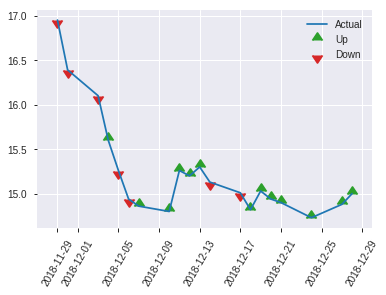


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21435707488301867
RMSE: 0.4629871217248042
LogLoss: 0.6171348440567415
Mean Per-Class Error: 0.316307554187508
AUC: 0.7216557650378351
pr_auc: 0.6482839116617948
Gini: 0.44331153007567026
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3944227993488312: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      59   79   0.5725   (79.0/138.0)
1      14   99   0.1239   (14.0/113.0)
Total  73   178  0.3705   (93.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.394423     0.680412  177
max f2                       0.241787     0.817656  237
max f0point5                 0.523613     0.644628  122
max accuracy                 0.523613     0.681275  122
max precision                0.813565     1         0
max recall                   0.241787     1         237
max specificity              0.813565     1         0
max absolute_mcc             0.511794     0.365584  126
max min_per_class_accuracy   0.526164     0.673913  121
max mean_per_class_accuracy  0.511794     0.683692  126

Gains/Lift Table: Avg response rate: 45.02 %, avg score: 49.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.762718           1.48083   1.48083            0.666667         0.785282  0.666667                    0.785282            0.0176991       0.0176991                  48.0826   48.0826
    2        0.0239044                   0.748885           1.48083   1.48083            0.666667         0.755821  0.666667                    0.770551            0.0176991       0.0353982                  48.0826   48.0826
    3        0.0318725                   0.738141           2.22124   1.66593            1                0.741761  0.75                        0.763354            0.0176991       0.0530973                  122.124   66.5929
    4        0.0438247                   0.724208           1.48083   1.61545            0.666667         0.730243  0.727273                    0.754323            0.0176991       0.0707965                  48.0826   61.5447
    5        0.0517928                   0.710131           1.11062   1.53778            0.5              0.714304  0.692308                    0.748167            0.00884956      0.079646                   11.0619   53.7781
    6        0.103586                    0.669743           2.05037   1.79408            0.923077         0.68494   0.807692                    0.716554            0.106195        0.185841                   105.037   79.4078
    7        0.151394                    0.655997           1.11062   1.57825            0.5              0.662295  0.710526                    0.699419            0.0530973       0.238938                   11.0619   57.8249
    8        0.203187                    0.638532           1.70865   1.61149            0.769231         0.644691  0.72549                     0.685469            0.0884956       0.327434                   70.8645   61.1487
    9        0.302789                    0.593571           1.42159   1.54902            0.64             0.61091   0.697368                    0.660943            0.141593        0.469027                   42.1593   54.9022
    10       0.40239                     0.551485           0.977345  1.40752            0.44             0.57423   0.633663                    0.639479            0.0973451       0.566372                   -2.26549  40.7518
    11       0.501992                    0.512923           1.33274   1.39268            0.6              0.534202  0.626984                    0.618591            0.132743        0.699115                   33.2743   39.2682
    12       0.601594                    0.474153           0.621947  1.26508            0.28             0.496375  0.569536                    0.598356            0.0619469       0.761062                   -37.8053  26.5076
    13       0.701195                    0.400602           0.977345  1.22421            0.44             0.44307   0.551136                    0.576299            0.0973451       0.858407                   -2.26549  22.4206
    14       0.800797                    0.32608            0.444248  1.1272             0.2              0.354579  0.507463                    0.548722            0.0442478       0.902655                   -55.5752  12.7196
    15       0.900398                    0.272205           0.621947  1.07131            0.28             0.304375  0.482301                    0.521692            0.0619469       0.964602                   -37.8053  7.13055
    16       1                           0.100964           0.355398  1                  0.16             0.216412  0.450199                    0.491286         

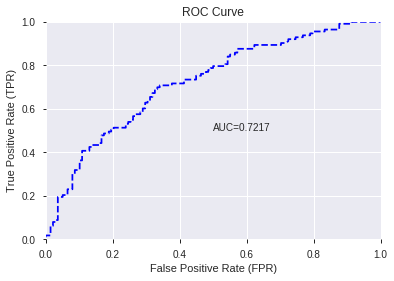

This function is available for GLM models only


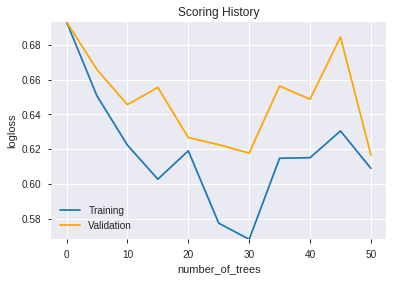

--2019-08-27 18:15:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.101.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.101.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

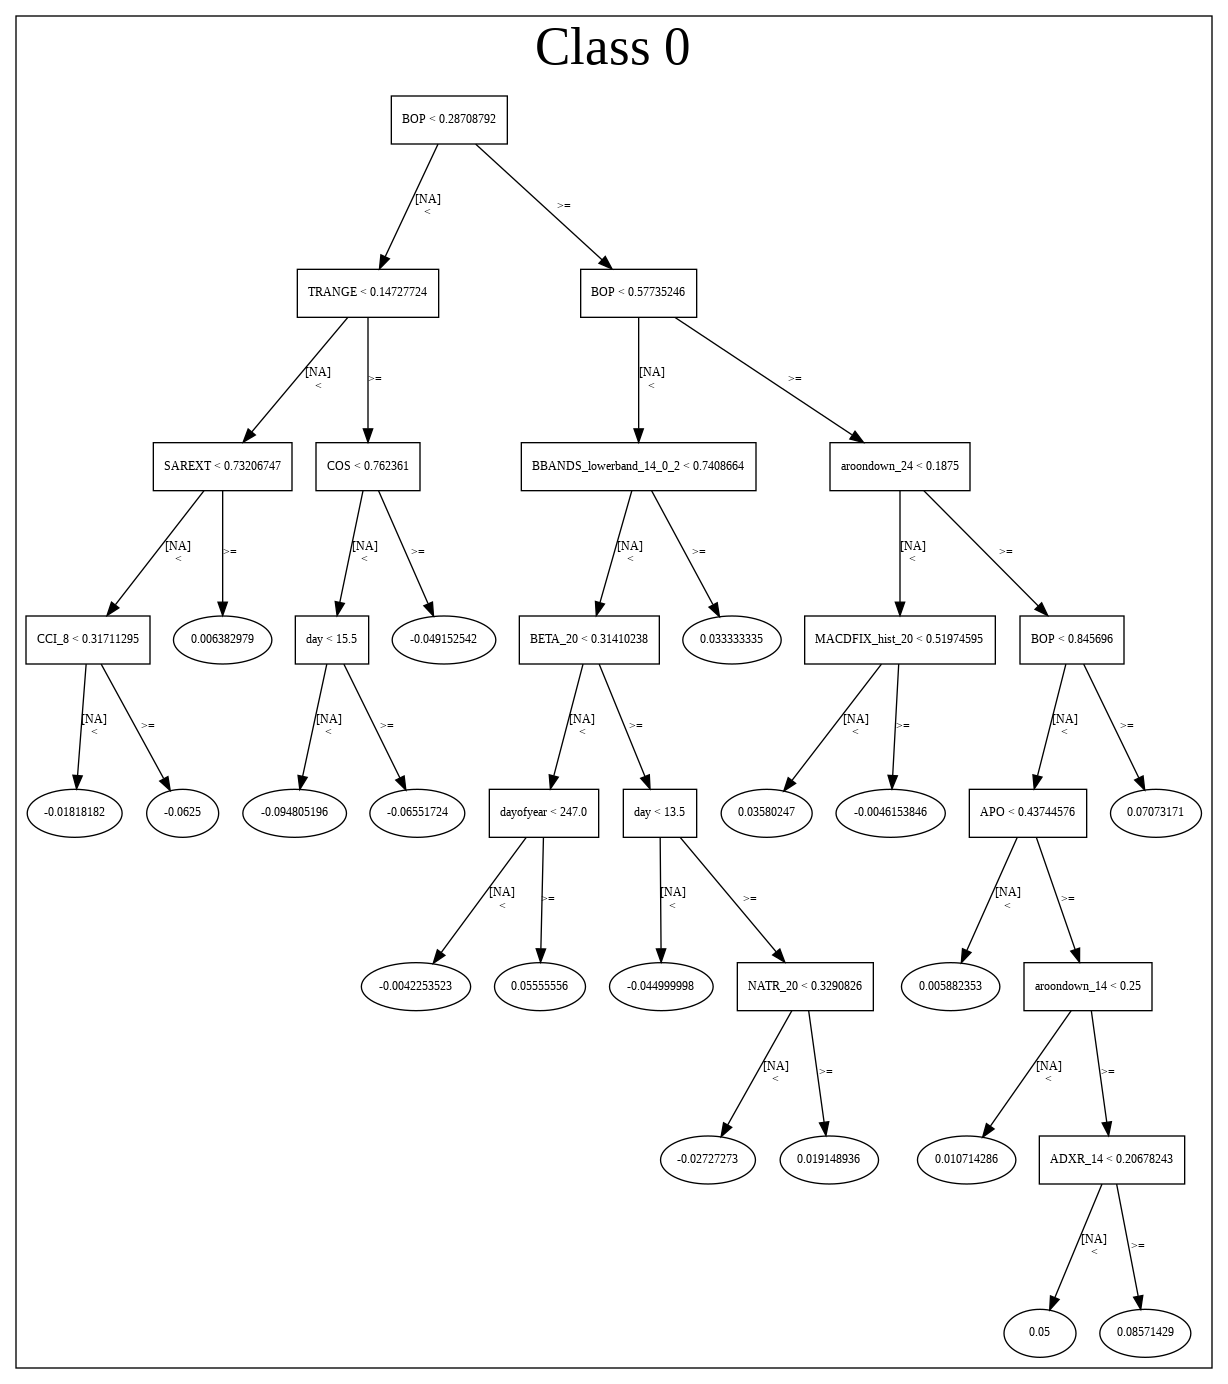

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_181506_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_181506_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_b872',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'WILLR_8',
 'CCI_8',
 'ADOSC',
 'CORREL_12',
 'WILLR_14',
 'MACDEXT_hist',
 'MFI_8',
 'DX_12',
 'ROCR100_24',
 'ATR_12',
 'MFI_20',
 'STOCHRSI_fastd',
 'CCI_14',
 'PLUS_DI_20',
 'NATR_12',
 'DX_20',
 'HT_PHASOR_quadrature',
 'STDDEV_12',
 'BBANDS_upperband_20_0_2',
 'AROONOSC_14',
 'MINUS_DI_20',
 'CORREL_8',
 'ROCP_8',
 'MFI_30',
 'STOCHRSI_fastk',
 'ATR_20',
 'aroondown_24',
 'PLUS_DM_14',
 'LINEARREG_SLOPE_12',
 'MINUS_DI_30',
 'MOM_12',
 'LINEARREG_SLOPE_8',
 'MACDFIX_hist_24',
 'BBANDS_lowerband_24_7_4',
 'STOCH_slowk',
 'ROCP_12',
 'BBANDS_upperband_14_5_4',
 'BBANDS_upperband_14_6_4',
 'WILLR_30',
 'PLUS_DM_24',
 'ADX_12',
 'PLUS_DI_14',
 'aroonup_12',
 'PPO',
 'BBANDS_lowerband_20_2_4',
 'HT_PHASOR_inphase',
 'aroonup_14',
 'CMO_12',
 'BBANDS_middleband_20_1_5',
 'RSI_20',
 'MINUS_DM_30',
 'TRIX_8',
 'MACDFIX_20',
 'LINEARREG_SLOPE_14',
 'MACD',
 'TRIMA_20',
 'CMO_8']

In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.713
GLM             0.741
XGBoost         0.705
dtype: float64

DeepLearning    GLM  XGBoost
All          0.713  0.741    0.697
DLF          0.697  0.697    0.685
Fwe          0.697  0.693    0.705
RFE          0.681  0.725    0.681
XGBF         0.705  0.697    0.685





F1


DeepLearning    0.714
GLM             0.711
XGBoost         0.708
dtype: float64

DeepLearning    GLM  XGBoost
All          0.684  0.711    0.698
DLF          0.708  0.709    0.708
Fwe          0.714  0.702    0.699
RFE          0.683  0.705    0.680
XGBF         0.691  0.709    0.708





auc


DeepLearning    0.743
GLM             0.761
XGBoost         0.741
dtype: float64

DeepLearning    GLM  XGBoost
All          0.738  0.761    0.735
DLF          0.730  0.741    0.741
Fwe          0.743  0.743    0.736
RFE          0.721  0.750    0.722
XGBF         0.731  0.741    0.741





logloss


DeepLearning    0.648
GLM             0.612
XGBoost         0.617
dtype: float64

DeepLearning    GLM  XGBoost
All          0.629  0.591    0.604
DLF          0.648  0.612    0.612
Fwe          0.635  0.611    0.616
RFE          0.633  0.596    0.617
XGBF         0.623  0.612    0.612





mean_per_class_error


DeepLearning    0.315
GLM             0.297
XGBoost         0.316
dtype: float64

DeepLearning    GLM  XGBoost
All          0.291  0.262    0.304
DLF          0.293  0.297    0.300
Fwe          0.290  0.297    0.290
RFE          0.315  0.275    0.316
XGBF         0.295  0.297    0.300





rmse


DeepLearning    0.479
GLM             0.461
XGBoost         0.463
dtype: float64

DeepLearning    GLM  XGBoost
All          0.469  0.449    0.457
DLF          0.479  0.461    0.461
Fwe          0.472  0.460    0.463
RFE          0.470  0.451    0.463
XGBF         0.466  0.461    0.461





mse


DeepLearning    0.230
GLM             0.212
XGBoost         0.214
dtype: float64

DeepLearning    GLM  XGBoost
All          0.220  0.201    0.209
DLF          0.230  0.212    0.213
Fwe          0.223  0.211    0.214
RFE          0.221  0.203    0.214
XGBF         0.217  0.212    0.213

{'F1':       DeepLearning    GLM  XGBoost
 All          0.684    NaN      NaN
 DLF          0.708    NaN      NaN
 DLF            NaN  0.709      NaN
 DLF            NaN    NaN    0.708
 All            NaN  0.711      NaN
 All            NaN    NaN    0.698
 XGBF         0.691    NaN      NaN
 XGBF           NaN  0.709      NaN
 XGBF           NaN    NaN    0.708
 Fwe          0.714    NaN      NaN
 Fwe            NaN  0.702      NaN
 Fwe            NaN    NaN    0.699
 RFE          0.683    NaN      NaN
 RFE            NaN  0.705      NaN
 RFE            NaN    NaN    0.680,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.713    NaN      NaN
 DLF          0.697    NaN      NaN
 DLF            NaN  0.697      NaN
 DLF            NaN    NaN    0.685
 All            NaN  0.741      NaN
 All            NaN    NaN    0.697
 XGBF         0.705    NaN      NaN
 XGBF           NaN  0.697      NaN
 XGBF           NaN    NaN    0.685
 Fwe          0.697    NaN      NaN
 Fwe     